In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import division

import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy
import scipy.linalg as sl
import scipy.integrate as spint
import healpy as hp
import multiprocessing as mp

from la_forge.core import Core
from la_forge.diagnostics import plot_chains

from enterprise.signals import parameter
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise import constants as const
from enterprise.signals.signal_base import LogLikelihood

from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler
from enterprise_extensions import blocks as ee_blocks
from enterprise_extensions import deterministic as ee_deterministic

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc


nano12_pkl = '/home/nima/nanograv/12p5yr_bwm/channelized_12yr_v3_partim_py3.pkl'
with open(nano12_pkl, 'rb') as f:
    allpsrs=pickle.load(f)


Do not have acor package


In [41]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    #golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    golden_mean= 0.20
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(2)}

plt.rcParams.update(params)

plotchain_params = {
        'text.usetex':False,
}


/home/nima/anaconda3/envs/nano15/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [42]:
import random
def sample_hist(weights, centers, num_points=int(1e5), sample_bounds=None, verbose=False):
    #make sure the weights are properly normalized
    #print(weights)
    #print(centers)
    norm = np.sum(weights)
    normed_weights = weights/norm
    #print(normed_weights)
    
    #go through weights and see if there are lower and upper bounds. This will speed up resampling
    
            
            
    #print("lower, upper bounds are: {} and {}\nthe likelihoods between are {}:".format(lower, upper, normed_weights[lower:upper]))    
    
    
    accepted = 0
    
    resampled_chain = []    
    likelihood_interp = scipy.interpolate.interp1d(centers, normed_weights,kind='cubic')
    interpolate_domain = np.linspace(centers[0], centers[-1], 100*len(centers))
    interpolated_like = np.array([likelihood_interp(el) for el in interpolate_domain])
    
    
    
    
    if sample_bounds is None:
        while accepted < num_points:
            amp = random.uniform(centers[0], centers[-1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    else:
        while accepted < num_points:
            amp = random.uniform(sample_bounds[0], sample_bounds[1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    
    #fig, ax1 = plt.subplots()            
    #ax1.scatter(interpolate_domain, interpolated_like, label='Distribution Interpolator', marker='*', s=2)
    #ax1.set_ylim(0, max(interpolated_like) * 1.1)
    #ax2 = ax1.twinx()
    #ax2.hist(resampled_chain, density=True, histtype='step', label='Resampled Histogram', bins=30)
    #plt.show()
    #print(sorted(resampled_chain))
    return sorted(resampled_chain)

In [5]:
def resample_180day_cutoff_worker(psr):
    partial_outdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/'.format(psr.name)
    if not os.path.exists(partial_outdir):
        os.mkdir(partial_outdir)

    lookupdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/{}/'.format(psr.name)

    looktable_path = lookupdir + '{}_lookup.txt'.format(psr.name, psr.name)
    looktable = np.loadtxt(looktable_path)

    parfile = lookupdir + 'pars.txt'.format(psr.name)
    with open(parfile, 'r') as f:
        parlines=f.readlines()

    pardict = {}
    for parline in parlines:
        key, np_pars = parline.split(';')

        start,stop,num = np_pars.split(',')
        pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
        #print(pardict)
    lookup_shape = (len(pardict['ramp_log10_A']), len(pardict['ramp_t0']), len(pardict['sign'])) #let's do this intelligently

    reshaped_looktable = np.reshape(looktable, lookup_shape, order='F')
    #         print(reshaped_looktable.shape)

    amps = pardict['ramp_log10_A']
    t0s = pardict['ramp_t0']
    signs = pardict['sign']




    tmin_mjd_lim = t0s[0] + 180
    tmax_mjd_lim = t0s[-1] - 270

    tmin_idx = np.argmin(np.abs(t0s - tmin_mjd_lim)) 
    tmax_idx = np.argmin(np.abs(t0s - tmax_mjd_lim))

    tmin_mjd = t0s[tmin_idx]
    tmax_mjd = t0s[tmax_idx]


    print("not looking for bursts between MJD {} and MJD {}".format(tmin_mjd, tmax_mjd))
    cols = np.arange(tmin_idx, tmax_idx)

    log10_A_post = np.zeros(len(amps)) 
    for sign_idx, sign in enumerate(signs):
        for log10A_idx in range(len(log10_A_post)):
            submtx_max = np.amax(reshaped_looktable[log10A_idx, :, sign_idx])
            #print(submtx_max)
            #print(np.amin(reshaped_looktable[log10A_idx, :, :]))
            this_l10A_likes = np.zeros(len(cols)) # populate a grid to integrate over to find the
                                                 # epoch-averaged likelihood for this amplitude


            for ii, t0_idx in enumerate(cols):
                # need to add them all into this_l10A_like
                #if reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max > 10:
                #    print("Large likelihood diff")
                like = np.exp(reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max)
                corrected_like = like # no amplitude factor bc integrating over t0
                this_l10A_likes[ii] = corrected_like

            # only need to integrate over the bounds of my custom columns  
            this_l10A_like = spint.simpson(y=this_l10A_likes, x=t0s[cols[0]:cols[-1]+1])
            log10_A_post[log10A_idx] = np.log(this_l10A_like) + submtx_max


        #post-process the log10_amps
        reduced_post=log10_A_post - np.amax(log10_A_post)
        post = np.exp(reduced_post)    
        for amp_idx, amp in enumerate(amps):
            post[amp_idx] = 10**amp * post[amp_idx]

        outfile = partial_outdir + '{}days_{}.txt'.format(180, sign)
        plt.scatter(amps, post, )
        plt.title("PSR {} amplitude posterior".format(psr.name))
        plt.show()
        plt.close()
        # now build the resampled thing and write it to disk
        resampled = sample_hist(post, amps, num_points = 10000,)
        np.savetxt(outfile, resampled)
        #result_dict[sign] = resampled
    #return result_dict

not looking for bursts between MJD 53629.74238097472 and MJD 57649.17779427865


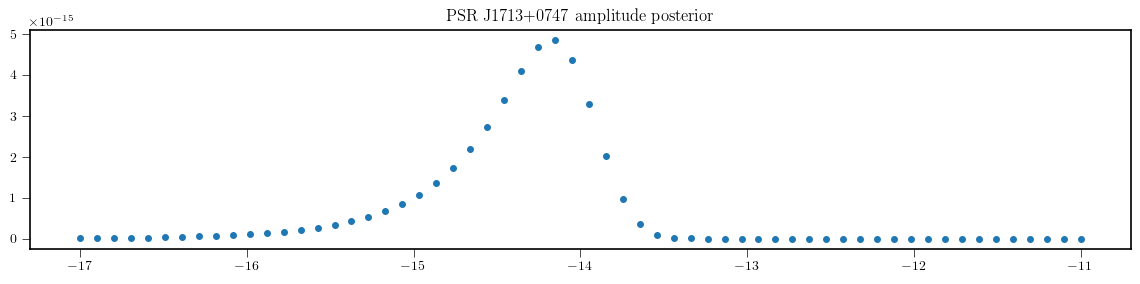

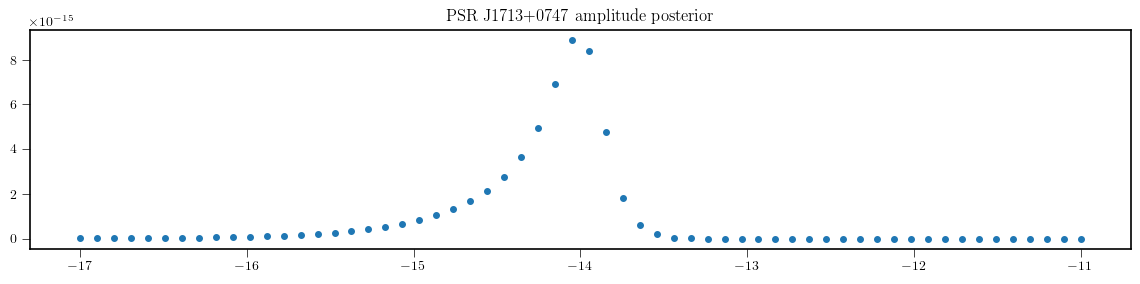

[None]

In [58]:
pool = mp.Pool(processes=2)
pool.map(resample_180day_cutoff_worker,allpsrs[20:21])

# J1713 broken?

In [170]:
J1713_lookup = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg/J1713+0747/J1713+0747_lookup.txt'
looktable = np.loadtxt(J1713_lookup)


parfile = "/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg/J1713+0747/pars.txt"
with open(parfile, 'r') as f:
    parlines=f.readlines()

pardict = {}
for parline in parlines:
    key, np_pars = parline.split(';')

    start,stop,num = np_pars.split(',')
    pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
    #print(pardict)
lookup_shape = (len(pardict['ramp_log10_A']), len(pardict['ramp_t0']), len(pardict['sign'])) #let's do this intelligently

reshaped_looktable = np.reshape(looktable, lookup_shape, order='F')

In [171]:
reshaped_looktable.shape

(45, 149, 2)

(45,)
(45,)
(45,)


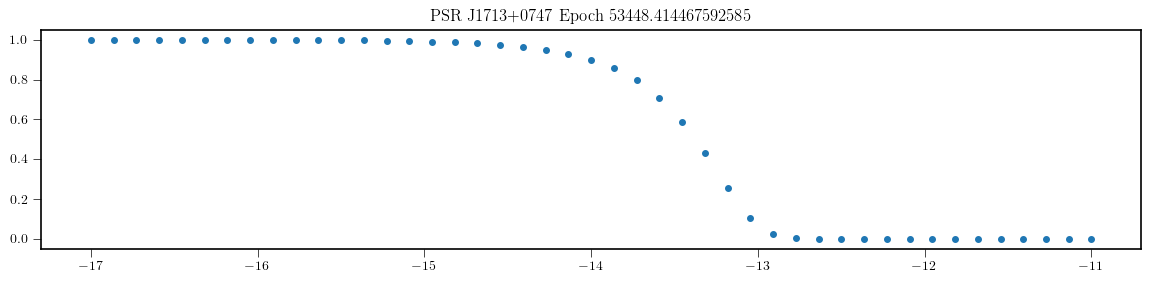

(45,)
(45,)
(45,)


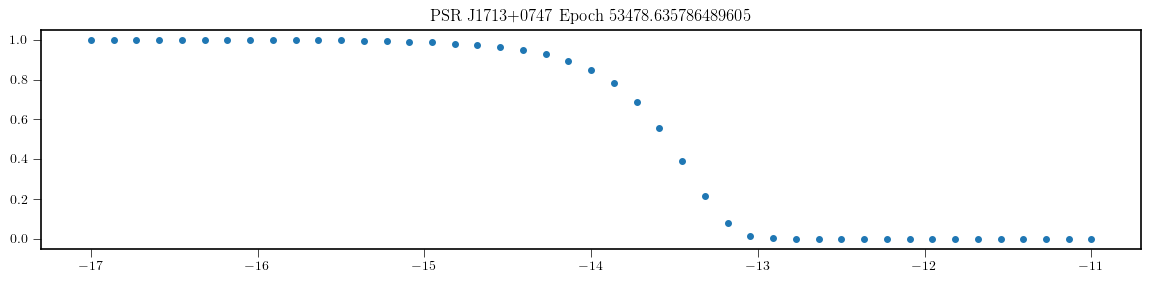

(45,)
(45,)
(45,)


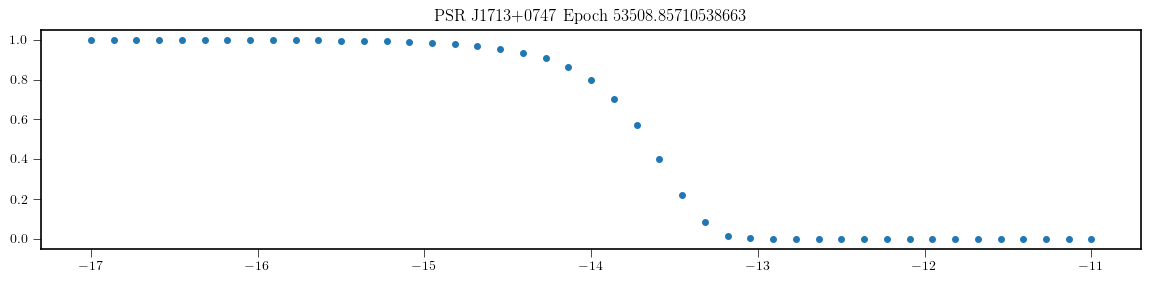

(45,)
(45,)
(45,)


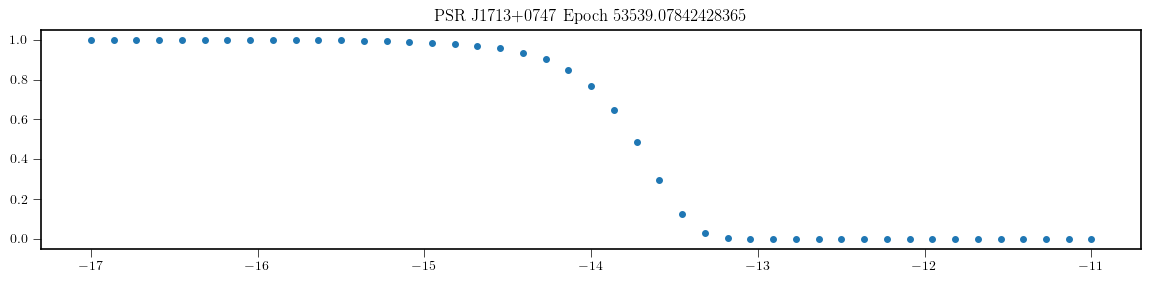

(45,)
(45,)
(45,)


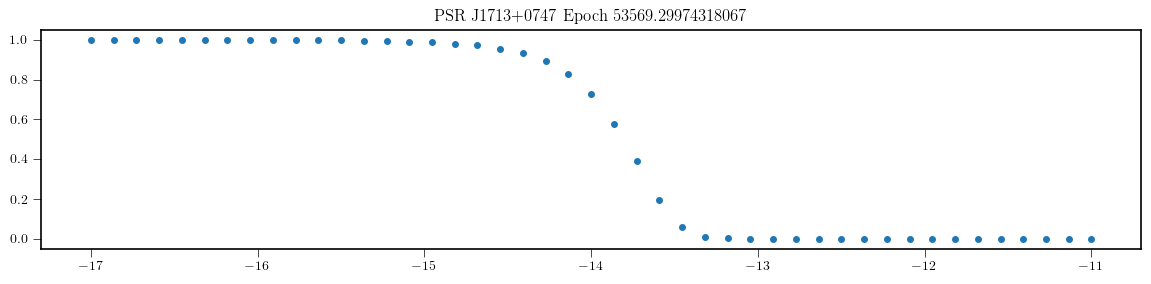

(45,)
(45,)
(45,)


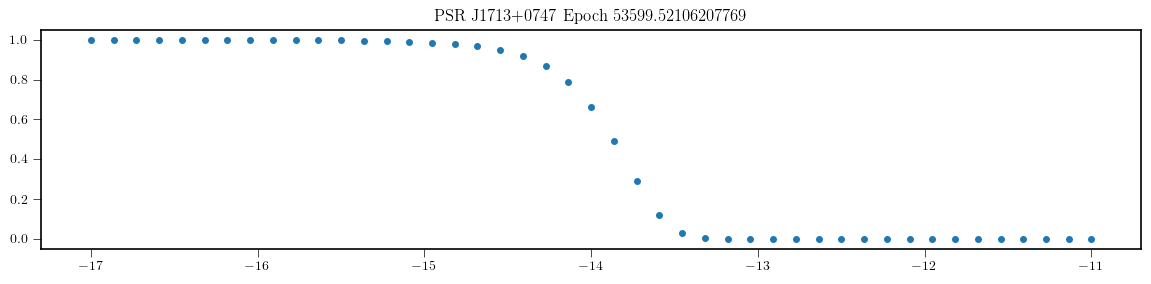

(45,)
(45,)
(45,)


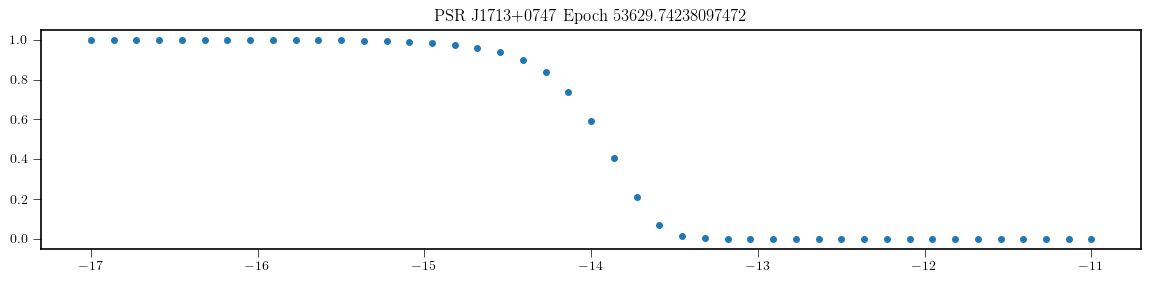

(45,)
(45,)
(45,)


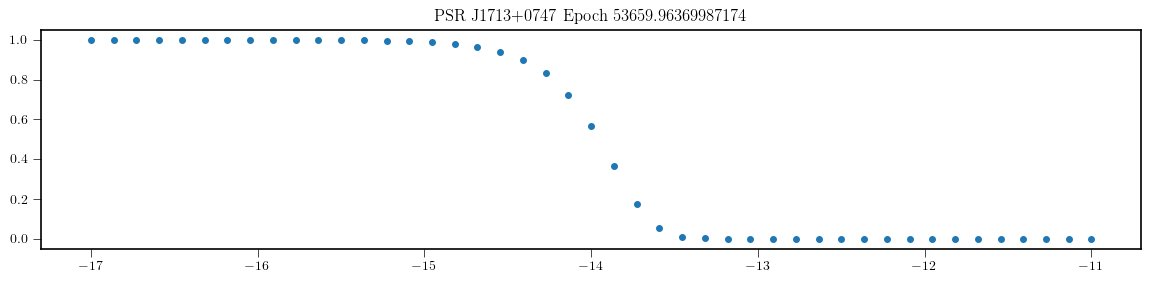

(45,)
(45,)
(45,)


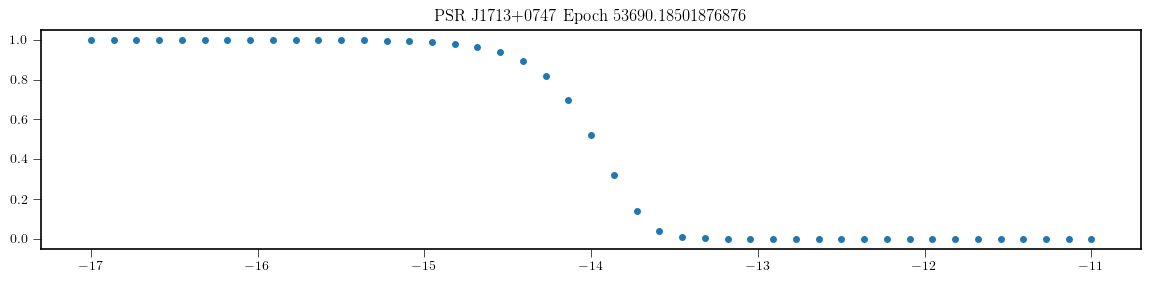

(45,)
(45,)
(45,)


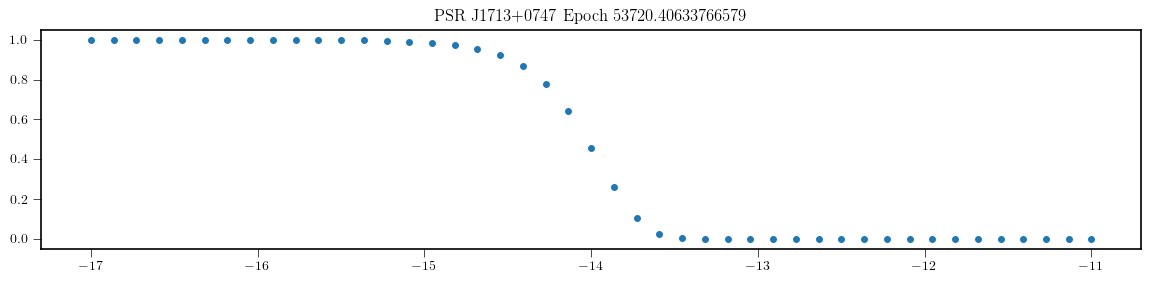

(45,)
(45,)
(45,)


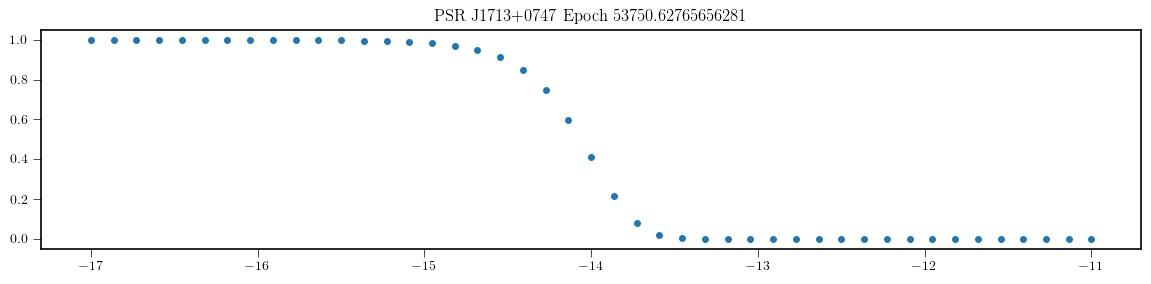

(45,)
(45,)
(45,)


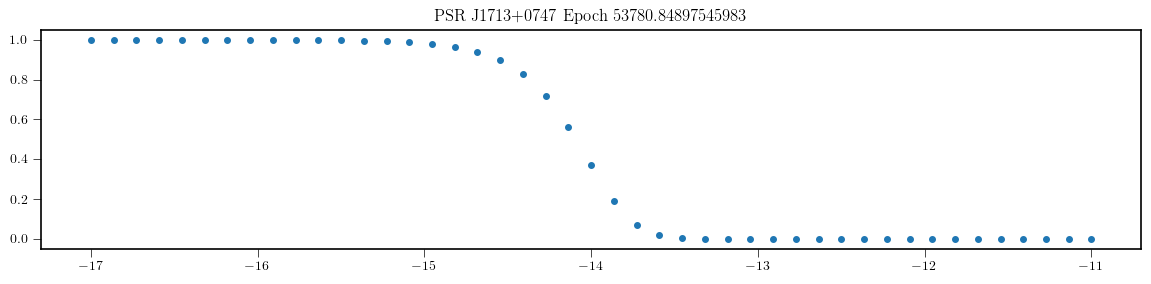

(45,)
(45,)
(45,)


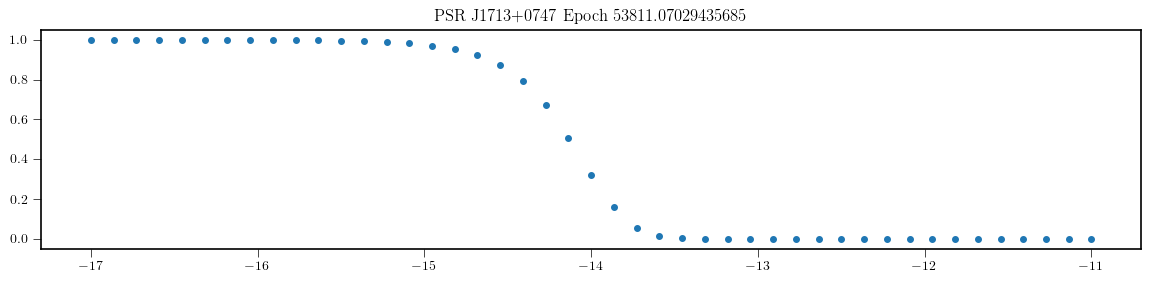

(45,)
(45,)
(45,)


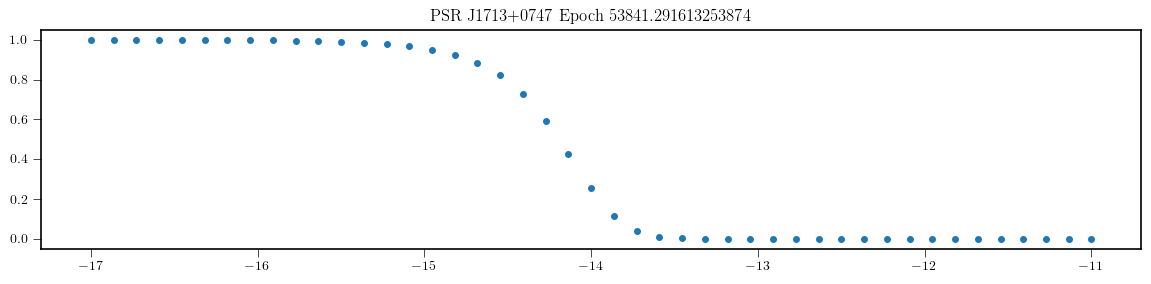

(45,)
(45,)
(45,)


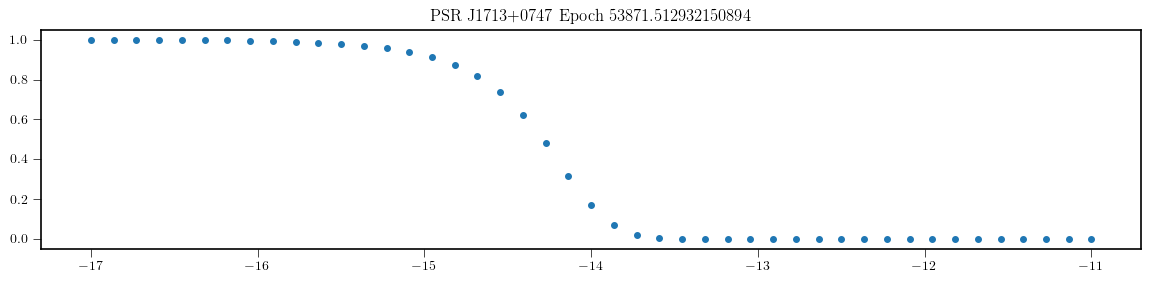

(45,)
(45,)
(45,)


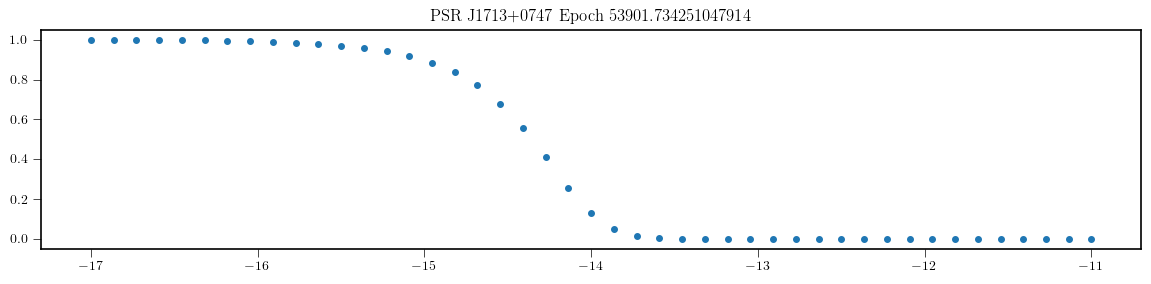

(45,)
(45,)
(45,)


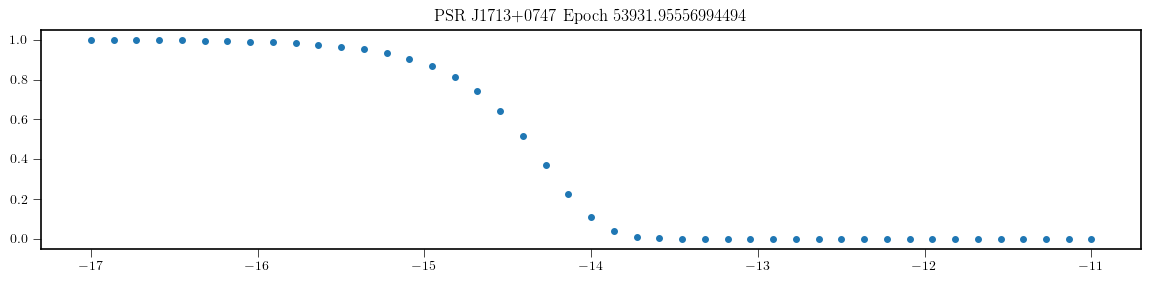

(45,)
(45,)
(45,)


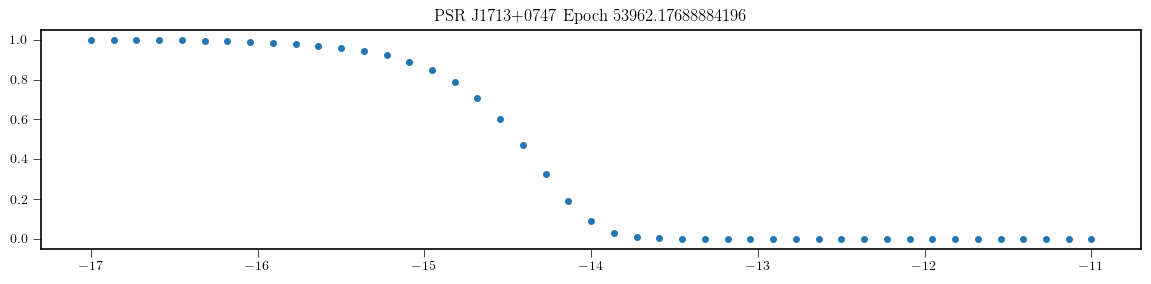

(45,)
(45,)
(45,)


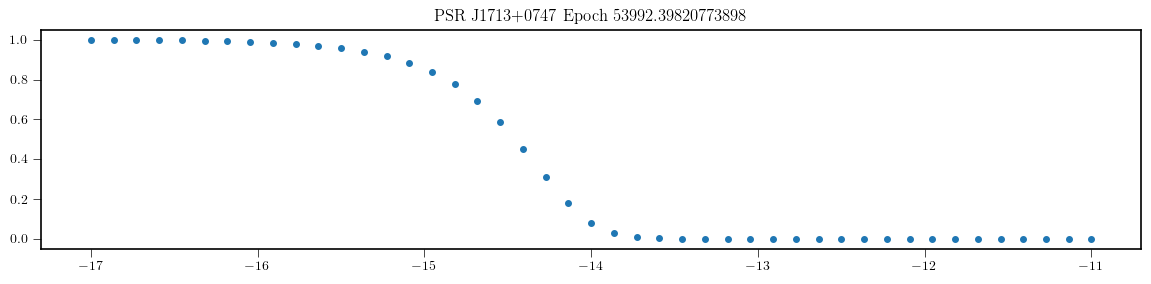

(45,)
(45,)
(45,)


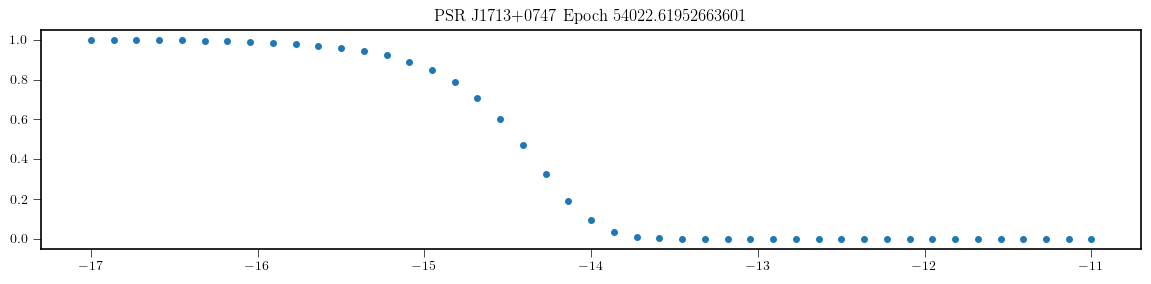

(45,)
(45,)
(45,)


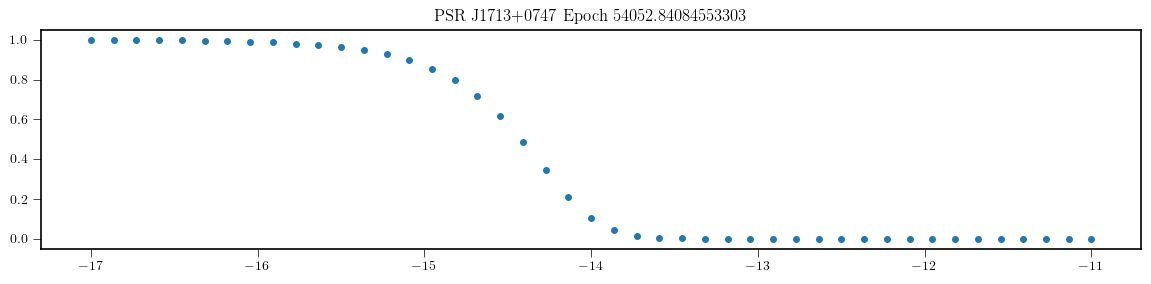

(45,)
(45,)
(45,)


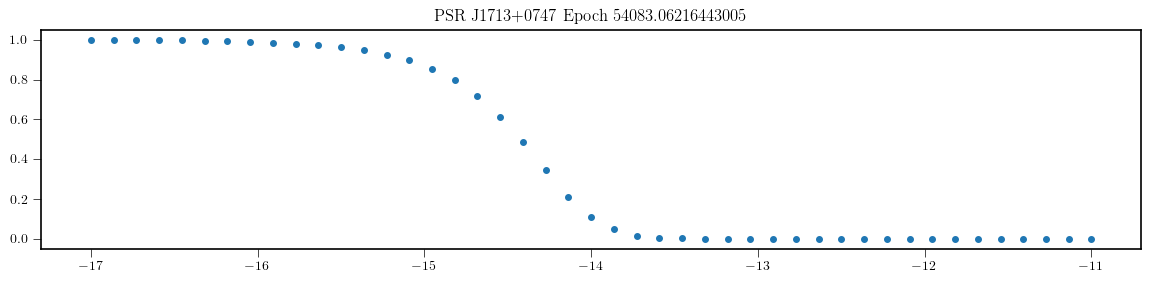

(45,)
(45,)
(45,)


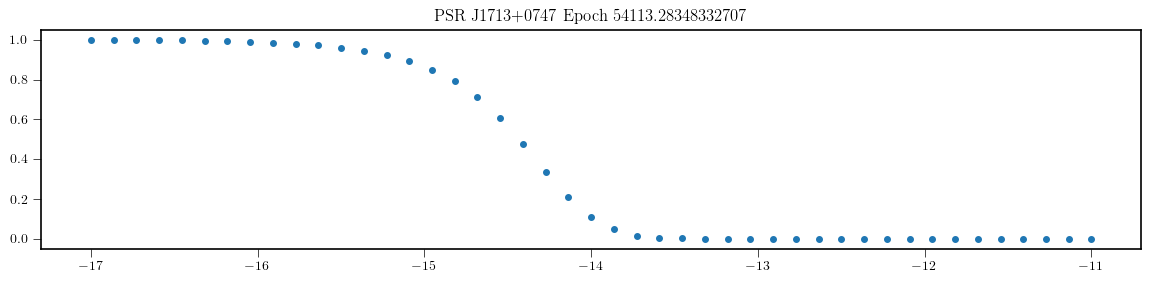

(45,)
(45,)
(45,)


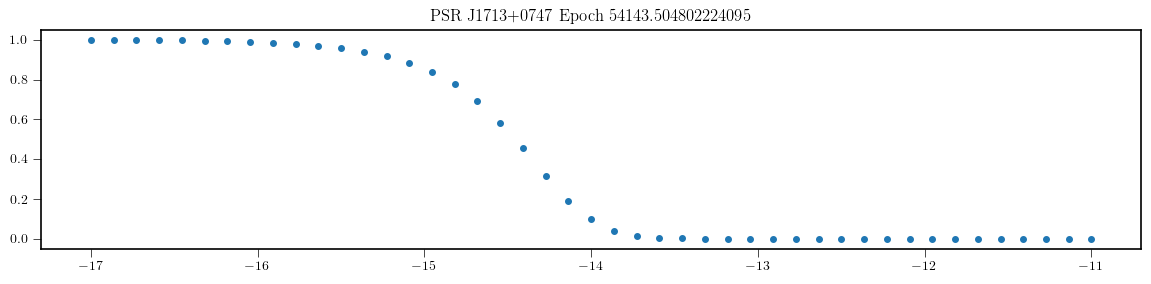

(45,)
(45,)
(45,)


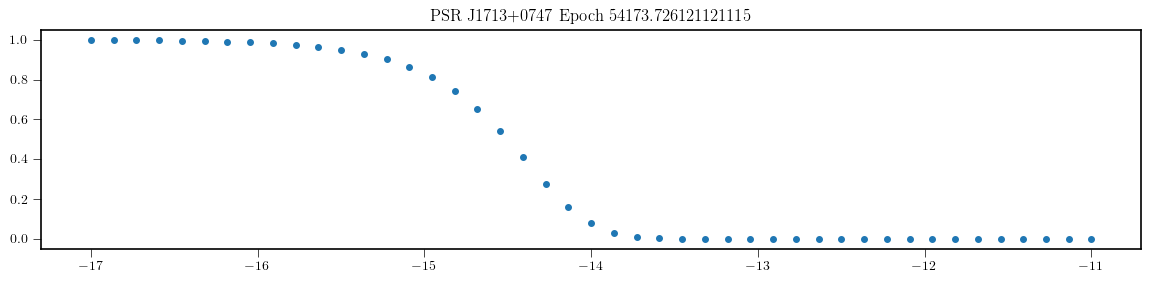

(45,)
(45,)
(45,)


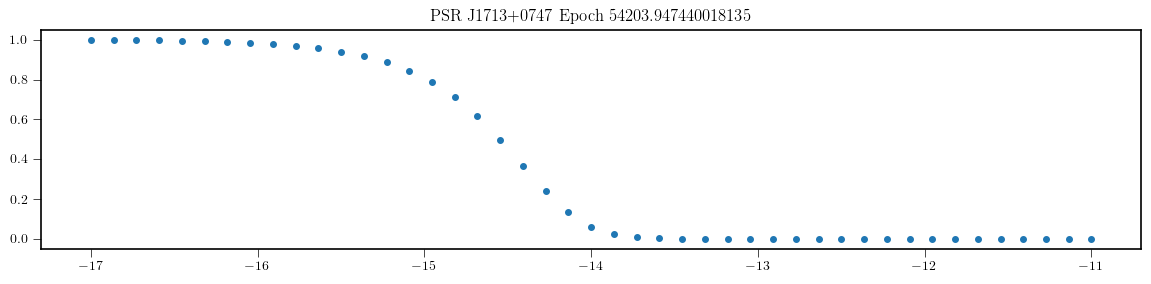

(45,)
(45,)
(45,)


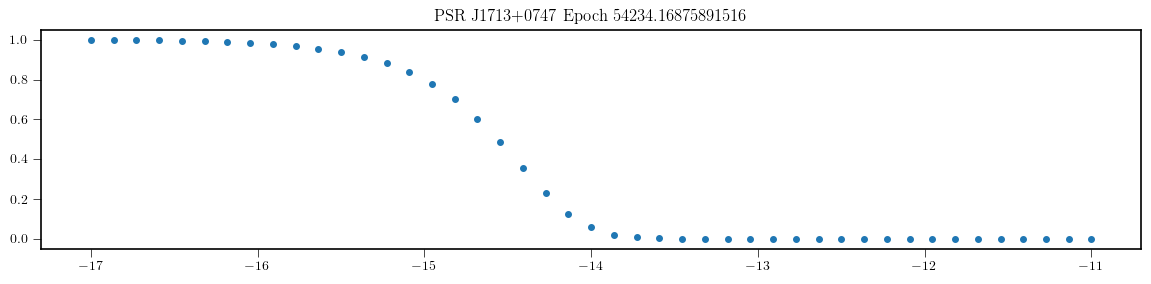

(45,)
(45,)
(45,)


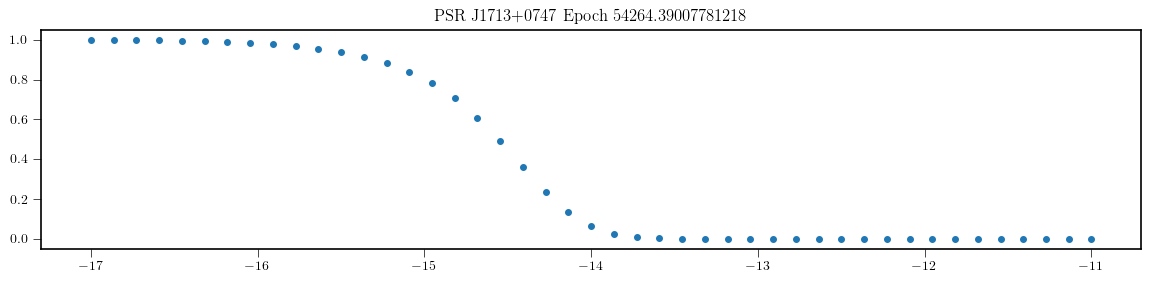

(45,)
(45,)
(45,)


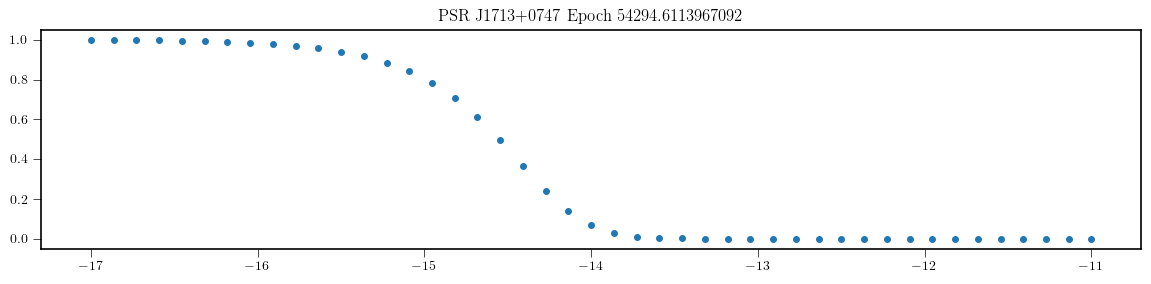

(45,)
(45,)
(45,)


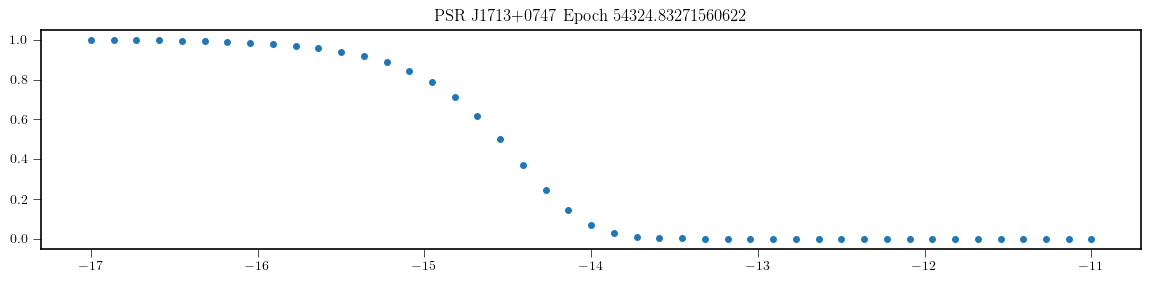

(45,)
(45,)
(45,)


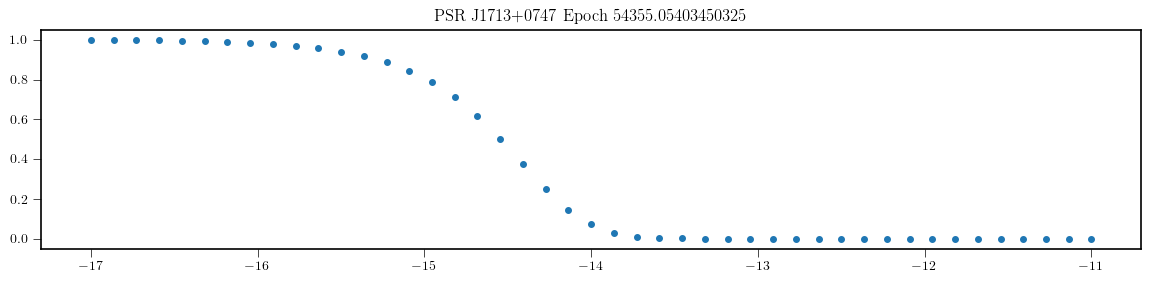

(45,)
(45,)
(45,)


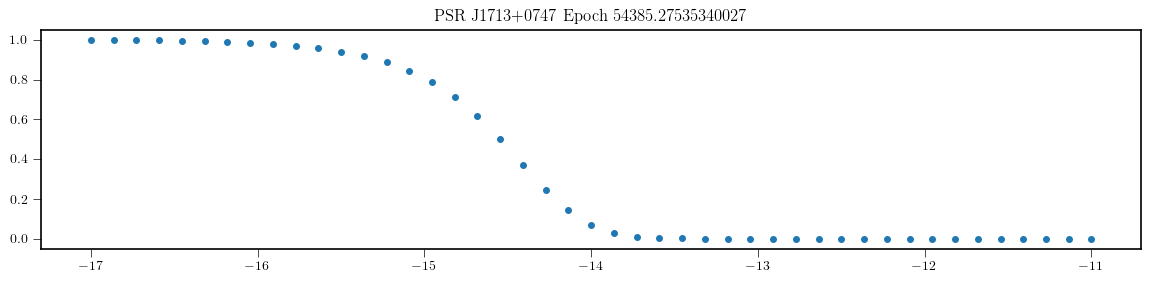

(45,)
(45,)
(45,)


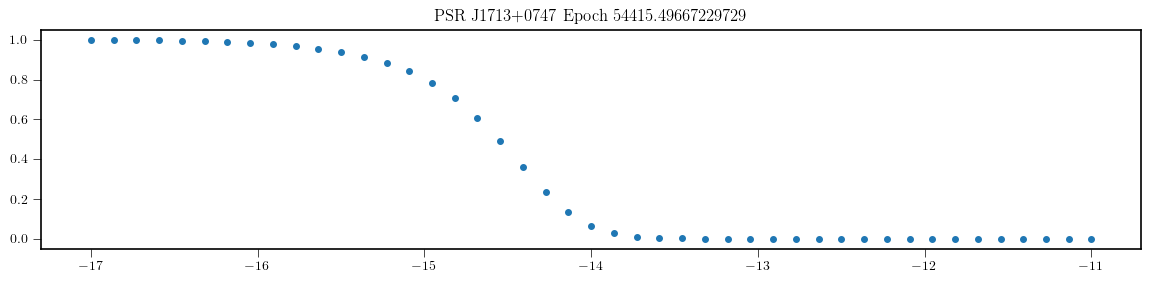

(45,)
(45,)
(45,)


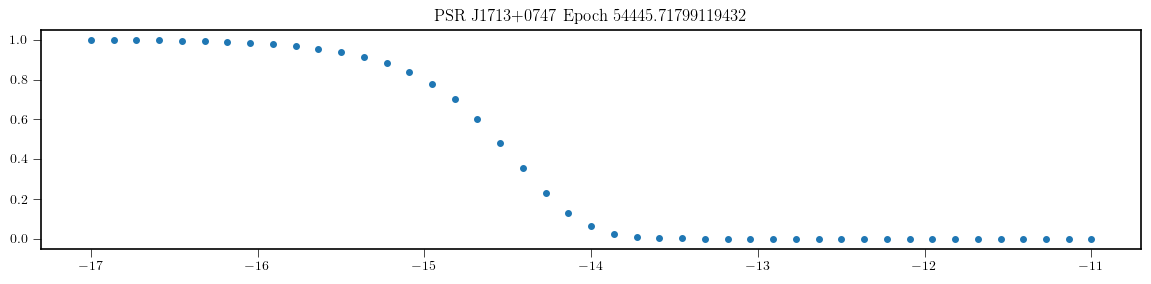

(45,)
(45,)
(45,)


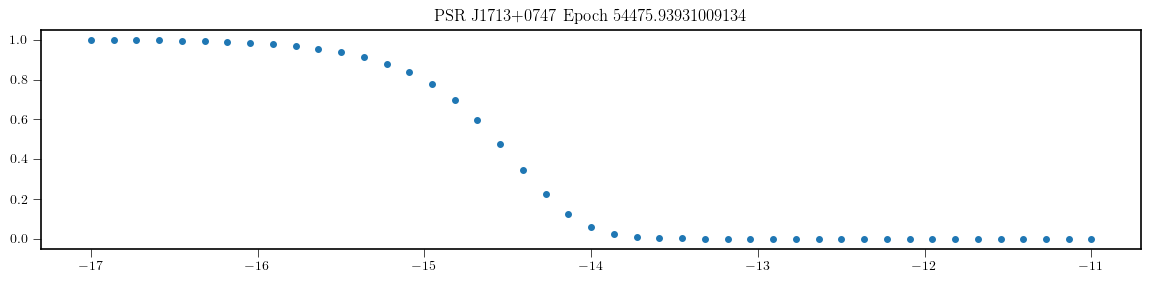

(45,)
(45,)
(45,)


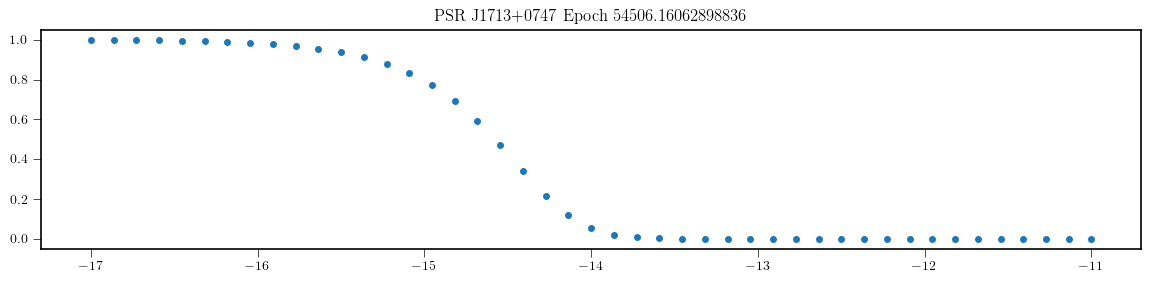

(45,)
(45,)
(45,)


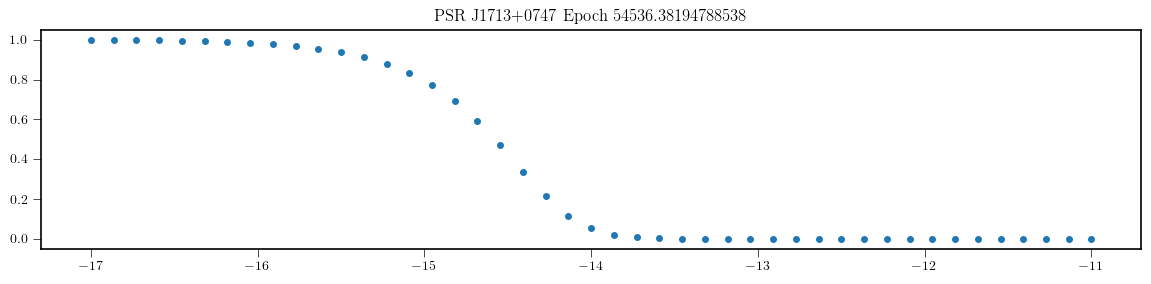

(45,)
(45,)
(45,)


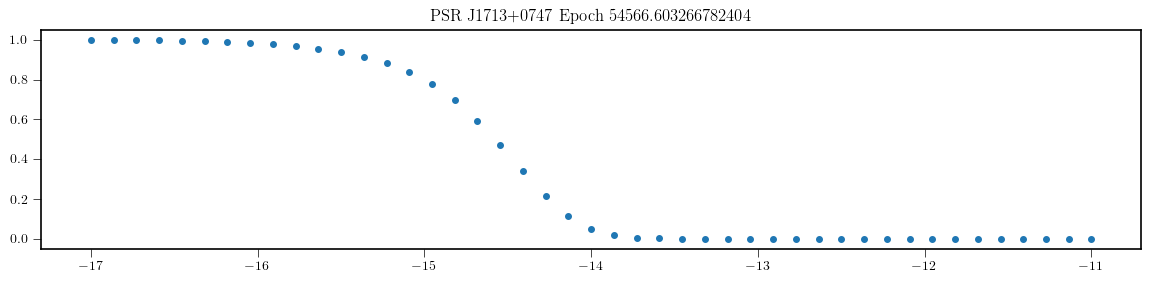

(45,)
(45,)
(45,)


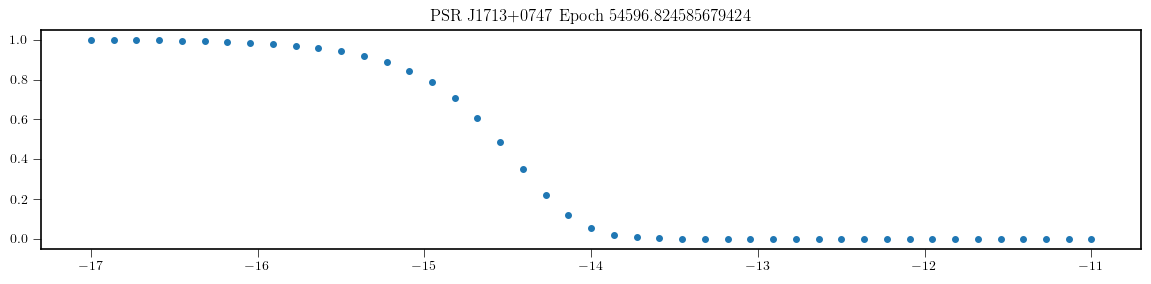

(45,)
(45,)
(45,)


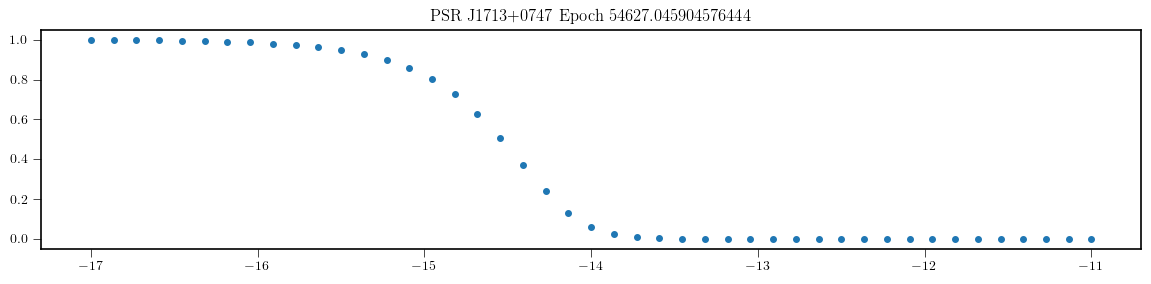

(45,)
(45,)
(45,)


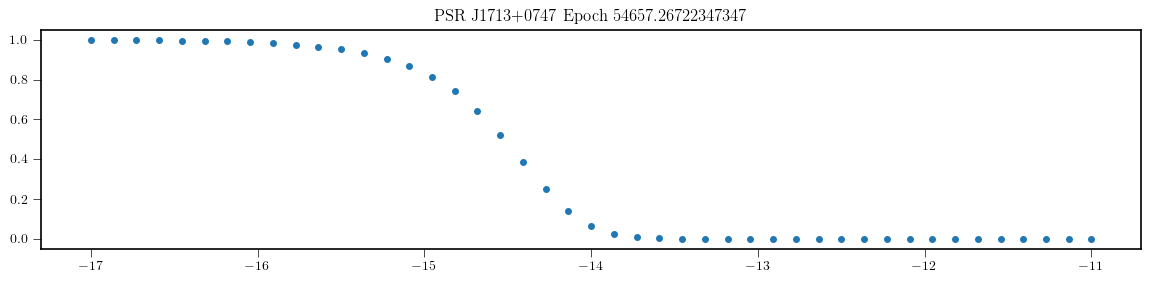

(45,)
(45,)
(45,)


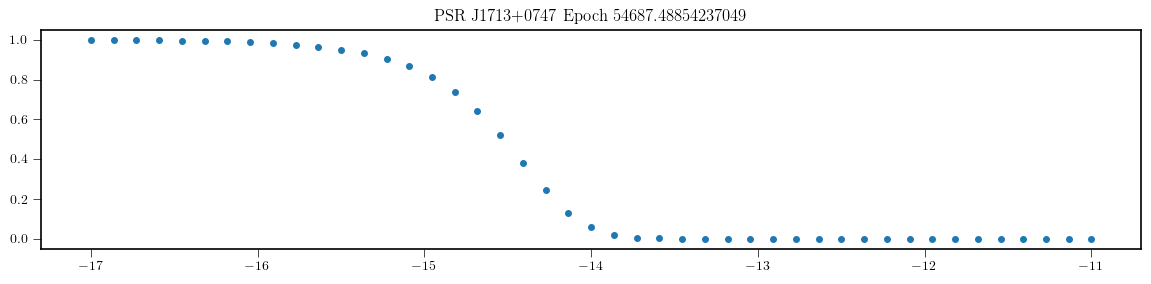

(45,)
(45,)
(45,)


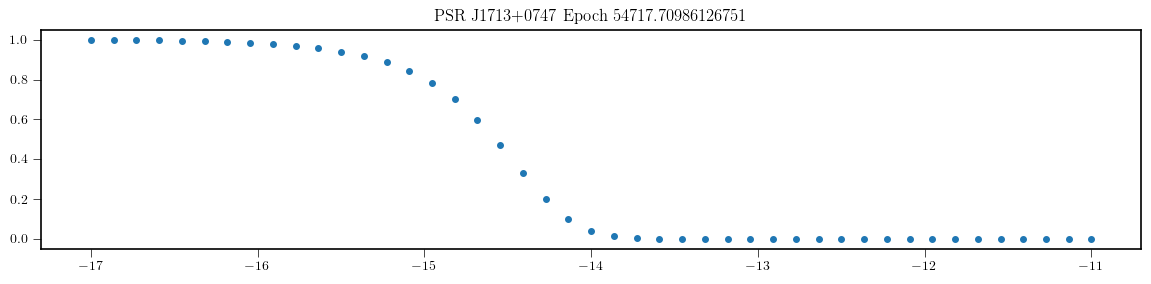

(45,)
(45,)
(45,)


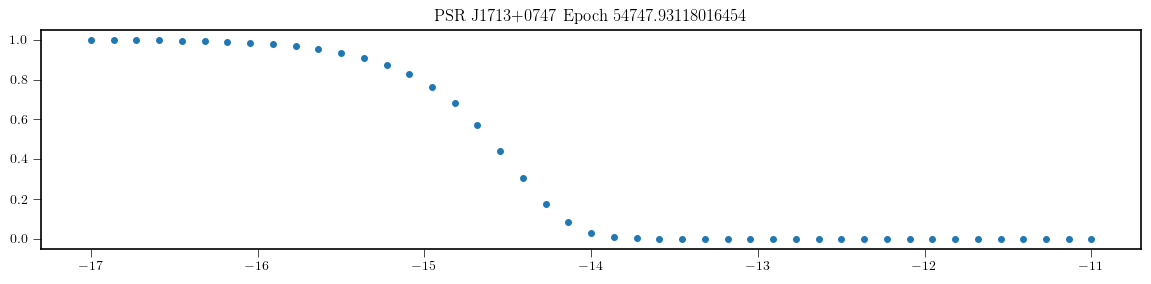

(45,)
(45,)
(45,)


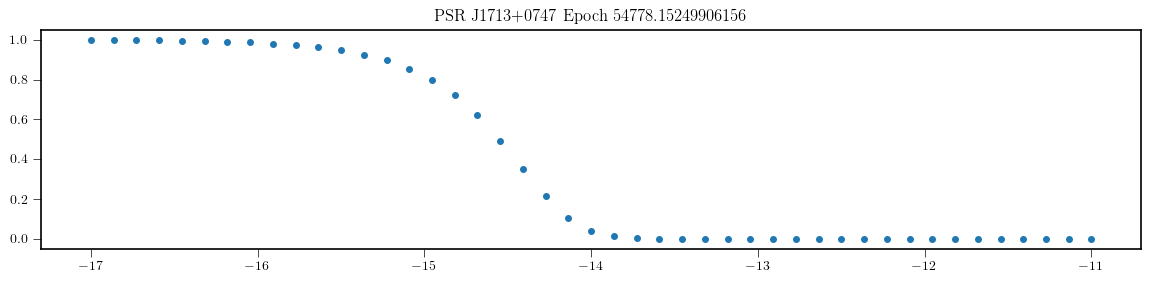

(45,)
(45,)
(45,)


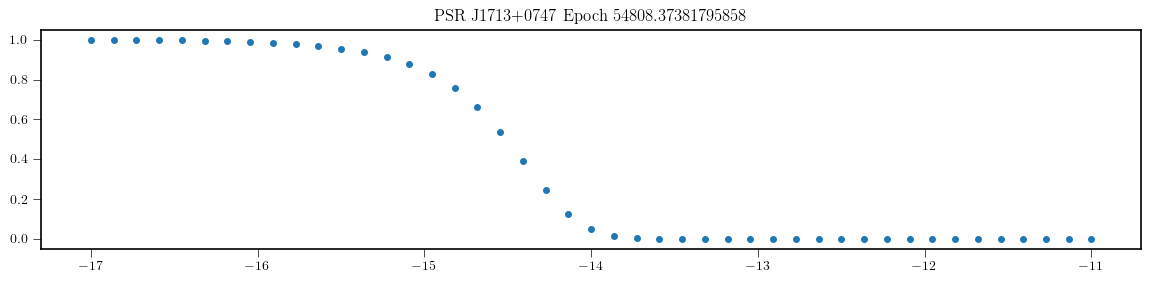

(45,)
(45,)
(45,)


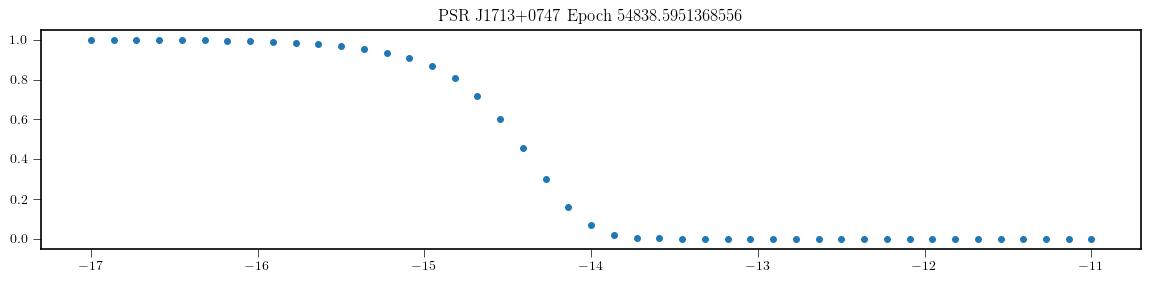

(45,)
(45,)
(45,)


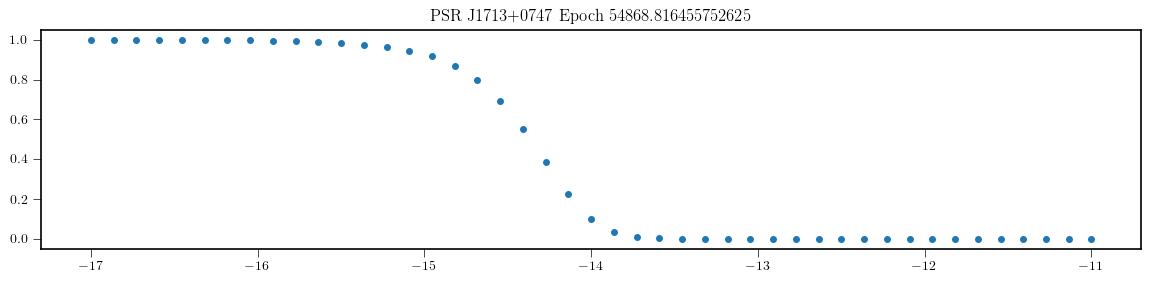

(45,)
(45,)
(45,)


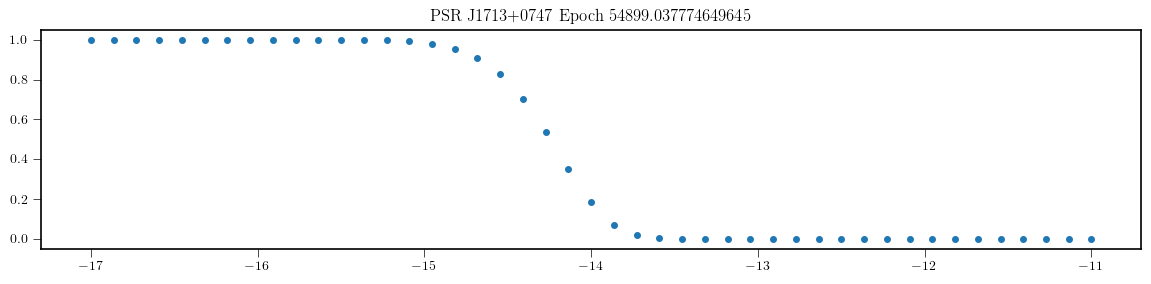

(45,)
(45,)
(45,)


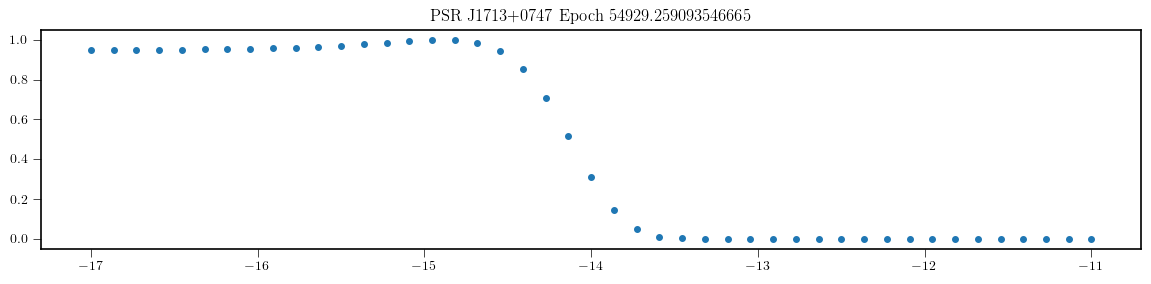

(45,)
(45,)
(45,)


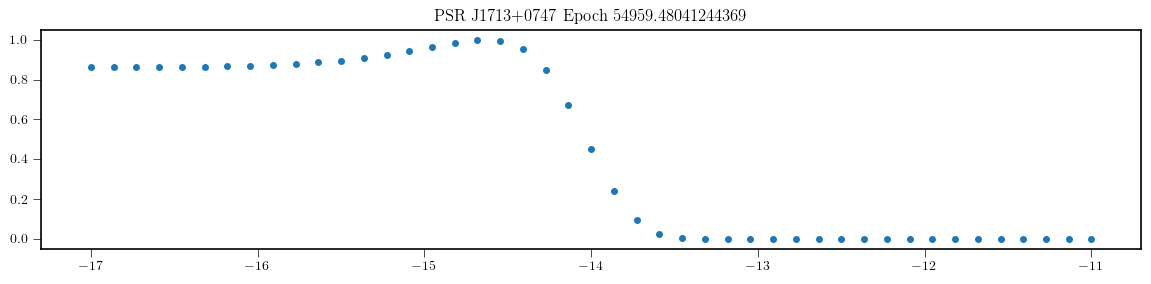

(45,)
(45,)
(45,)


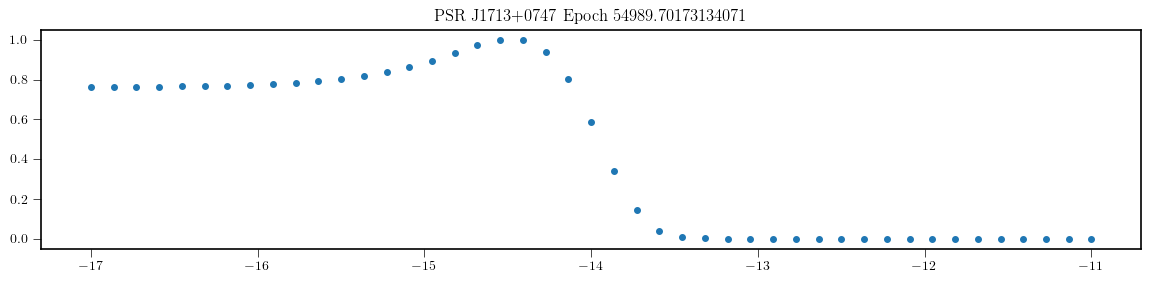

(45,)
(45,)
(45,)


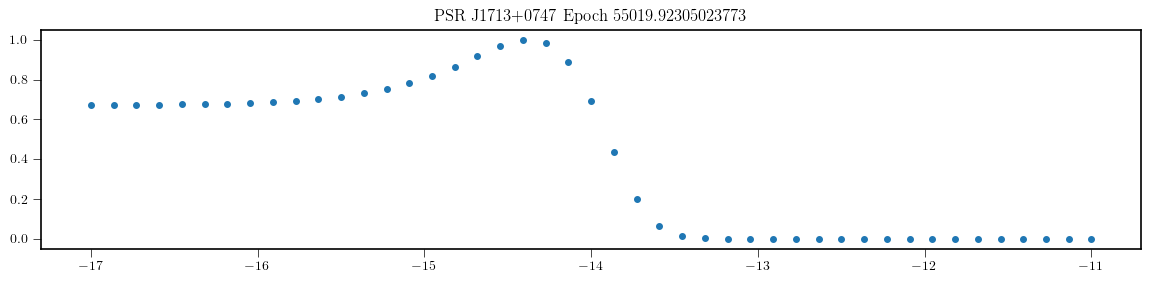

(45,)
(45,)
(45,)


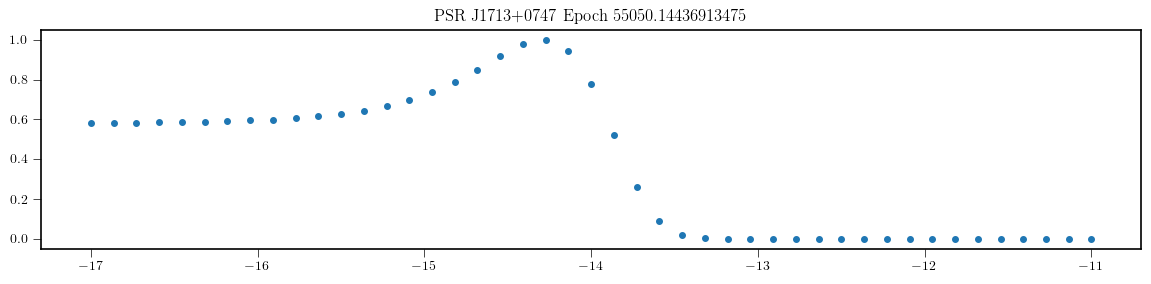

(45,)
(45,)
(45,)


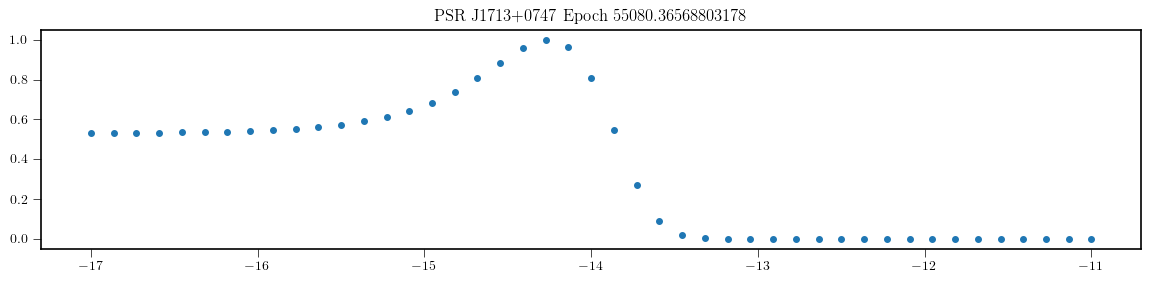

(45,)
(45,)
(45,)


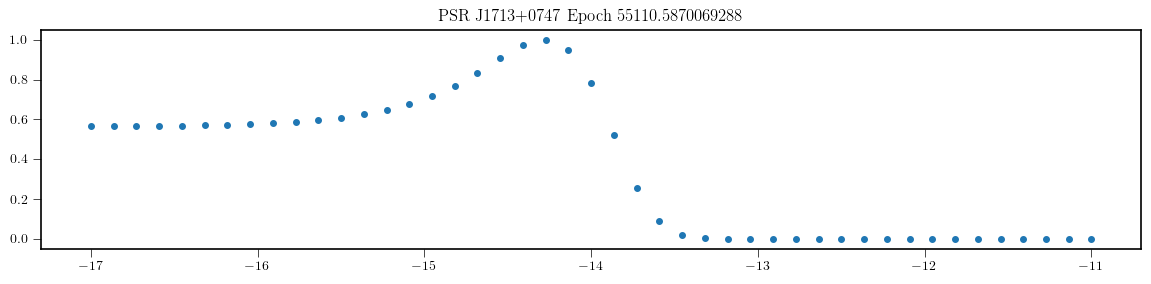

(45,)
(45,)
(45,)


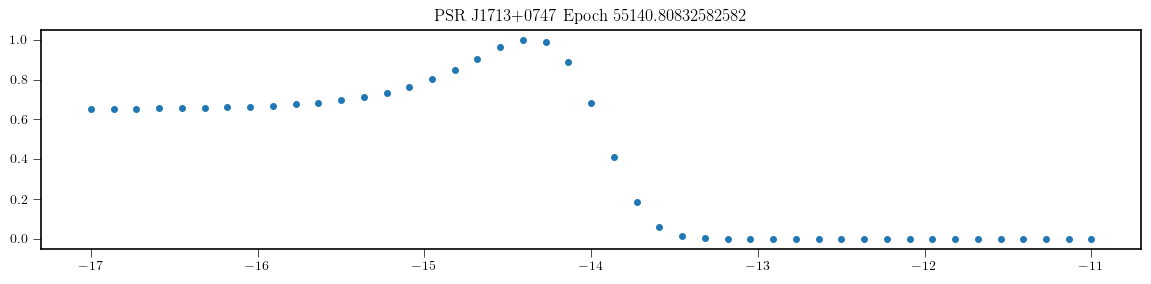

(45,)
(45,)
(45,)


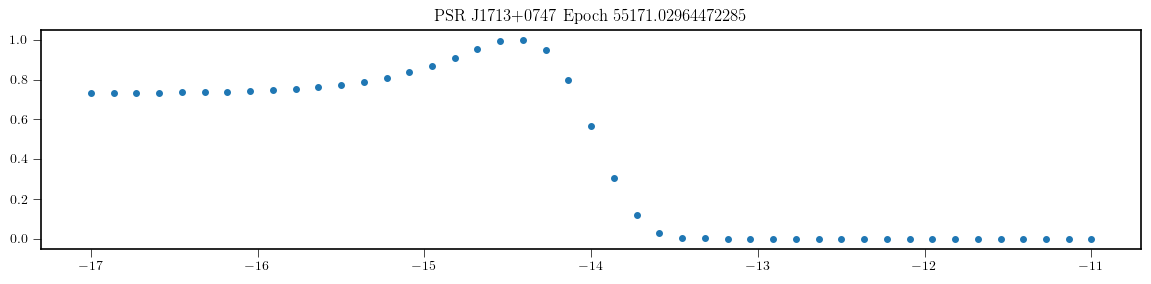

(45,)
(45,)
(45,)


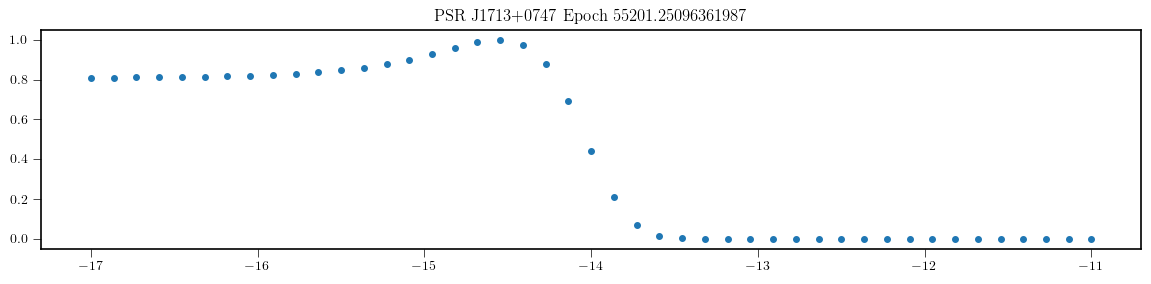

(45,)
(45,)
(45,)


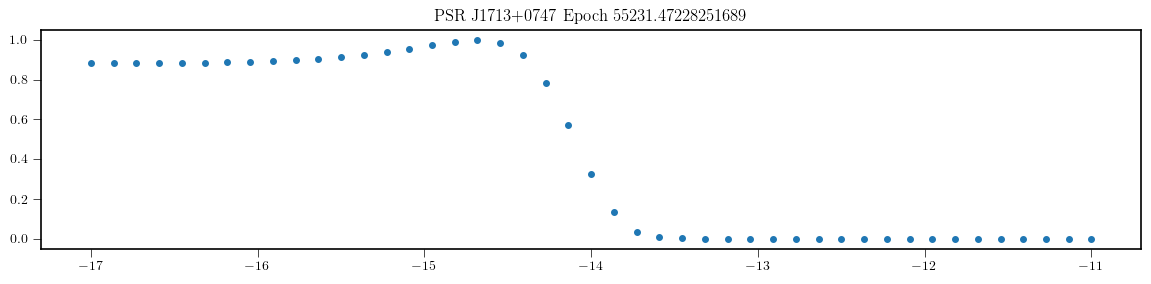

(45,)
(45,)
(45,)


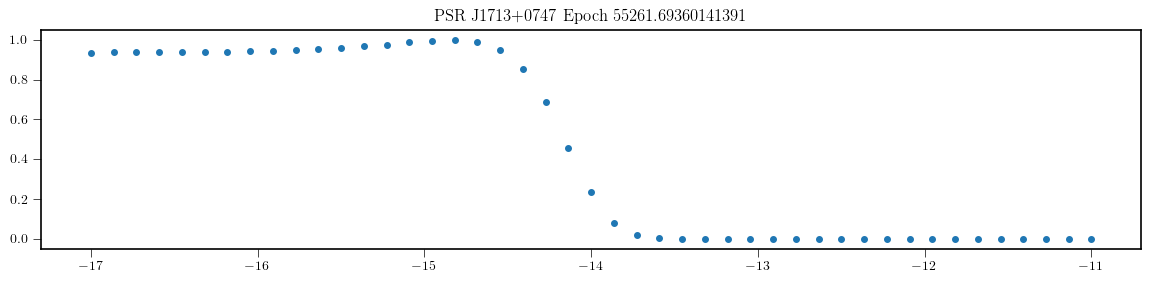

(45,)
(45,)
(45,)


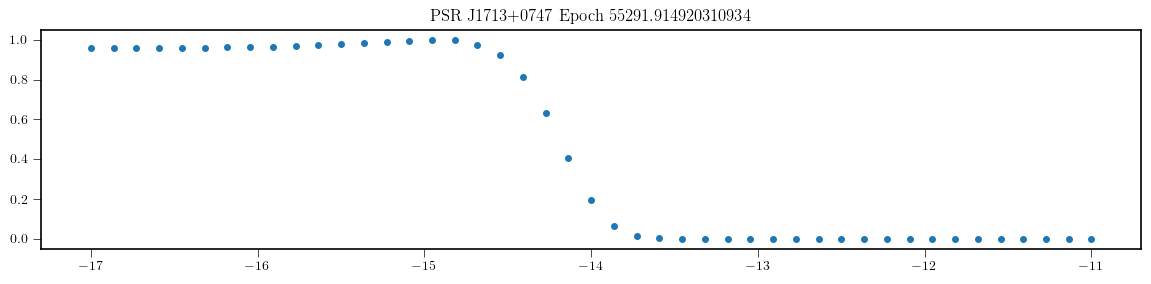

(45,)
(45,)
(45,)


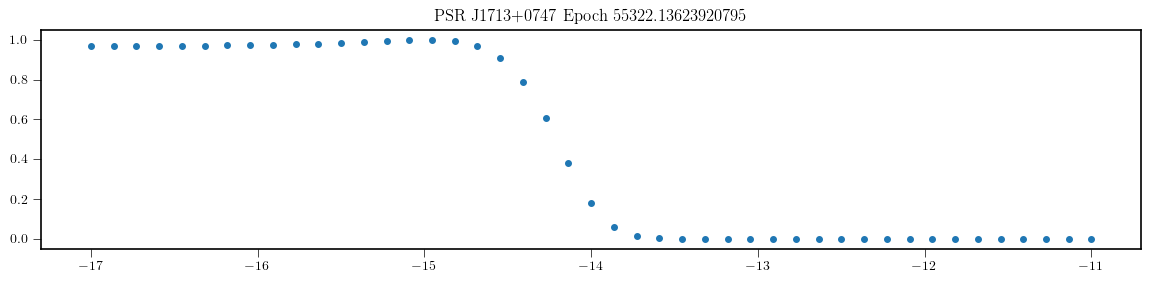

(45,)
(45,)
(45,)


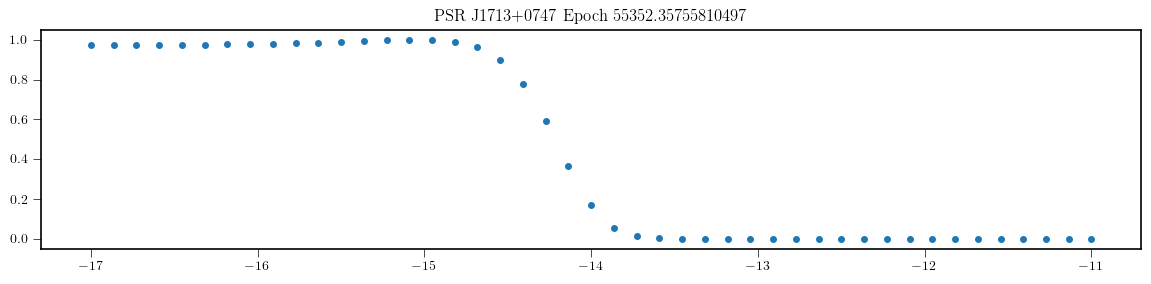

(45,)
(45,)
(45,)


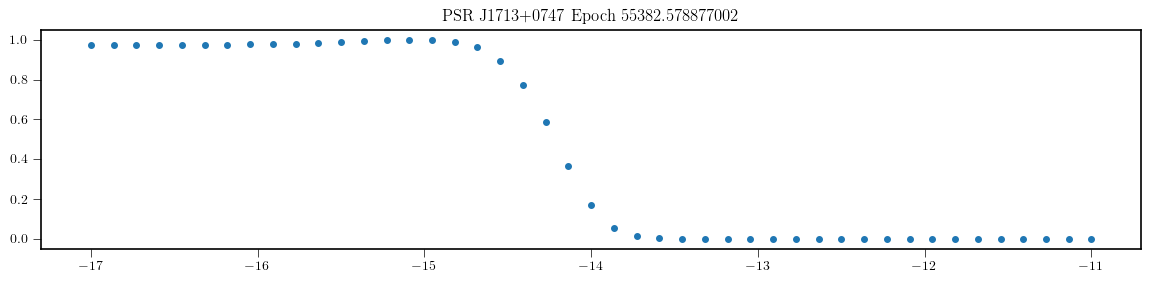

(45,)
(45,)
(45,)


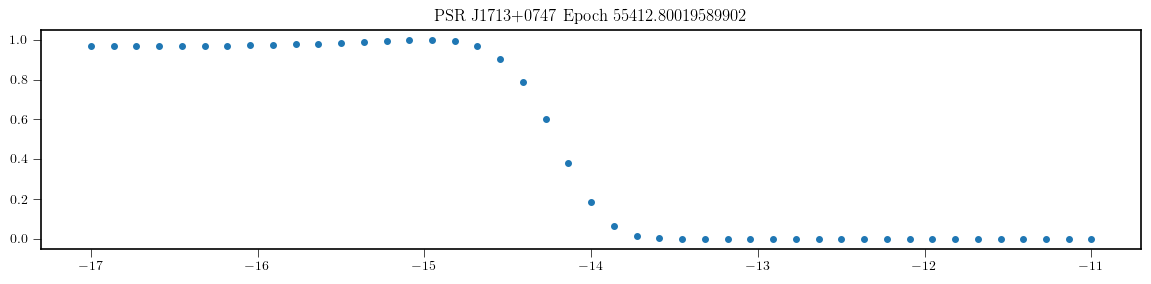

(45,)
(45,)
(45,)


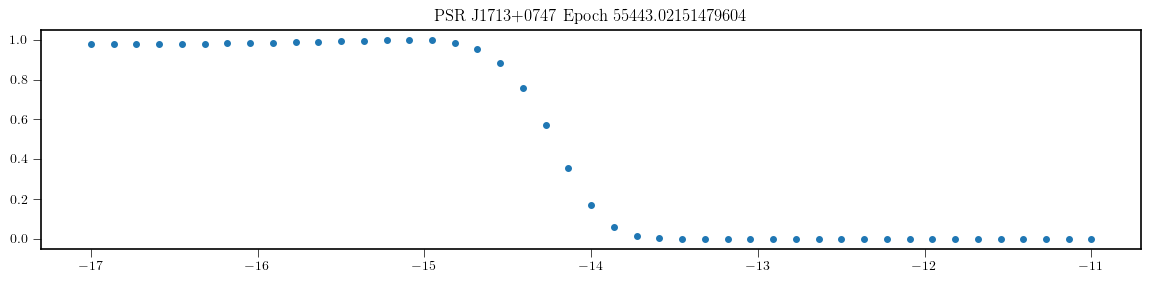

(45,)
(45,)
(45,)


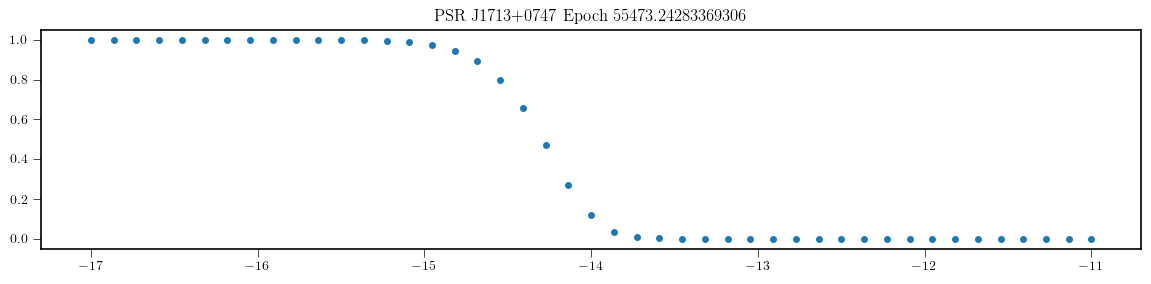

(45,)
(45,)
(45,)


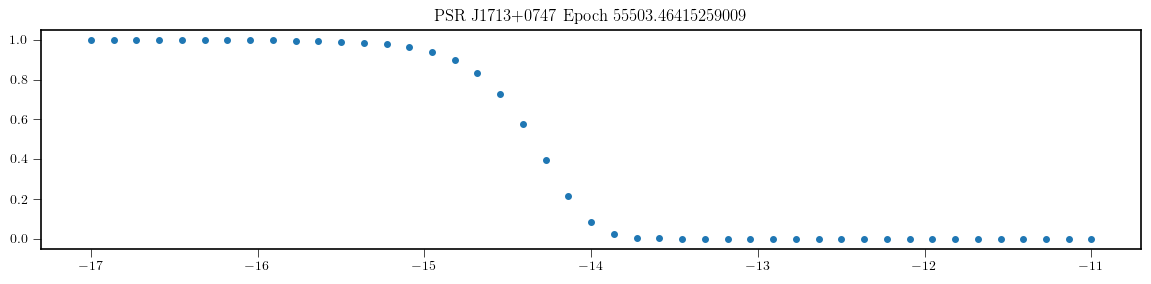

(45,)
(45,)
(45,)


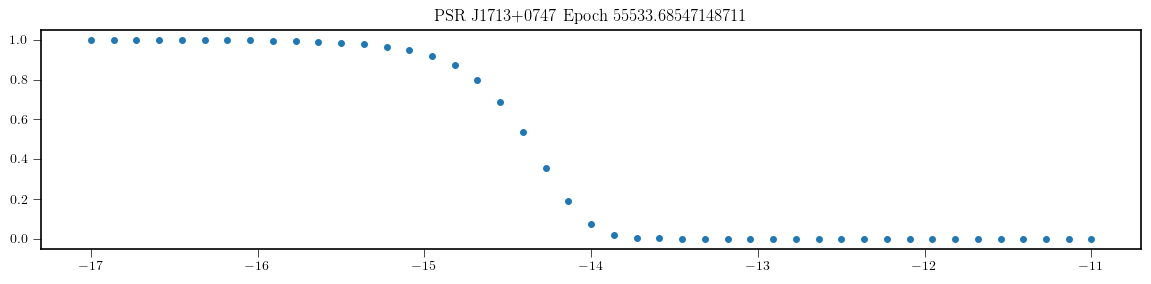

(45,)
(45,)
(45,)


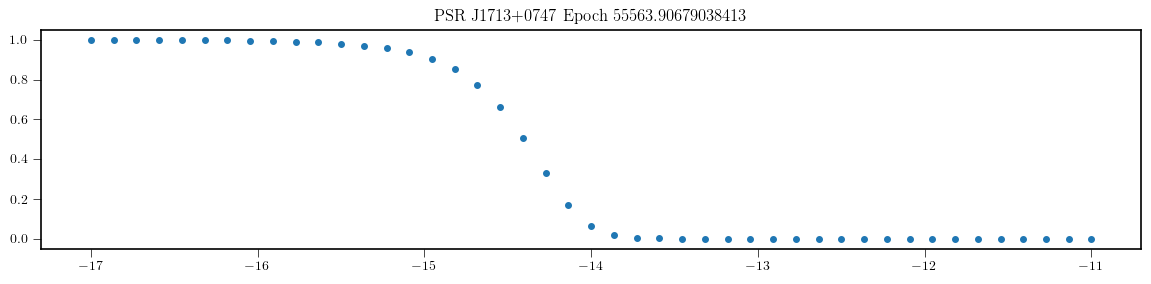

(45,)
(45,)
(45,)


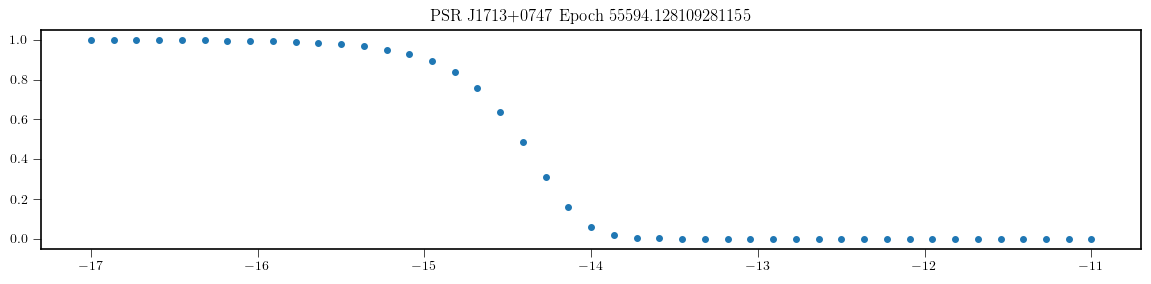

(45,)
(45,)
(45,)


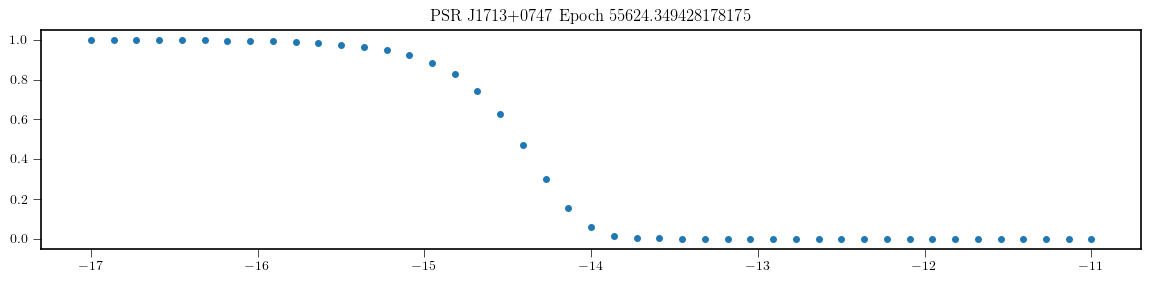

(45,)
(45,)
(45,)


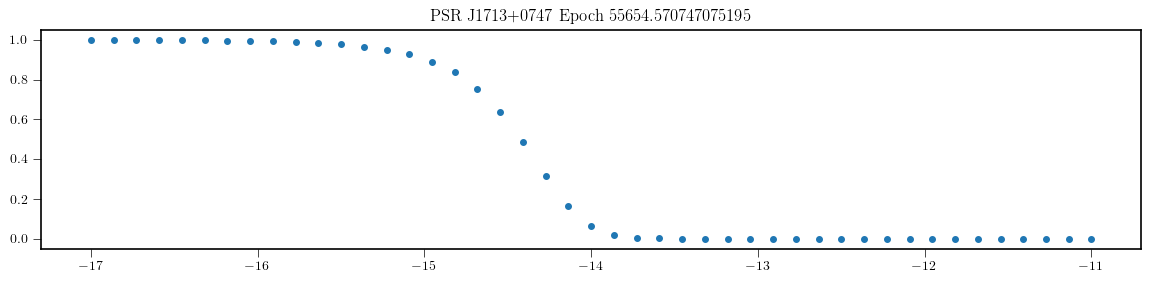

(45,)
(45,)
(45,)


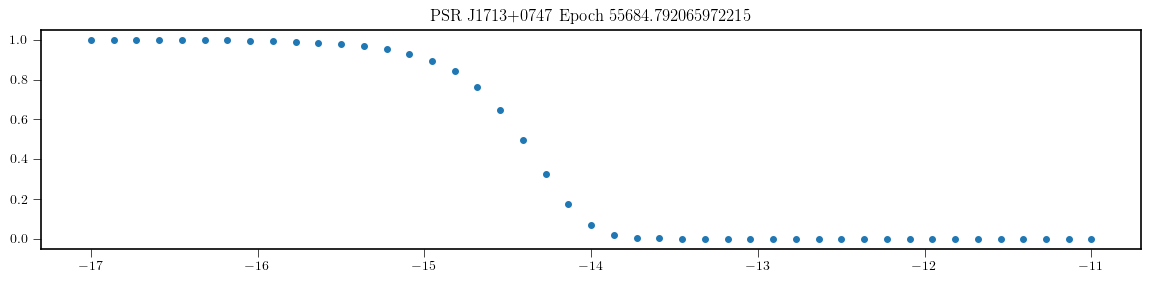

(45,)
(45,)
(45,)


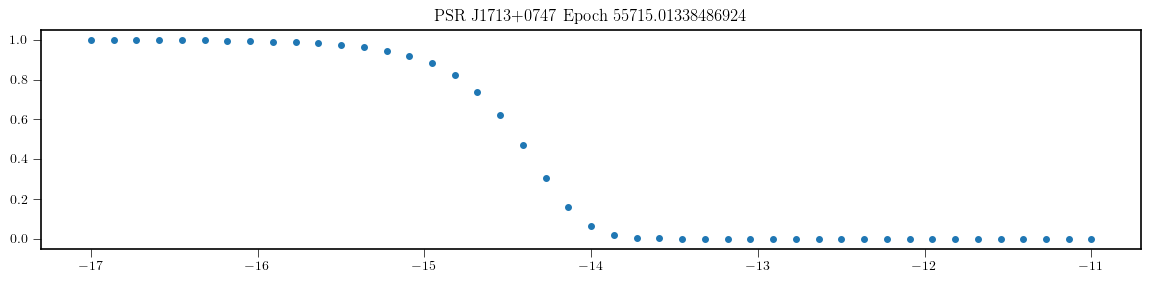

(45,)
(45,)
(45,)


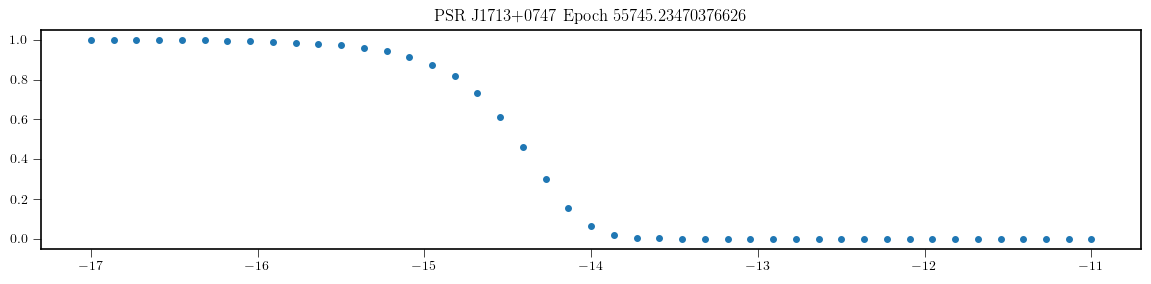

(45,)
(45,)
(45,)


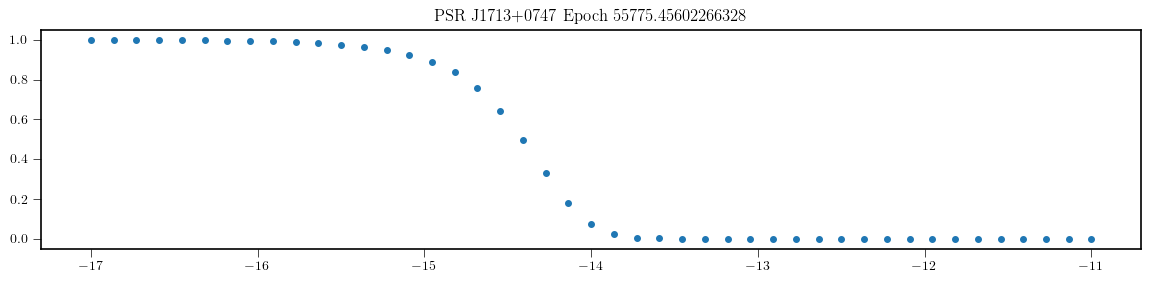

(45,)
(45,)
(45,)


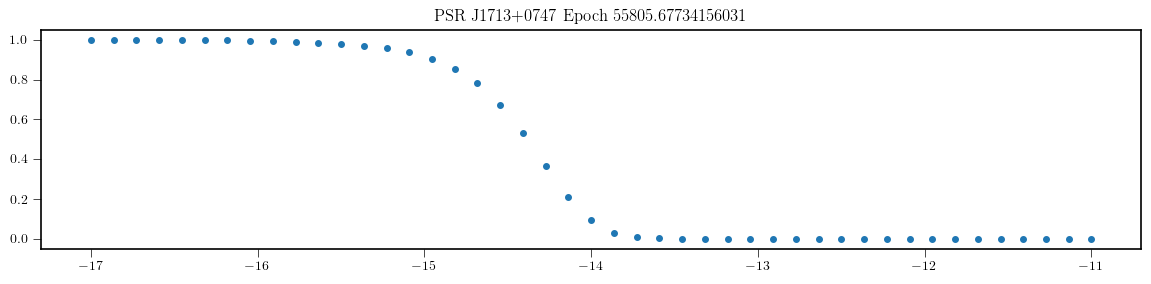

(45,)
(45,)
(45,)


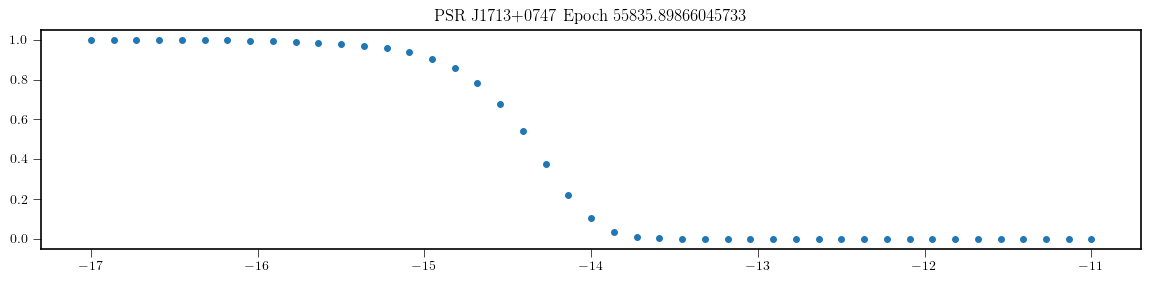

(45,)
(45,)
(45,)


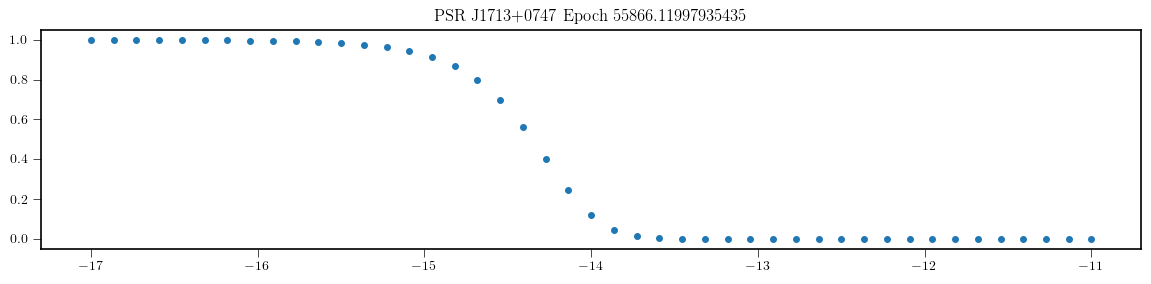

(45,)
(45,)
(45,)


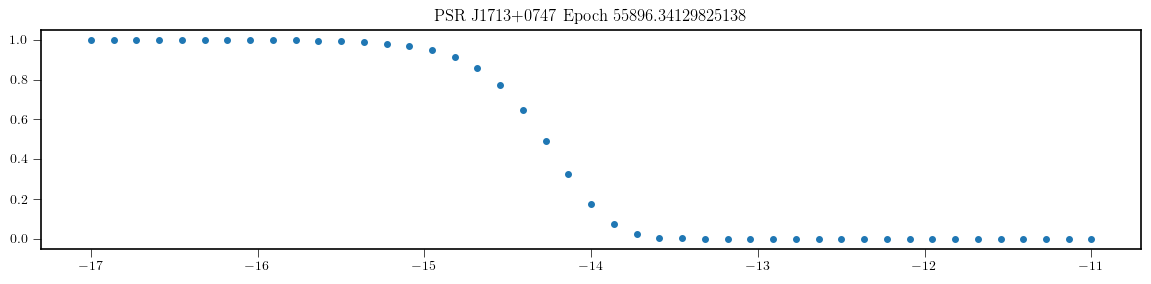

(45,)
(45,)
(45,)


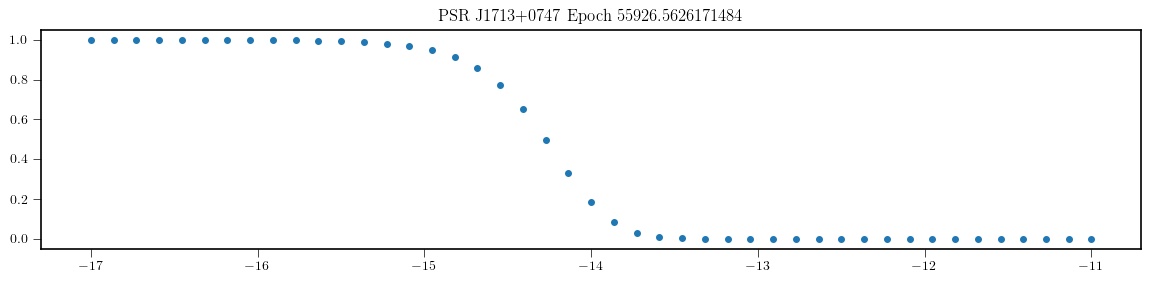

(45,)
(45,)
(45,)


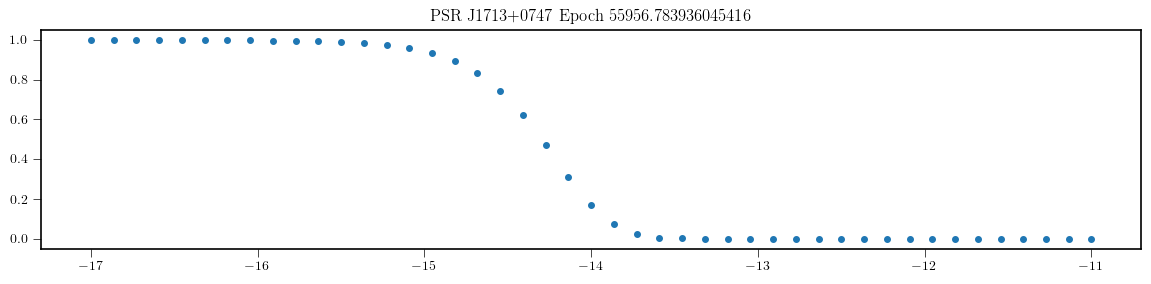

(45,)
(45,)
(45,)


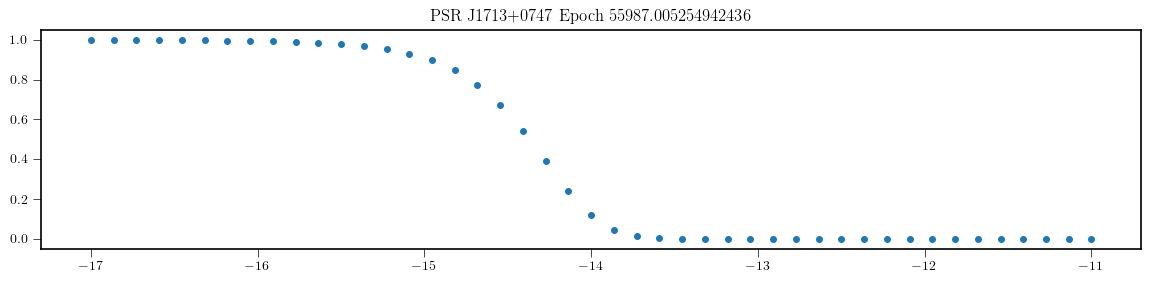

(45,)
(45,)
(45,)


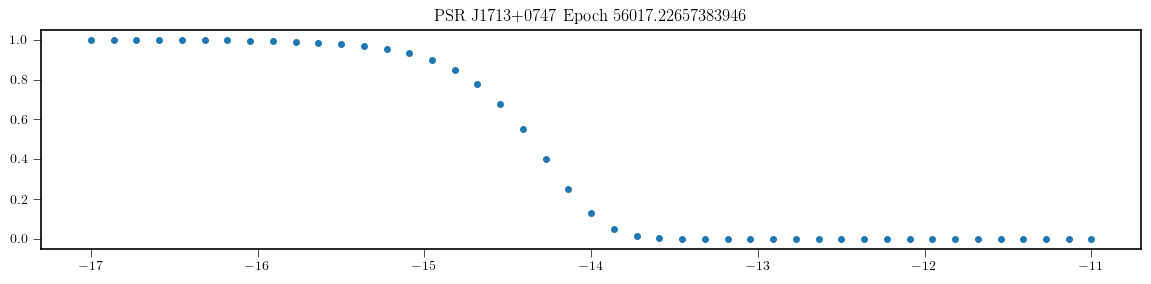

(45,)
(45,)
(45,)


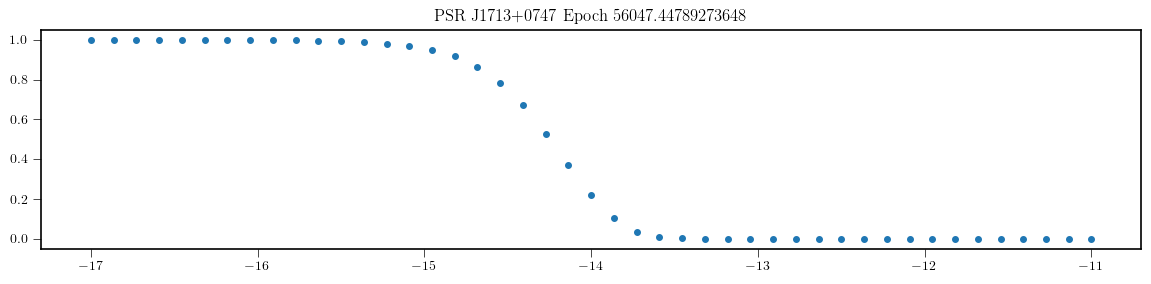

(45,)
(45,)
(45,)


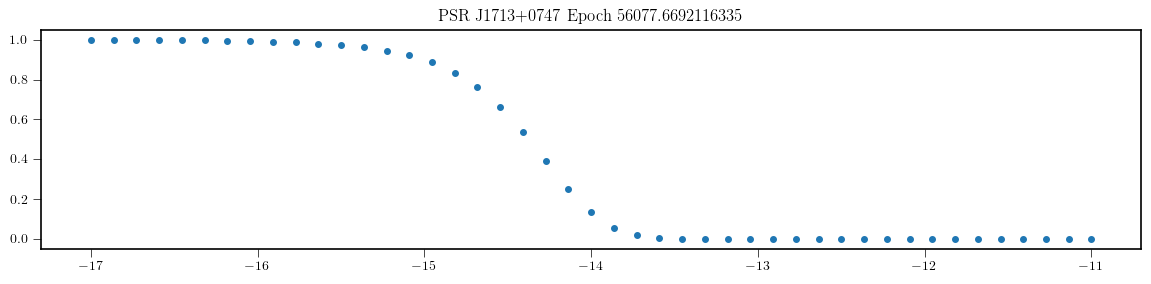

(45,)
(45,)
(45,)


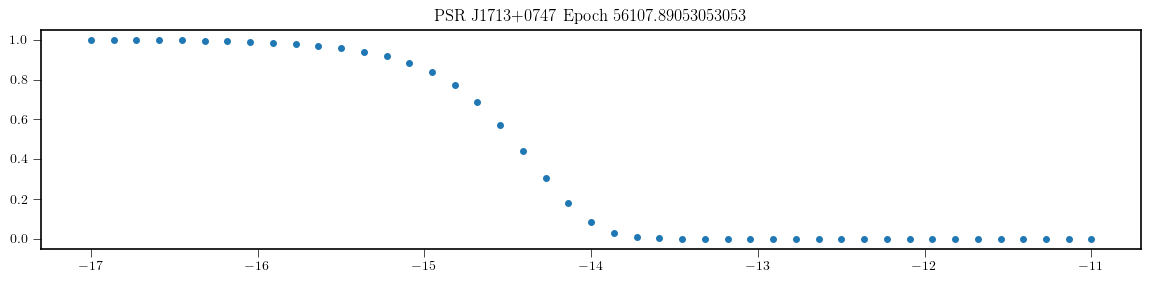

(45,)
(45,)
(45,)


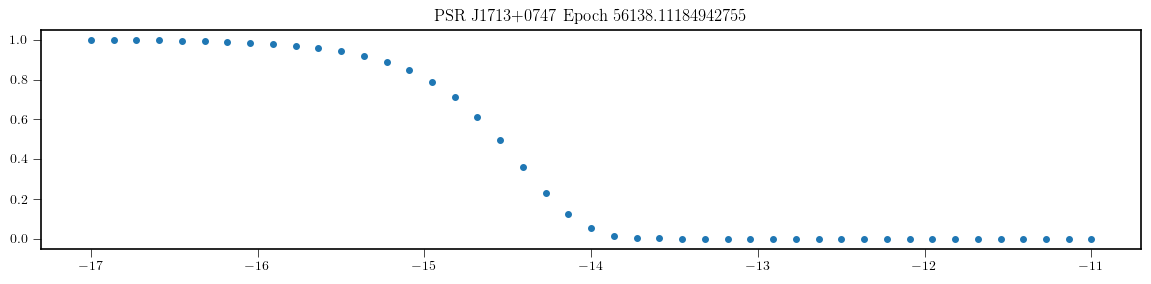

(45,)
(45,)
(45,)


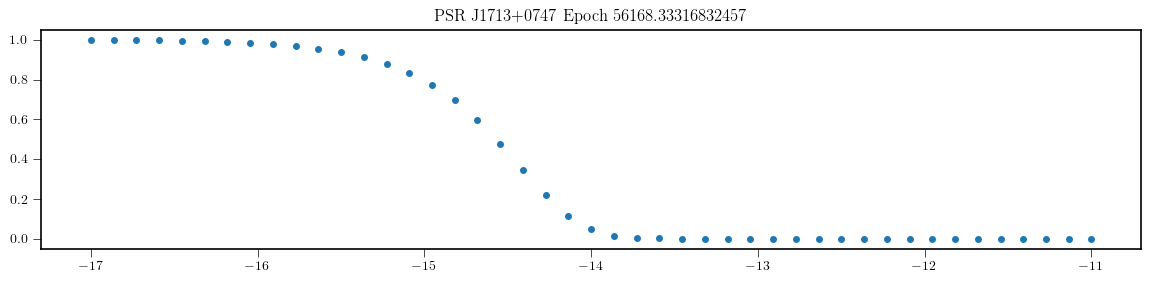

(45,)
(45,)
(45,)


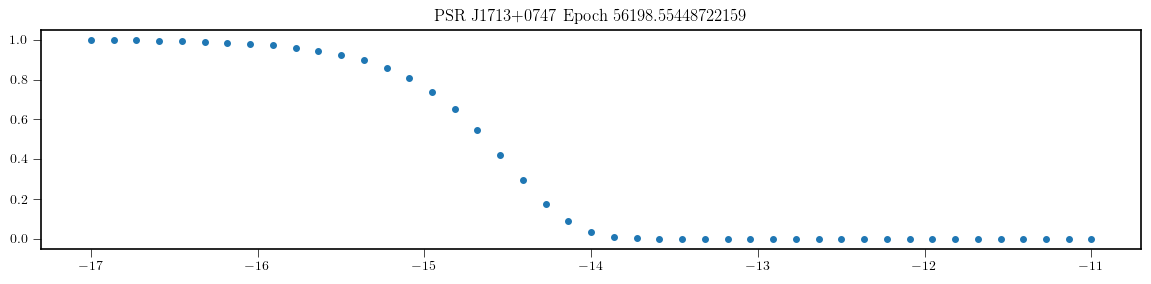

(45,)
(45,)
(45,)


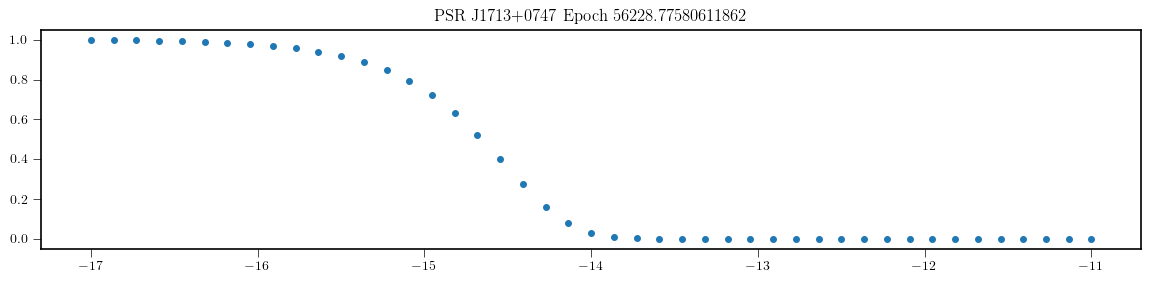

(45,)
(45,)
(45,)


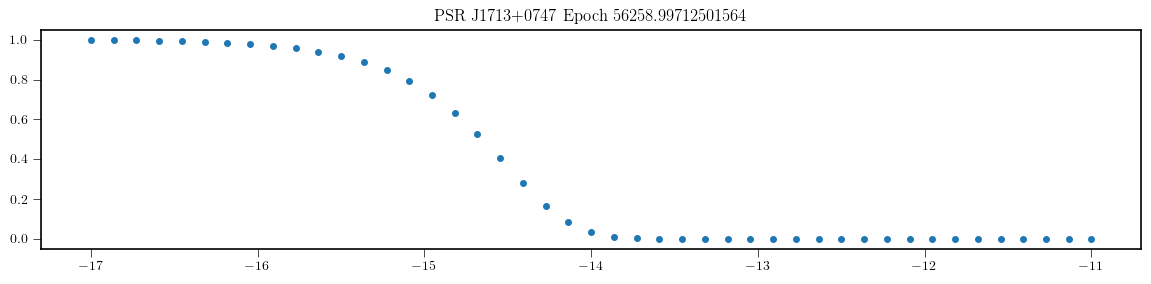

(45,)
(45,)
(45,)


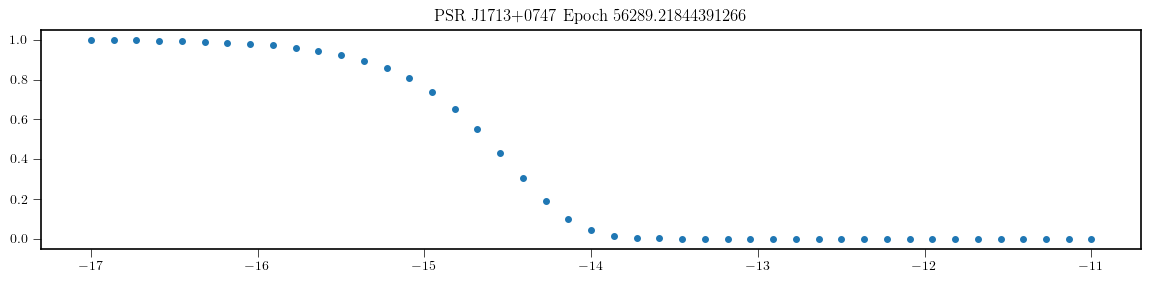

(45,)
(45,)
(45,)


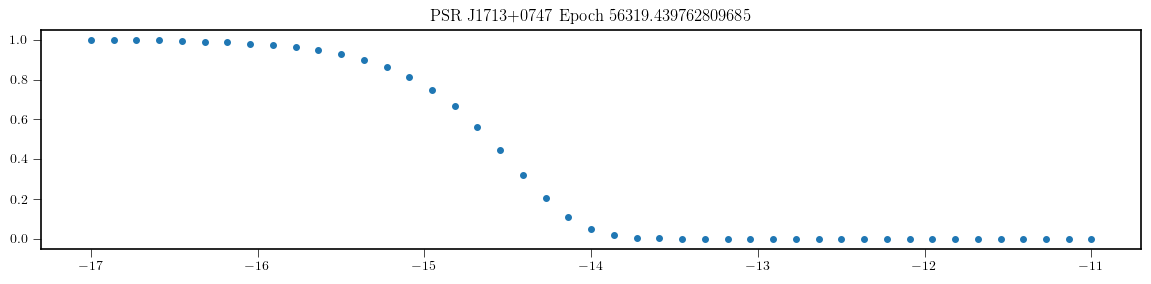

(45,)
(45,)
(45,)


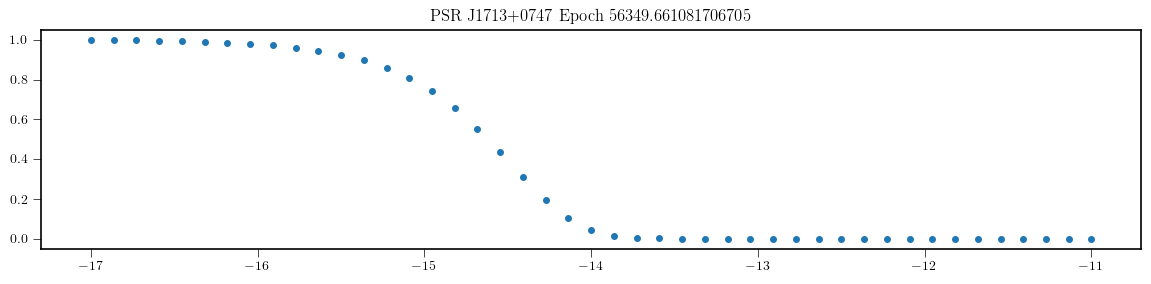

(45,)
(45,)
(45,)


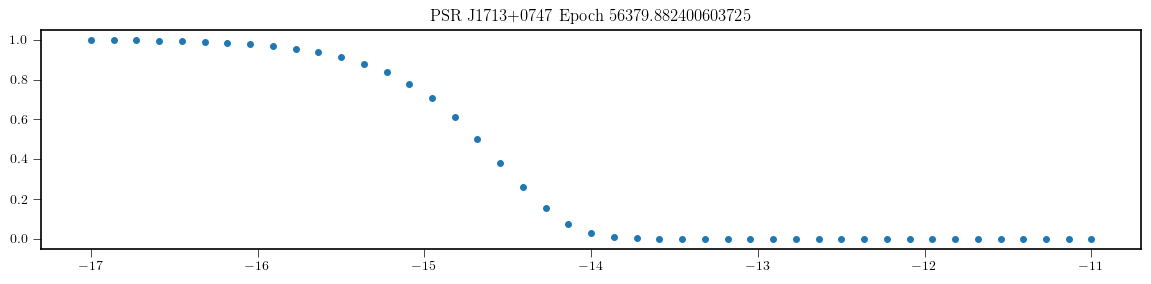

(45,)
(45,)
(45,)


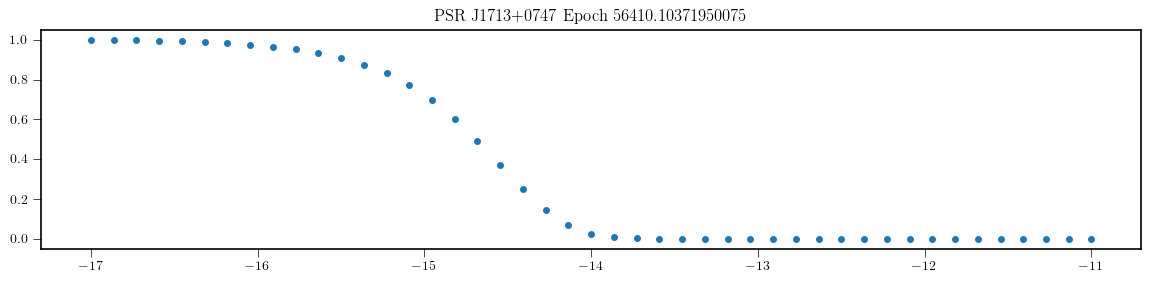

(45,)
(45,)
(45,)


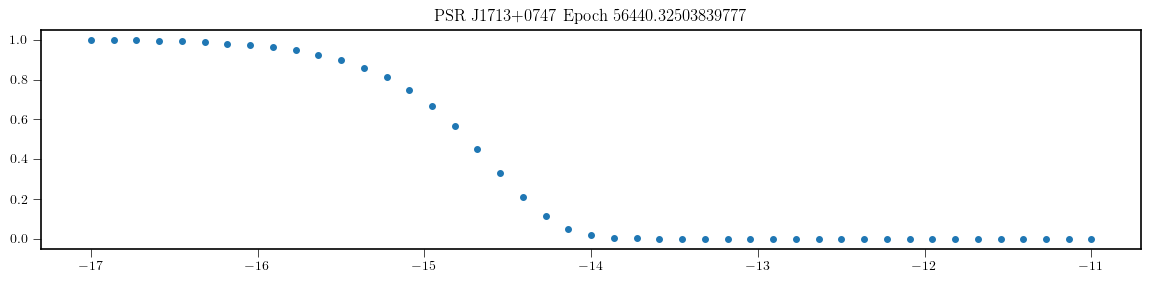

(45,)
(45,)
(45,)


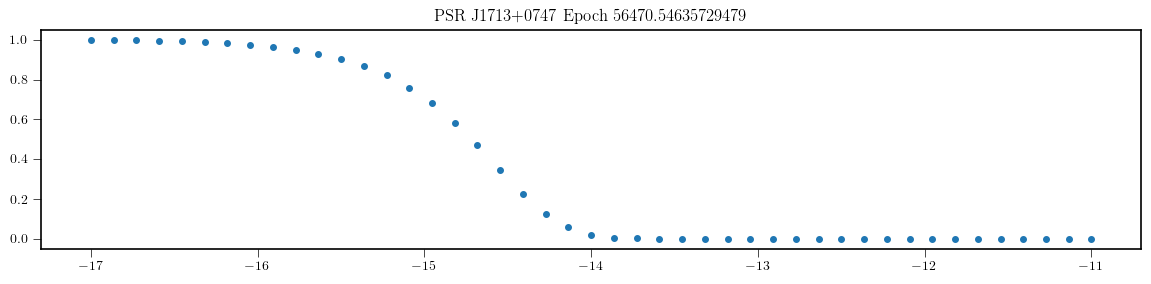

(45,)
(45,)
(45,)


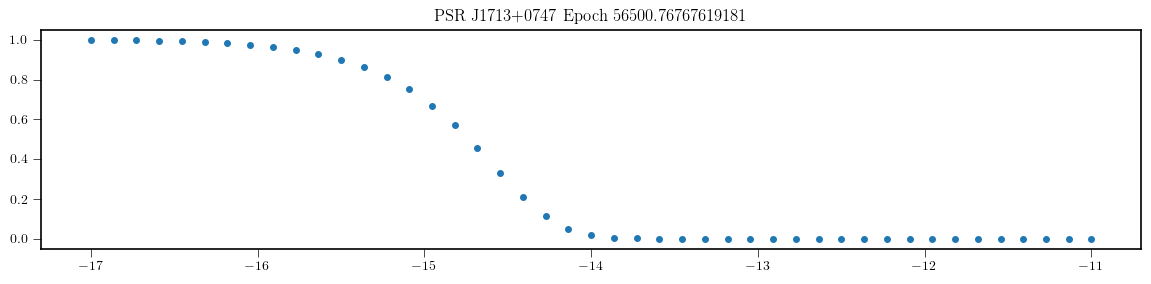

(45,)
(45,)
(45,)


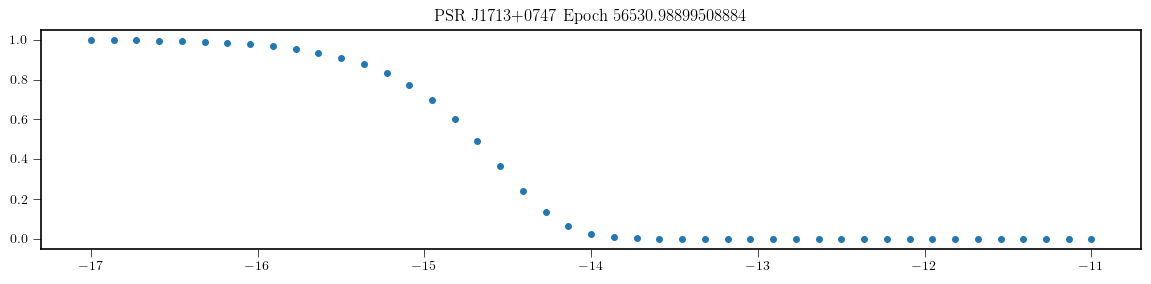

(45,)
(45,)
(45,)


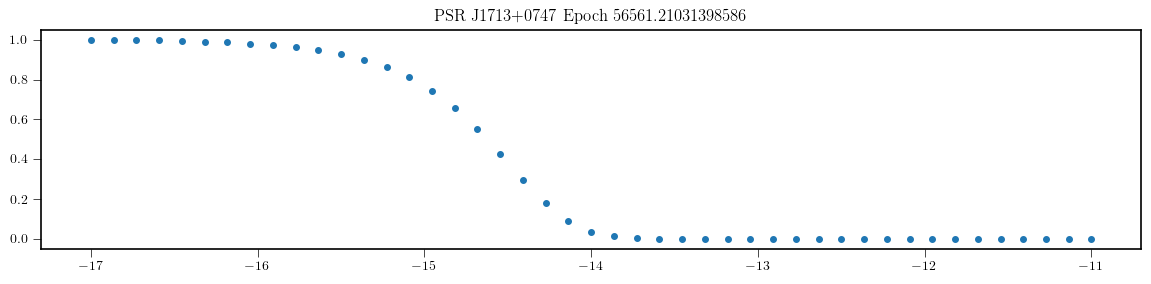

(45,)
(45,)
(45,)


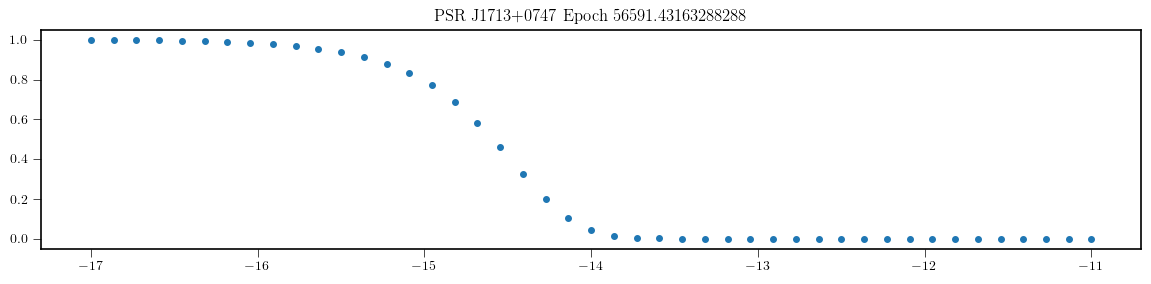

(45,)
(45,)
(45,)


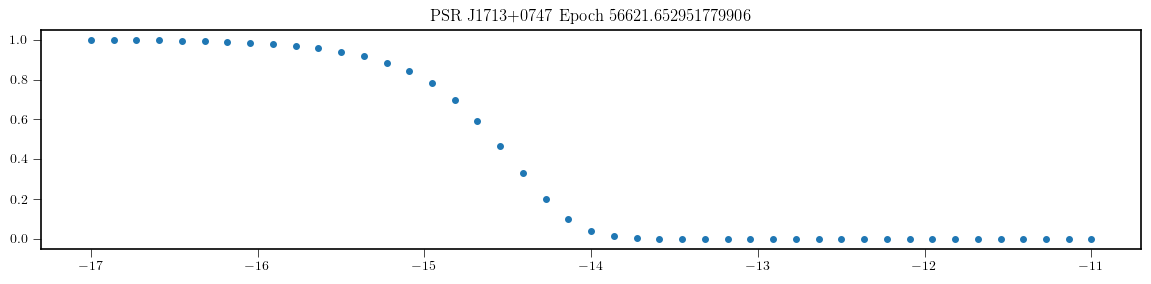

(45,)
(45,)
(45,)


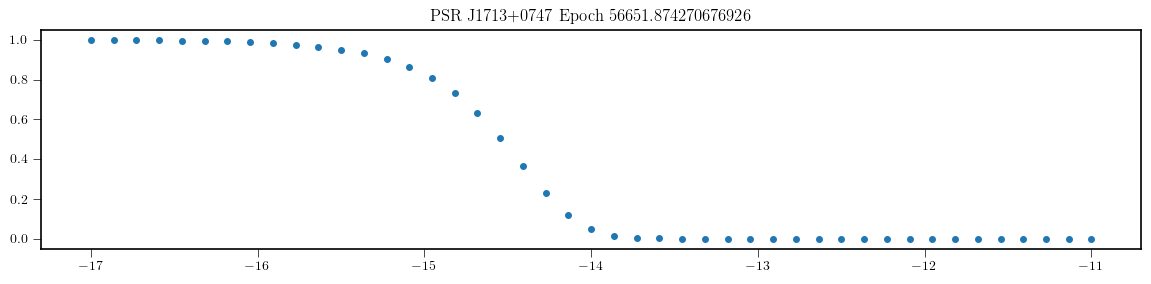

(45,)
(45,)
(45,)


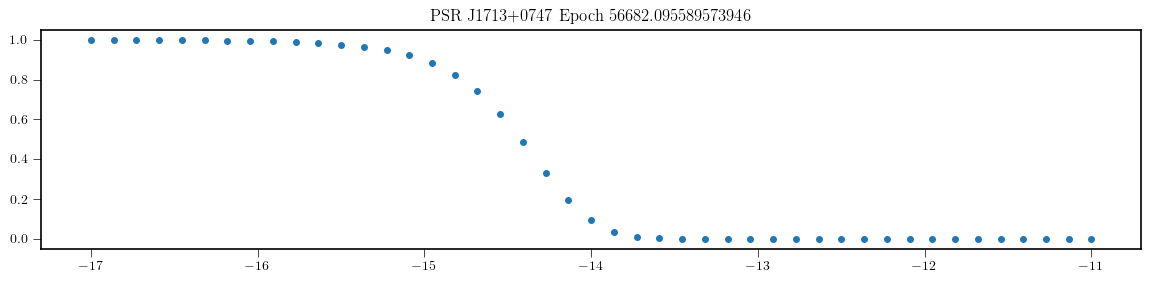

(45,)
(45,)
(45,)


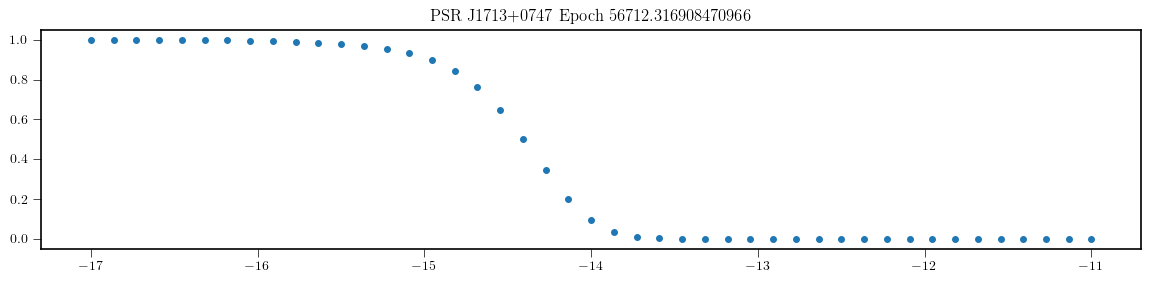

(45,)
(45,)
(45,)


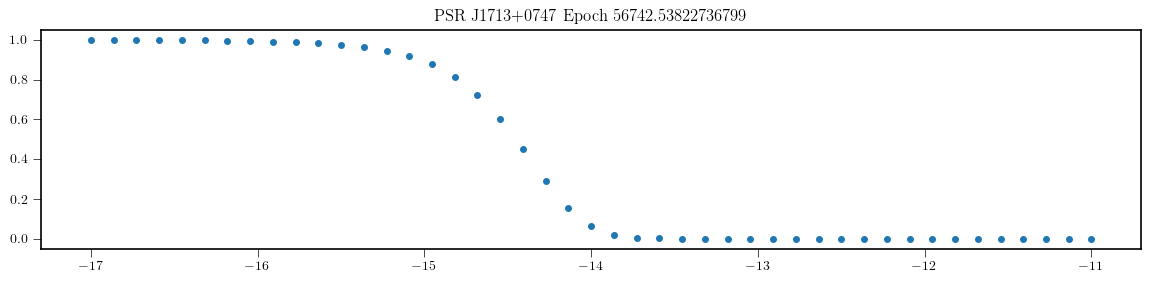

(45,)
(45,)
(45,)


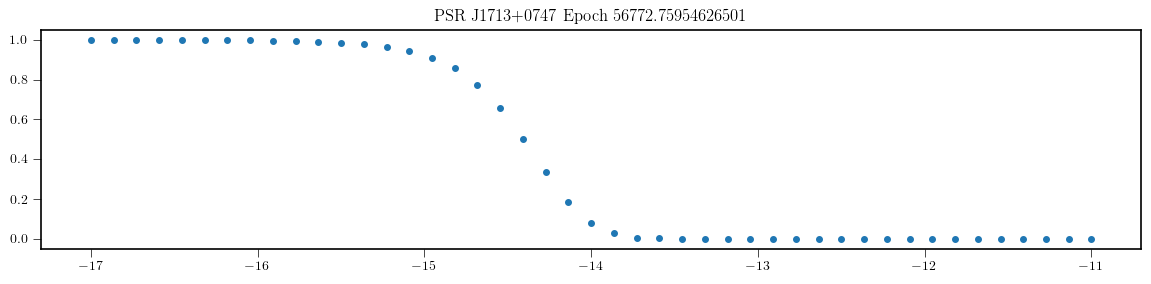

(45,)
(45,)
(45,)


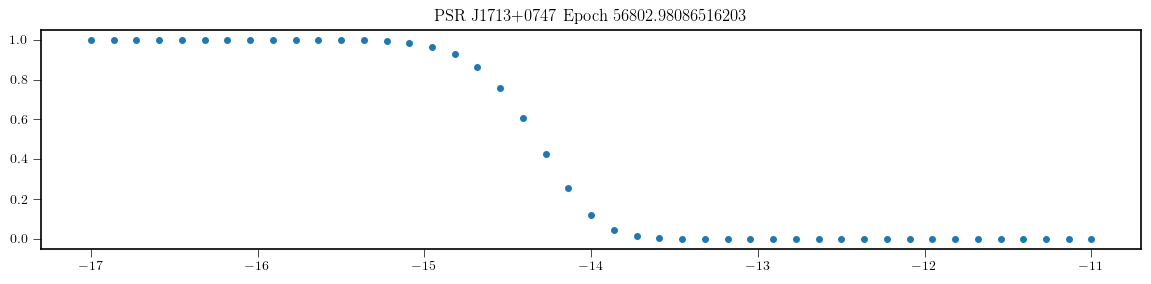

(45,)
(45,)
(45,)


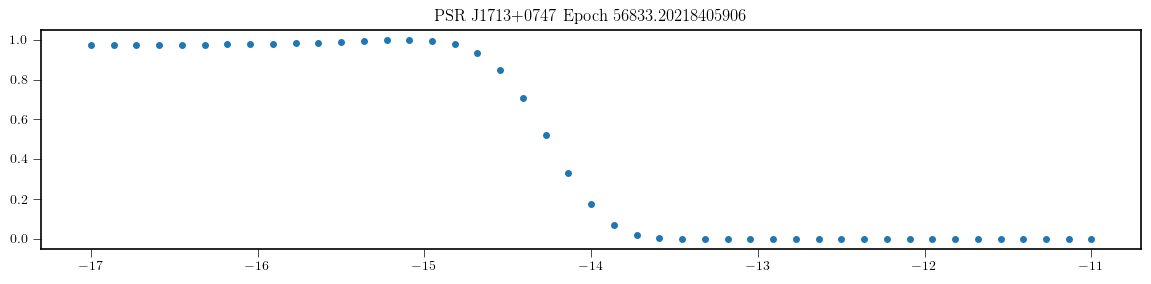

(45,)
(45,)
(45,)


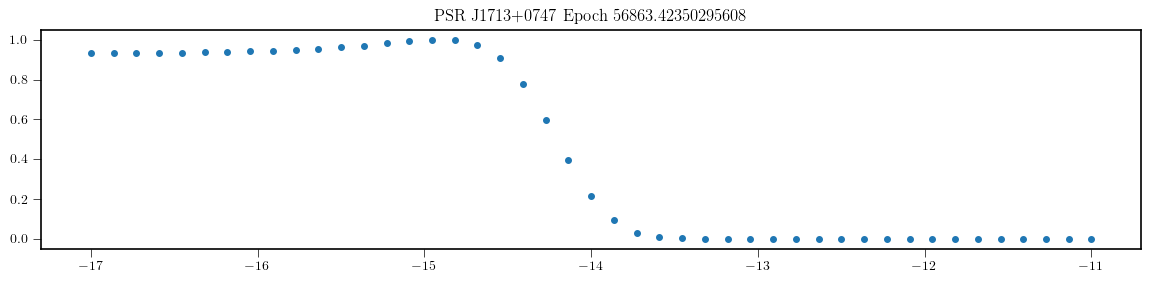

(45,)
(45,)
(45,)


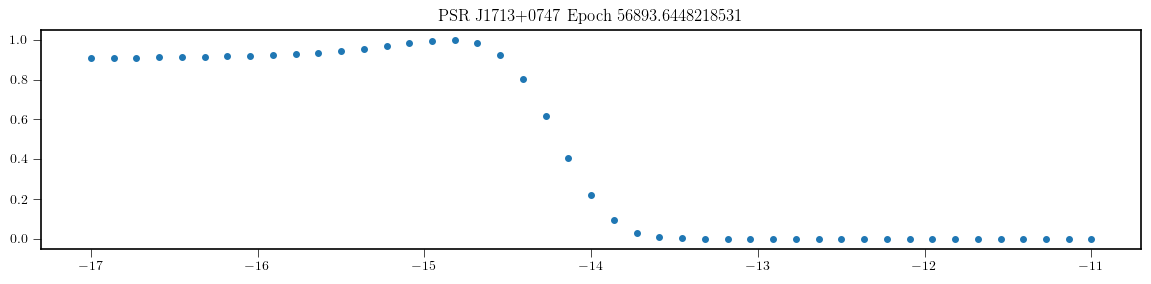

(45,)
(45,)
(45,)


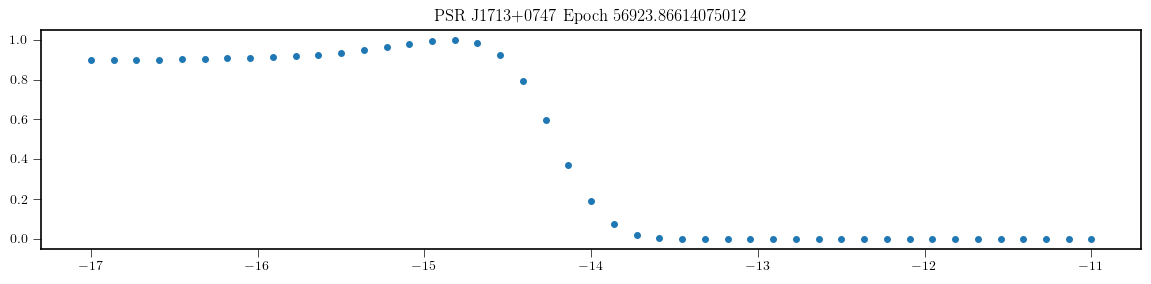

(45,)
(45,)
(45,)


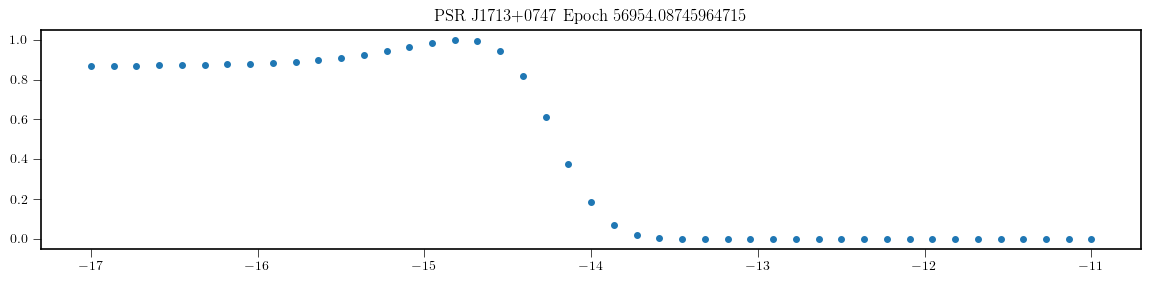

(45,)
(45,)
(45,)


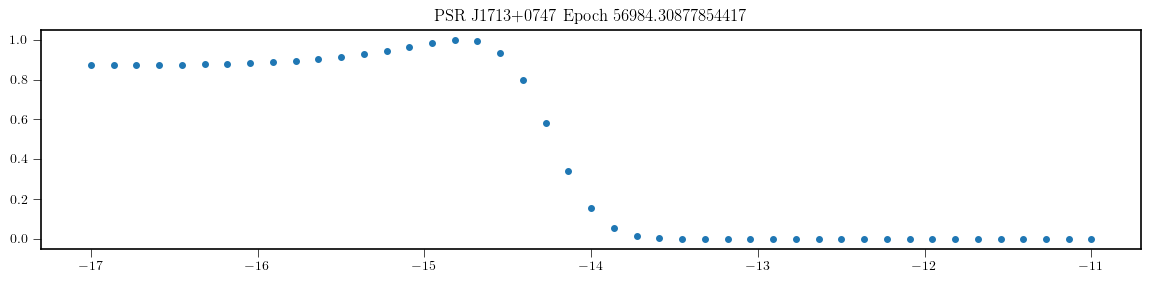

(45,)
(45,)
(45,)


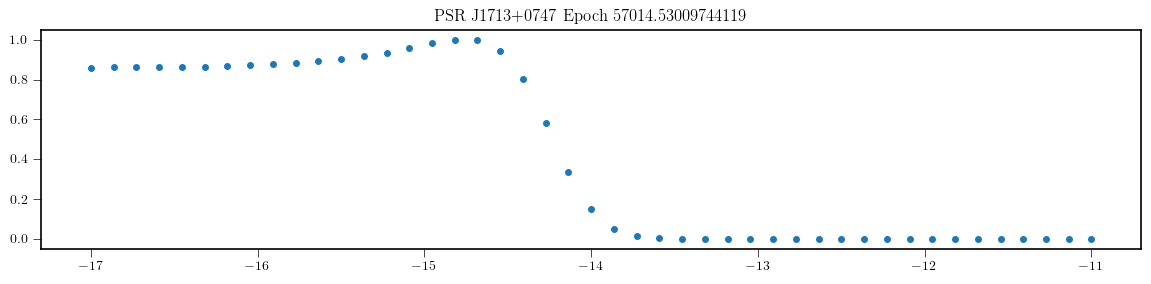

(45,)
(45,)
(45,)


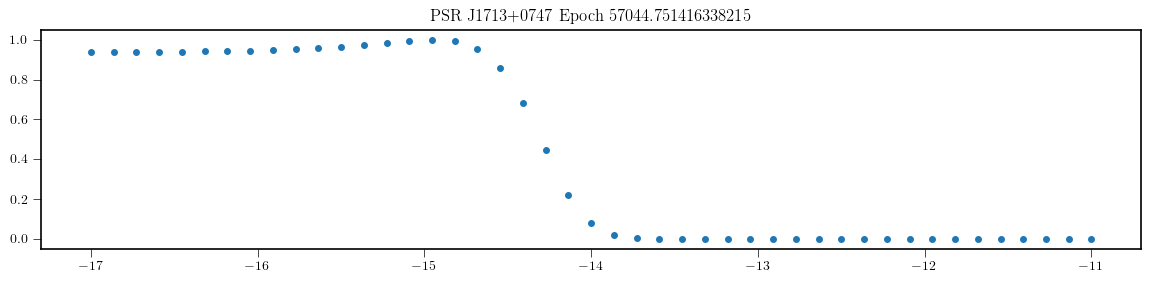

(45,)
(45,)
(45,)


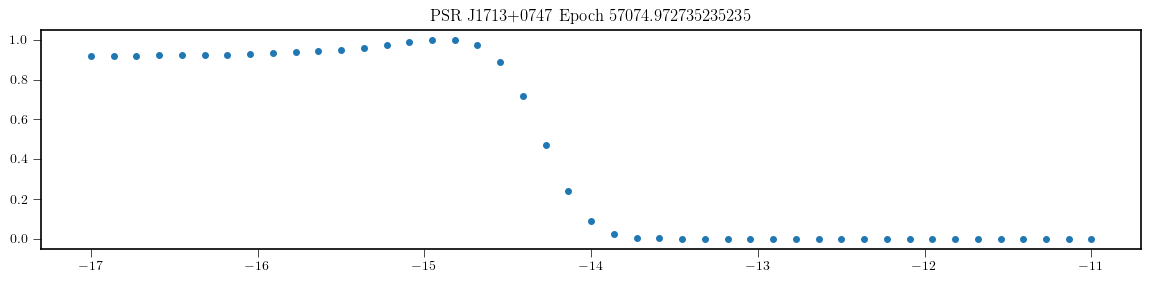

(45,)
(45,)
(45,)


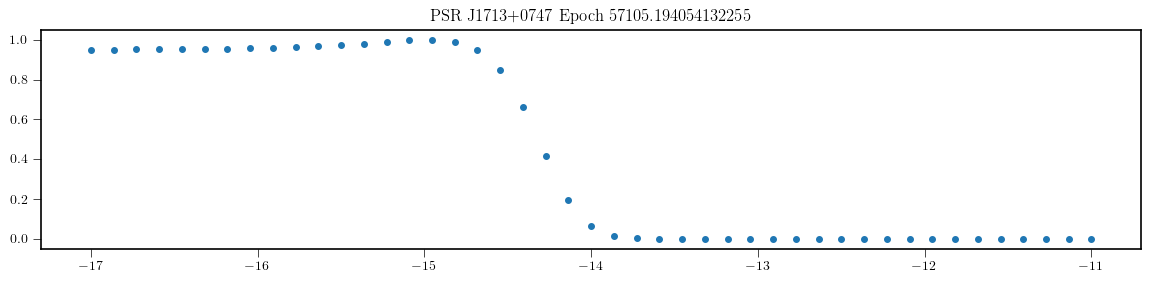

(45,)
(45,)
(45,)


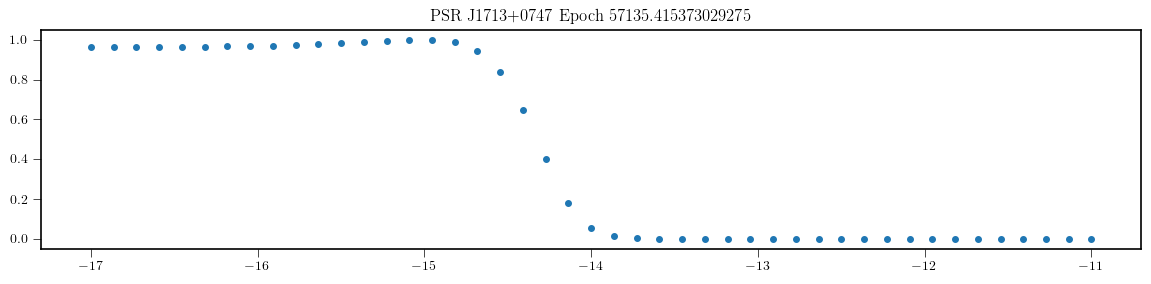

(45,)
(45,)
(45,)


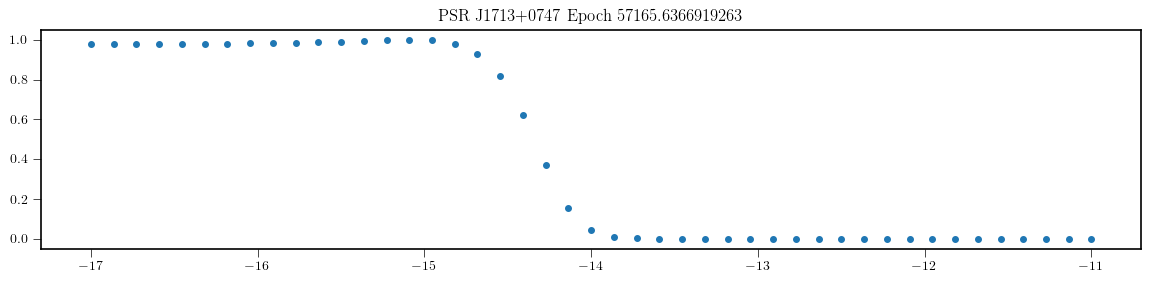

(45,)
(45,)
(45,)


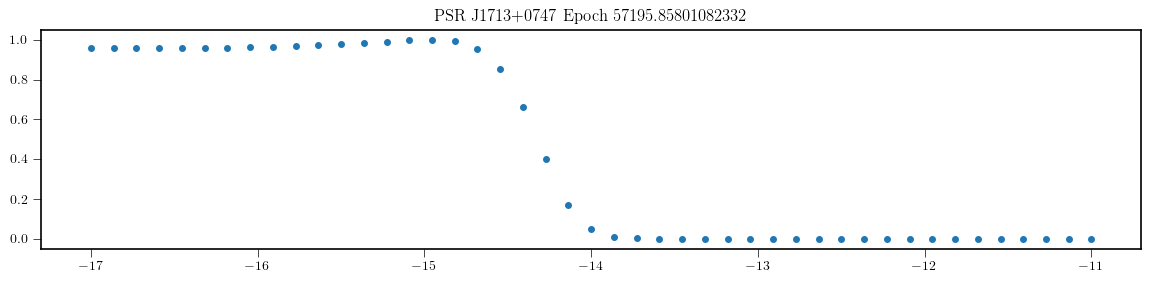

(45,)
(45,)
(45,)


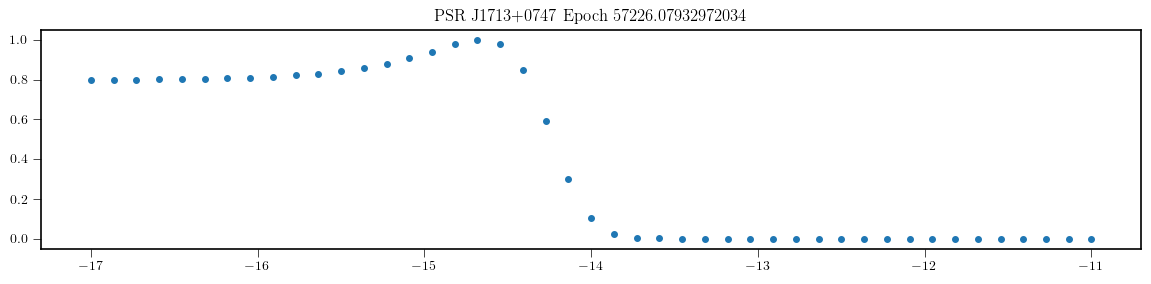

(45,)
(45,)
(45,)


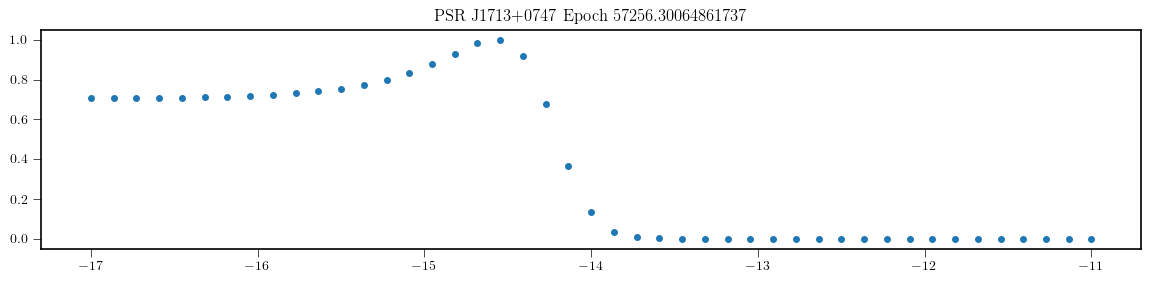

(45,)
(45,)
(45,)


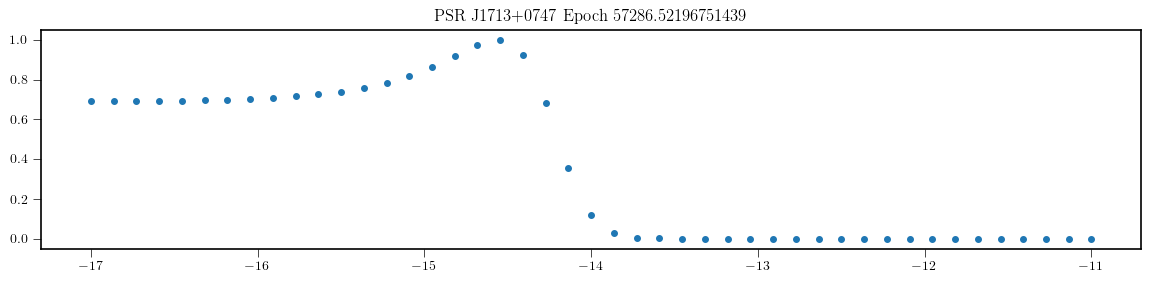

(45,)
(45,)
(45,)


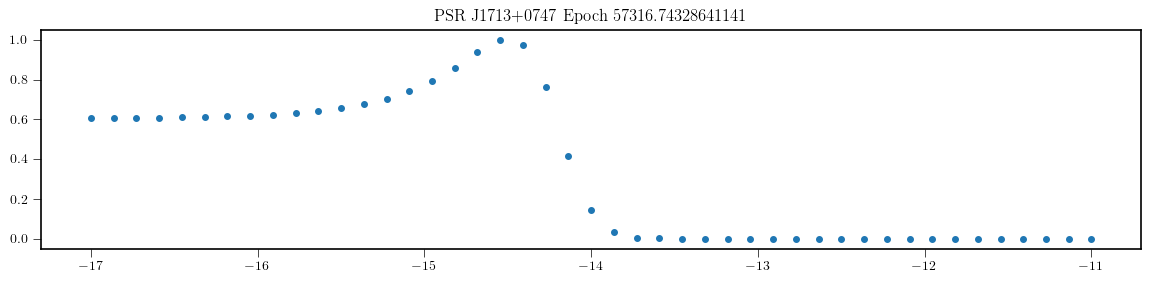

(45,)
(45,)
(45,)


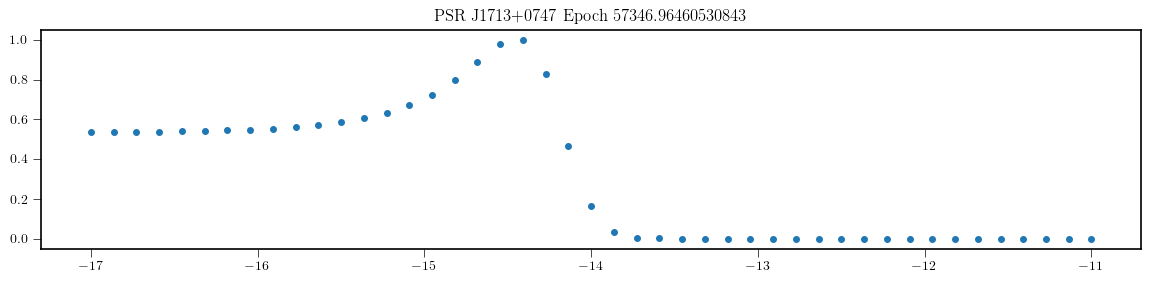

(45,)
(45,)
(45,)


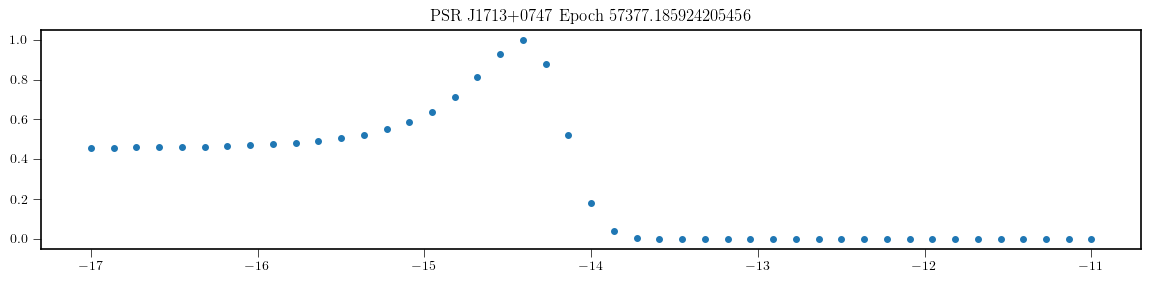

(45,)
(45,)
(45,)


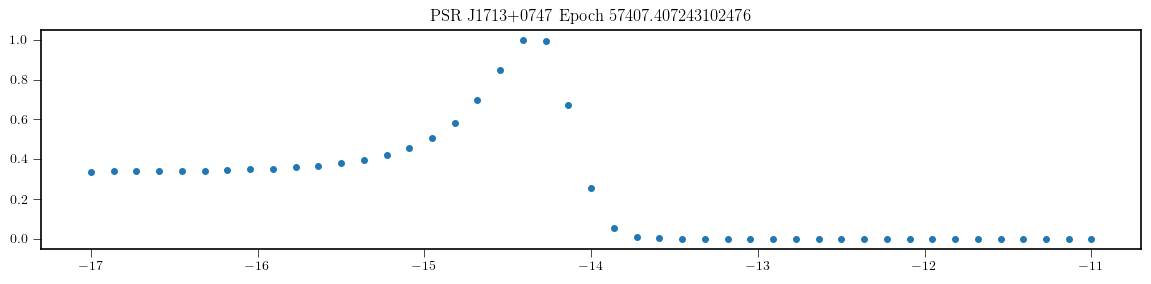

(45,)
(45,)
(45,)


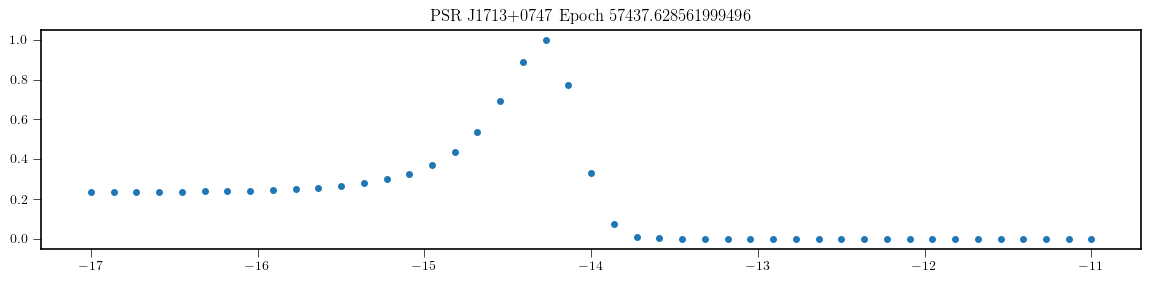

(45,)
(45,)
(45,)


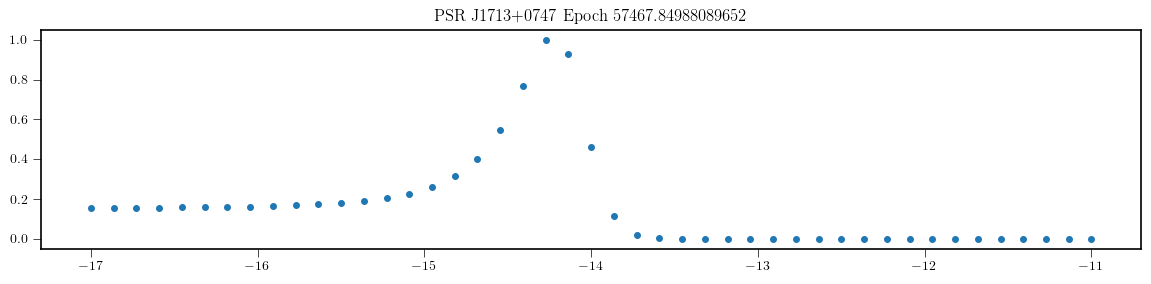

(45,)
(45,)
(45,)


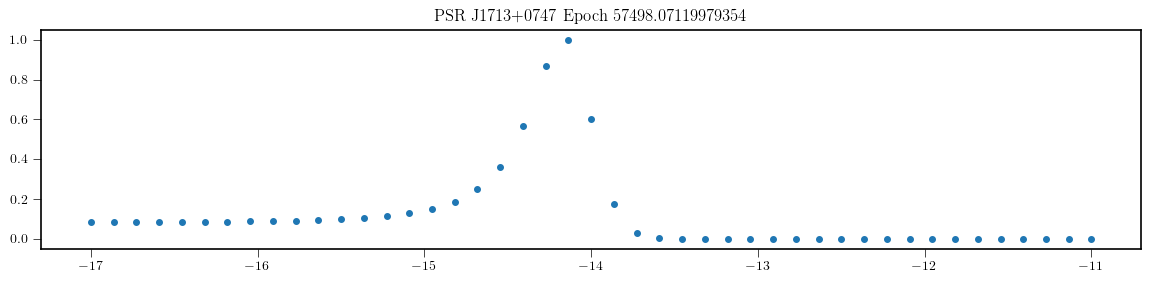

(45,)
(45,)
(45,)


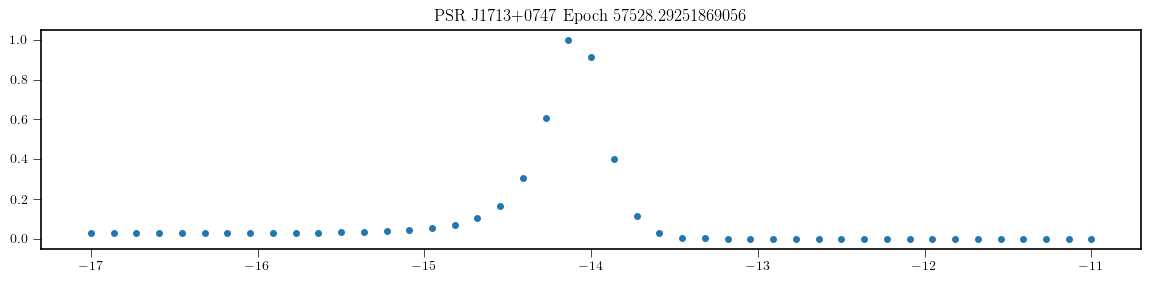

(45,)
(45,)
(45,)


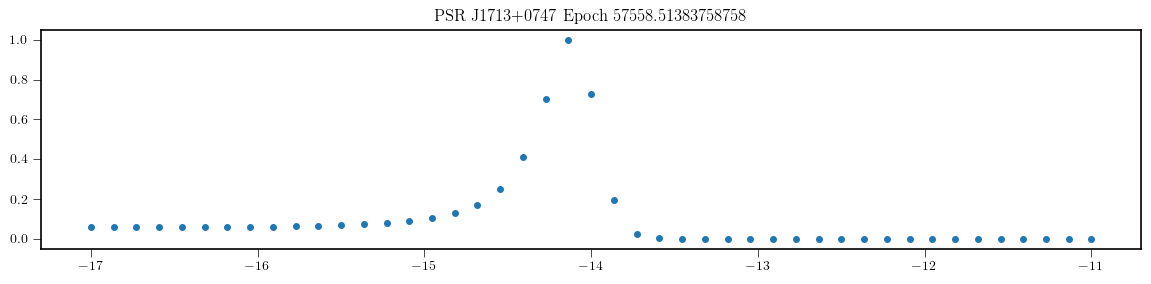

(45,)
(45,)
(45,)


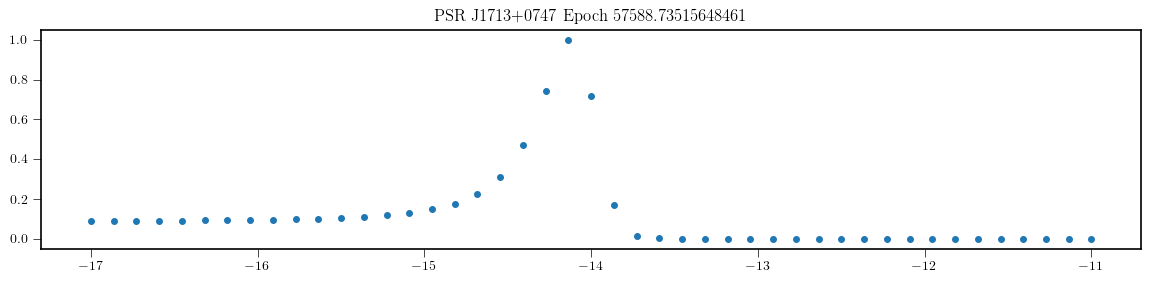

(45,)
(45,)
(45,)


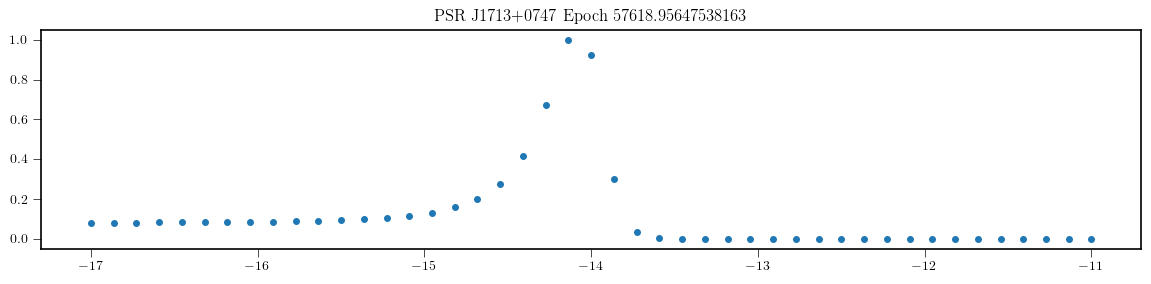

(45,)
(45,)
(45,)


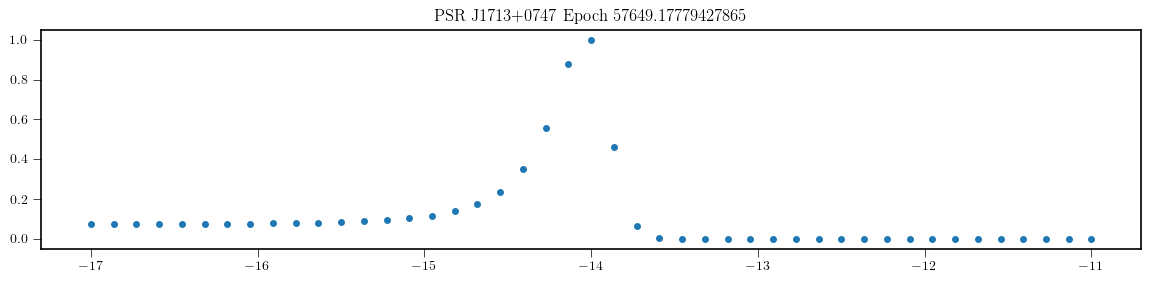

(45,)
(45,)
(45,)


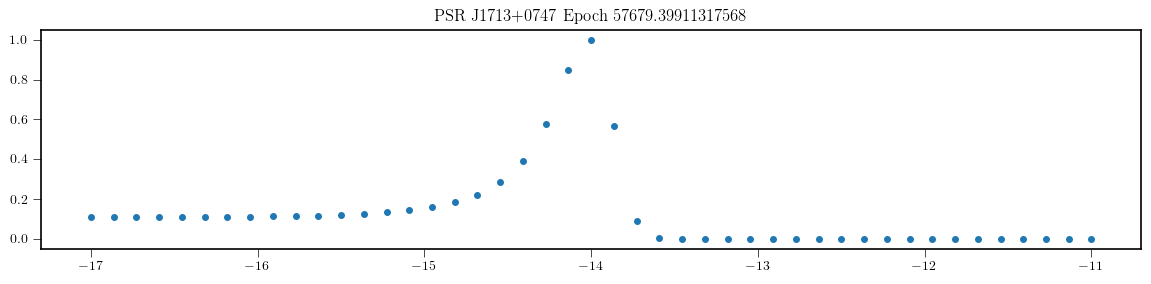

(45,)
(45,)
(45,)


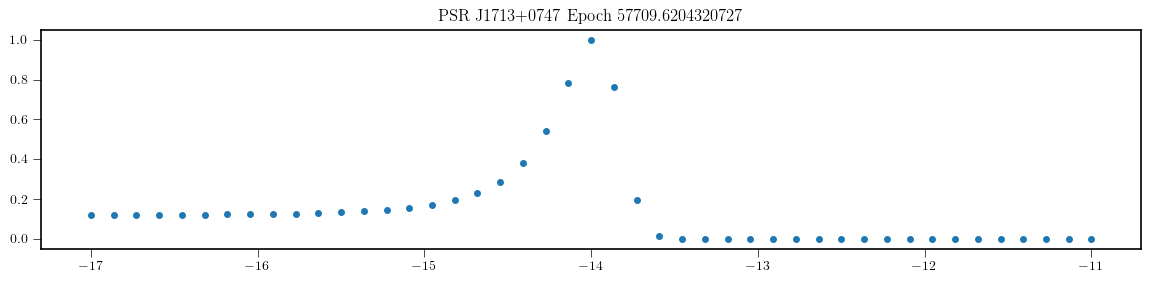

(45,)
(45,)
(45,)


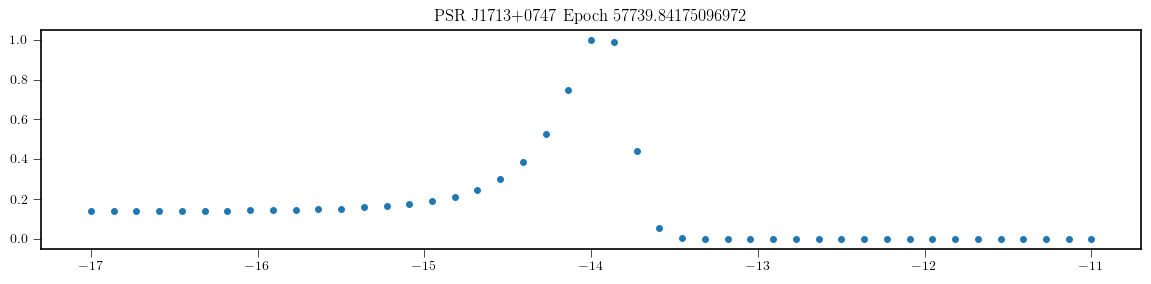

(45,)
(45,)
(45,)


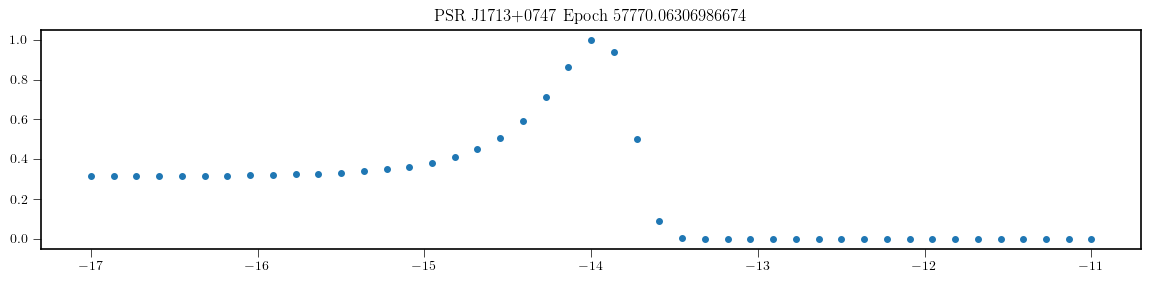

(45,)
(45,)
(45,)


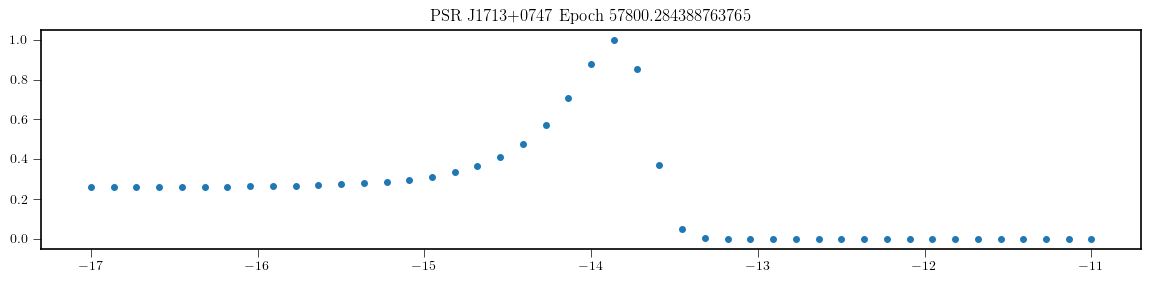

(45,)
(45,)
(45,)


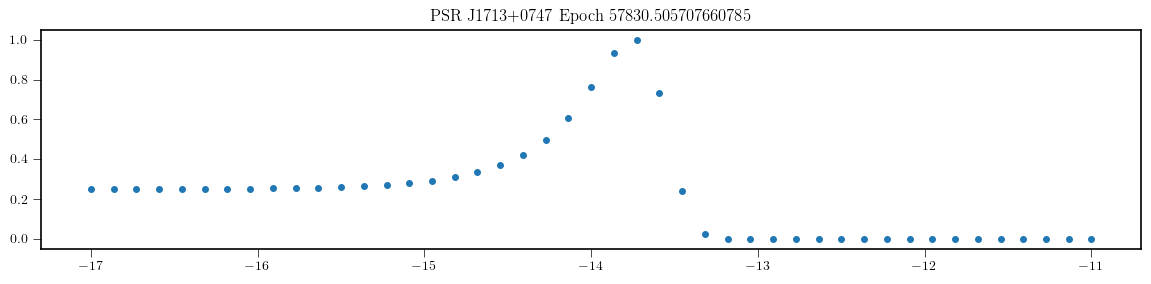

(45,)
(45,)
(45,)


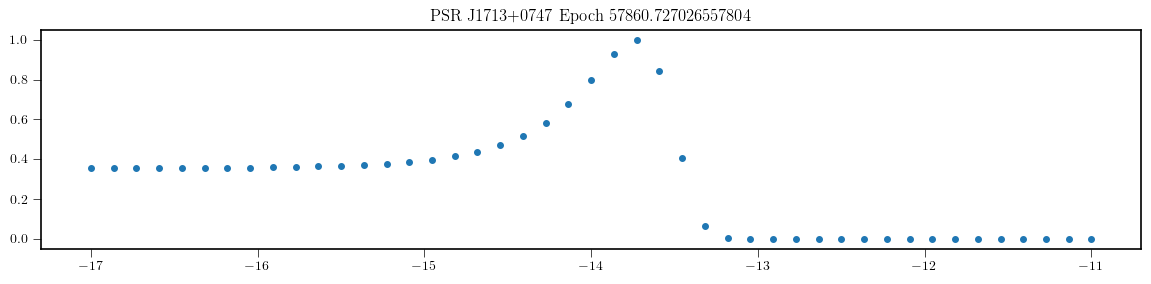

(45,)
(45,)
(45,)


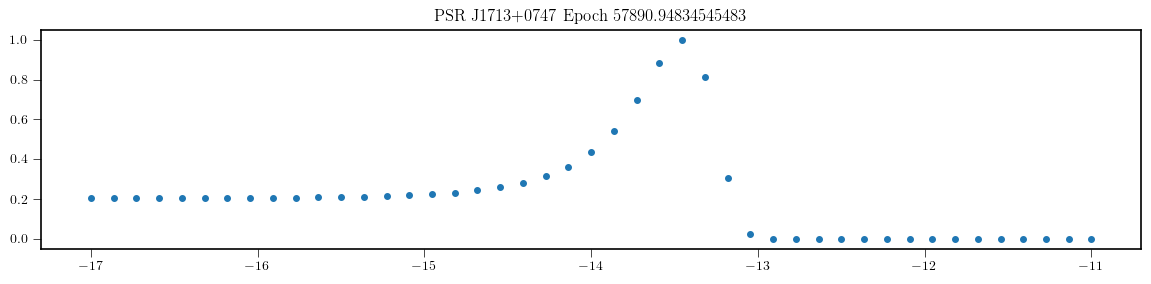

(45,)
(45,)
(45,)


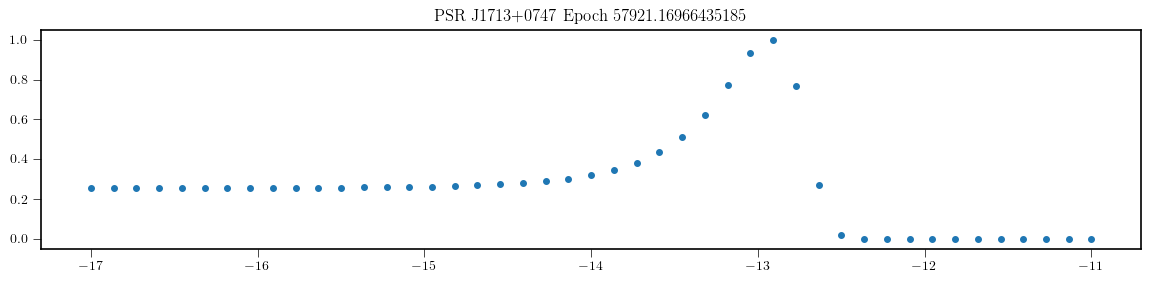

In [172]:
for epoch_idx, epoch in enumerate(pardict['ramp_t0']):
    loglikes = reshaped_looktable[:, epoch_idx, -1]
    maxlike = np.amax(loglikes)
    
    print(loglikes.shape)
    
    likes = np.exp(loglikes - maxlike)
    
    print(pardict['ramp_log10_A'].shape)
    print(likes.shape)
    
    plt.scatter(pardict['ramp_log10_A'], likes)
    plt.title("PSR J1713+0747 Epoch {}".format(epoch))
    plt.show()

# now some bootstrapping code

## mapgamma

In [ ]:
bootstrapped_UL95_dict = {}

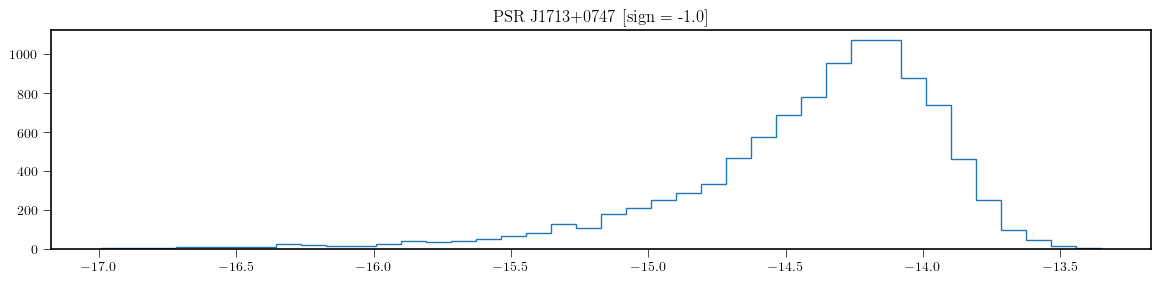

Finished bootstrapping for PSR J1713+0747 [sign = -1.0]


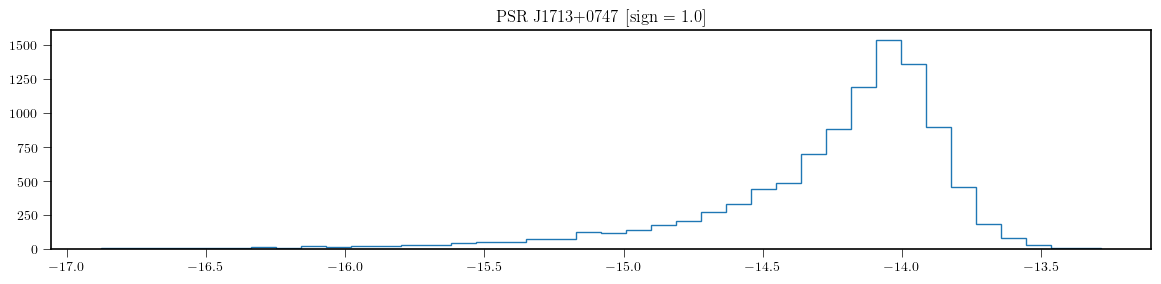

Finished bootstrapping for PSR J1713+0747 [sign = 1.0]


In [59]:

for psr in allpsrs:
    if psr.name == 'J1713+0747':
        for sign in [-1.0, 1.0]:
            resampled_post_path = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/180days_{}.txt'.format(psr.name, sign)
            resampled_posterior = np.loadtxt(resampled_post_path)

            plt.hist(resampled_posterior, bins=40, histtype='step')
            plt.title("PSR {} [sign = {}]".format(psr.name, sign))
            plt.show()
            plt.close()
            bootstrapped_UL95_dict[(psr.name, sign)] = []

            for i in range(1000): #bootstrap 1000 times
                bootstrapped_post = np.random.choice(resampled_posterior, replace=True, size=len(resampled_posterior))

                factlike_ul = sorted(bootstrapped_post)[int(0.95 * len(bootstrapped_post))]
                bootstrapped_UL95_dict[(psr.name, sign)].append(factlike_ul)
            print("Finished bootstrapping for PSR {} [sign = {}]".format(psr.name, sign))

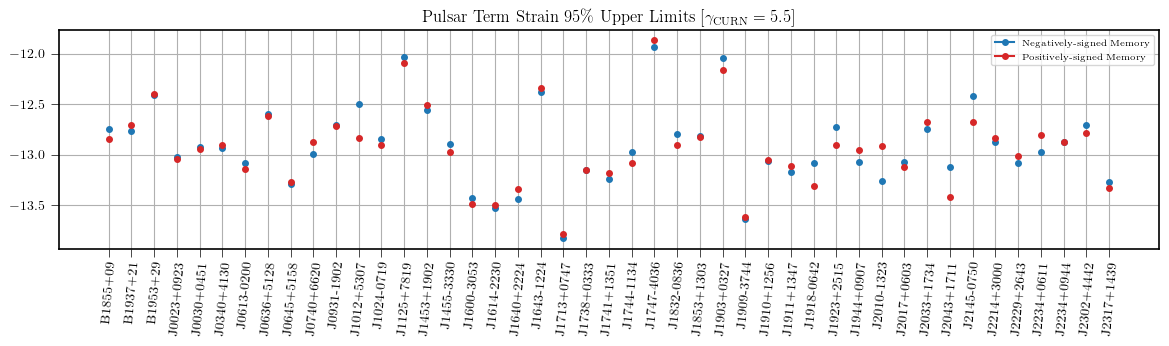

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1)
domain = np.arange(len(allpsrs))

for ii_psr, psr in enumerate(allpsrs):
    neg_resampled_post_path = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/180days_{}.txt'.format(psr.name, -1.0)
    pos_resampled_post_path = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/180days_{}.txt'.format(psr.name, 1.0)
    neg_resampled_posterior = sorted(np.loadtxt(neg_resampled_post_path))
    pos_resampled_posterior = sorted(np.loadtxt(pos_resampled_post_path))
    
    
#     plt.hist(pos_resampled_posterior, color='tab:blue', histtype='step', bins=40)
#     plt.hist(neg_resampled_posterior, color='tab:red', histtype='step', bins=40)
#     plt.show()
#     plt.close()
    
    neg_UL95 = sorted(neg_resampled_posterior)[int(0.95*len(neg_resampled_posterior))]
    pos_UL95 = sorted(pos_resampled_posterior)[int(0.95*len(pos_resampled_posterior))]
    
    neg_bootstrap_post = sorted(bootstrapped_UL95_dict[(psr.name, -1.0)])
    pos_bootstrap_post = sorted(bootstrapped_UL95_dict[(psr.name, 1.0)])
    
    neg_CI_lower = neg_bootstrap_post[int(0.025*len(neg_bootstrap_post))]
    neg_CI_upper = neg_bootstrap_post[int(0.975*len(neg_bootstrap_post))]
    
    pos_CI_lower = pos_bootstrap_post[int(0.025*len(pos_bootstrap_post))]
    pos_CI_upper = pos_bootstrap_post[int(0.975*len(pos_bootstrap_post))]
                                        
    
#     print("{} [{} , {}]".format(neg_UL95, neg_CI_lower, neg_CI_upper))
            
            
    neg_errcont = ax.errorbar([ii_psr], [neg_UL95], yerr = [[np.abs(neg_CI_lower - neg_UL95)],[np.abs(neg_CI_upper - neg_UL95)]], marker='o', color='tab:blue', label='Negatively-signed Memory')
    pos_errcont = ax.errorbar([ii_psr], [pos_UL95], yerr=[[np.abs(pos_CI_lower - pos_UL95)],[np.abs(pos_CI_upper - pos_UL95)]], marker='o', color='tab:red', label='Positively-signed Memory')
    
    
    
ax.set_xticks(np.arange(len(allpsrs)))
ax.set_xticklabels([p.name for p in allpsrs], rotation=85)
ax.grid()
ax.legend(handles=[neg_errcont[0], pos_errcont[0]], labels = ["Negatively-signed Memory", "Positively-signed Memory"])
    
plt.title("Pulsar Term Strain 95\% Upper Limits [$\gamma_{\mathrm{CURN}} = 5.5$]")
plt.show()
    

In [ ]:
# Now let's plot the MCMC upper limit runs 

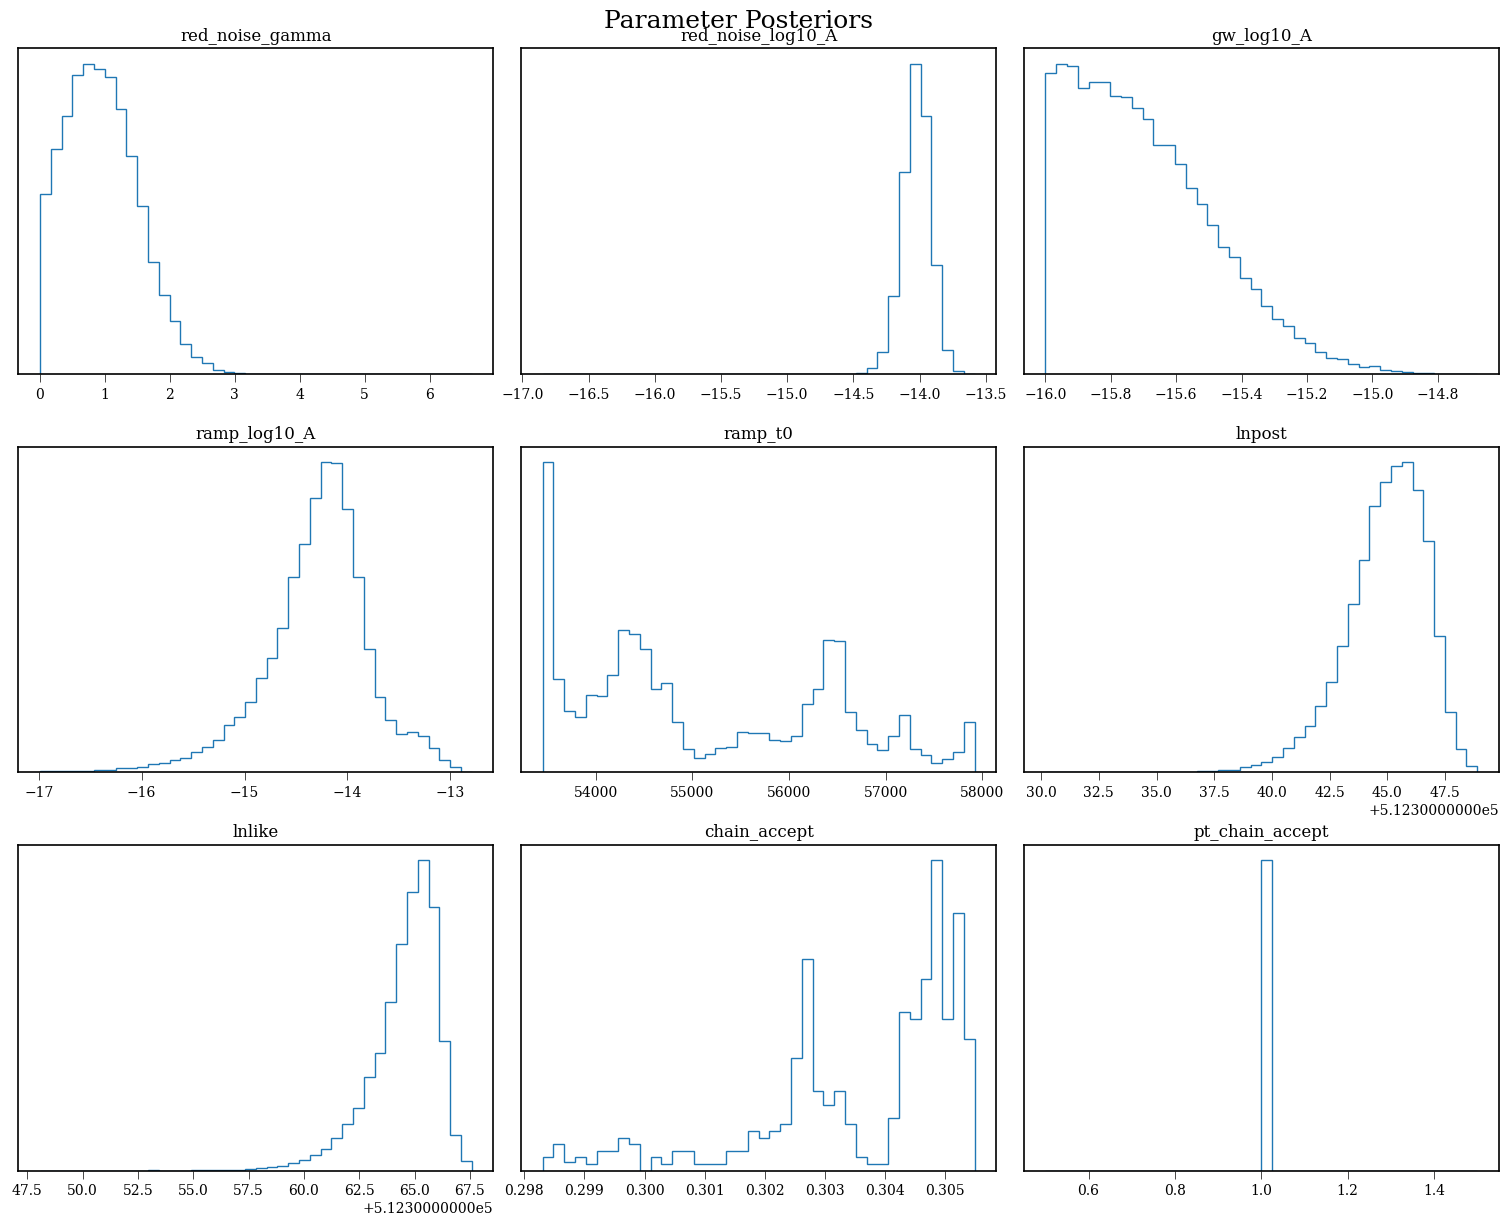

/home/nima/anaconda3/envs/nano15/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [32]:

chaindir = '/home/nima/nanograv/12p5yr_bwm/bayesian_verification/det_everything_mapgamma/J1713+0747_-1/'
J1713_detrun_mapgamma = Core(chaindir=chaindir)
plot_chains(J1713_detrun_mapgamma)

plt.rcParams.update(params)


In [85]:
neg_errcont[0]

## Wrong CRN Index

In [21]:
def resample_180day_cutoff_worker(psr):
    partial_outdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/resampled_amps/{}/'.format(psr.name)
    if not os.path.exists(partial_outdir):
        os.mkdir(partial_outdir)

    lookupdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/{}/'.format(psr.name)

    looktable_path = lookupdir + '{}_lookup.txt'.format(psr.name, psr.name)
    looktable = np.loadtxt(looktable_path)

    parfile = lookupdir + 'pars.txt'.format(psr.name)
    with open(parfile, 'r') as f:
        parlines=f.readlines()

    pardict = {}
    for parline in parlines:
        key, np_pars = parline.split(';')

        start,stop,num = np_pars.split(',')
        pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
        #print(pardict)
    lookup_shape = (len(pardict['ramp_log10_A']), len(pardict['ramp_t0']), len(pardict['sign'])) #let's do this intelligently

    reshaped_looktable = np.reshape(looktable, lookup_shape, order='F')
    #         print(reshaped_looktable.shape)

    amps = pardict['ramp_log10_A']
    t0s = pardict['ramp_t0']
    signs = pardict['sign']




    tmin_mjd_lim = t0s[0] + 180
    tmax_mjd_lim = t0s[-1] - 270

    tmin_idx = np.argmin(np.abs(t0s - tmin_mjd_lim)) 
    tmax_idx = np.argmin(np.abs(t0s - tmax_mjd_lim))

    tmin_mjd = t0s[tmin_idx]
    tmax_mjd = t0s[tmax_idx]


    print("not looking for bursts between MJD {} and MJD {}".format(tmin_mjd, tmax_mjd))
    cols = np.arange(tmin_idx, tmax_idx)

    log10_A_post = np.zeros(len(amps)) 
    for sign_idx, sign in enumerate(signs):
        for log10A_idx in range(len(log10_A_post)):
            submtx_max = np.amax(reshaped_looktable[log10A_idx, :, sign_idx])
            #print(submtx_max)
            #print(np.amin(reshaped_looktable[log10A_idx, :, :]))
            this_l10A_likes = np.zeros(len(cols)) # populate a grid to integrate over to find the
                                                 # epoch-averaged likelihood for this amplitude


            for ii, t0_idx in enumerate(cols):
                # need to add them all into this_l10A_like
                #if reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max > 10:
                #    print("Large likelihood diff")
                like = np.exp(reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max)
                corrected_like = like # no amplitude factor bc integrating over t0
                this_l10A_likes[ii] = corrected_like

            # only need to integrate over the bounds of my custom columns  
            this_l10A_like = spint.simpson(y=this_l10A_likes, x=t0s[cols[0]:cols[-1]+1])
            log10_A_post[log10A_idx] = np.log(this_l10A_like) + submtx_max


        #post-process the log10_amps
        reduced_post=log10_A_post - np.amax(log10_A_post)
        post = np.exp(reduced_post)    
        for amp_idx, amp in enumerate(amps):
            post[amp_idx] = 10**amp * post[amp_idx]

        outfile = partial_outdir + '{}days_{}.txt'.format(180, sign)
        plt.scatter(amps, post, )
        plt.title("PSR {} amplitude posterior [sign = {}]".format(psr.name, sign))
        plt.show()
        plt.close()
        # now build the resampled thing and write it to disk
        resampled = sample_hist(post, amps, num_points = 10000,)
        np.savetxt(outfile, resampled)
        #result_dict[sign] = resampled
    #return result_dict

not looking for bursts between MJD 56251.169160879625 and MJD 57517.96725405093


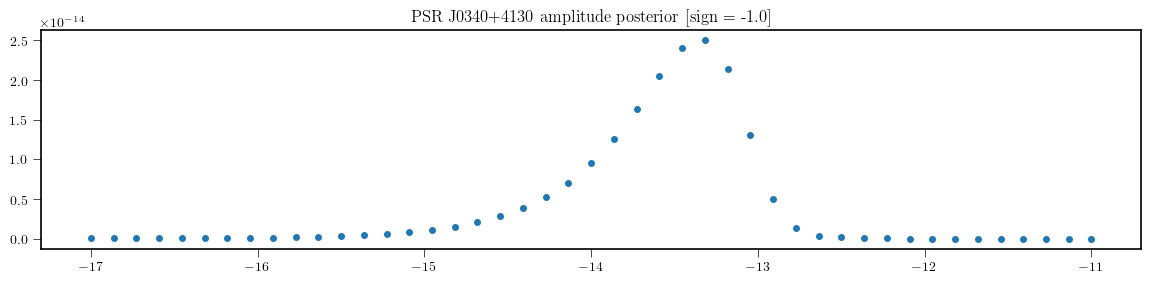

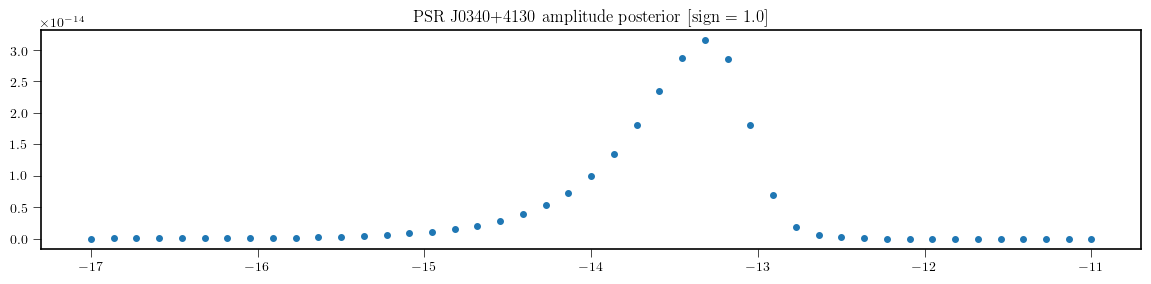

In [22]:
for p in allpsrs:
    if p.name=='J0340+4130':
        J0340 = p
resample_180day_cutoff_worker(J0340)

not looking for bursts between MJD 53630.2357576196 and MJD 57537.911635561344
not looking for bursts between MJD 56095.88126267637 and MJD 57568.42738260582


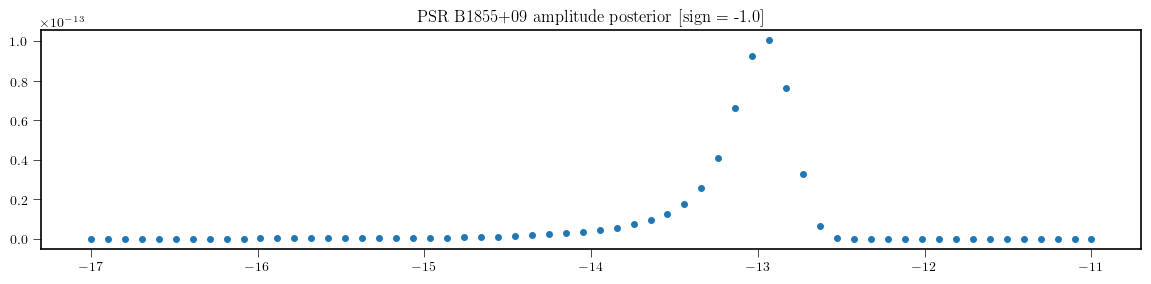

not looking for bursts between MJD 53474.70026270103 and MJD 57620.966862892914
not looking for bursts between MJD 55973.022903769845 and MJD 57656.89170916006


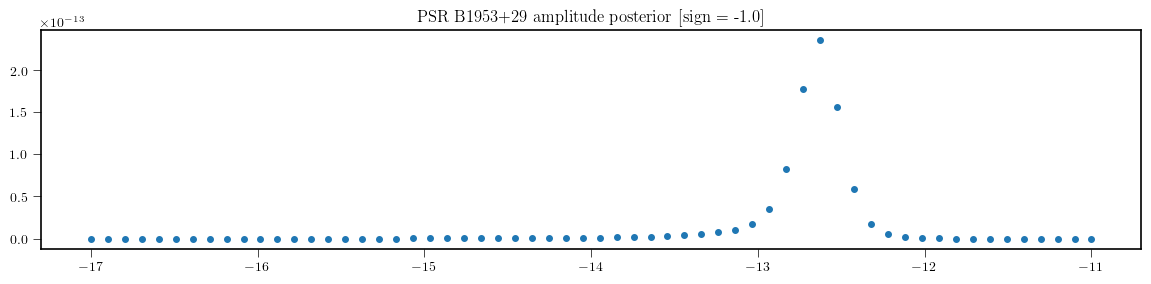

not looking for bursts between MJD 56251.169160879625 and MJD 57517.96725405093


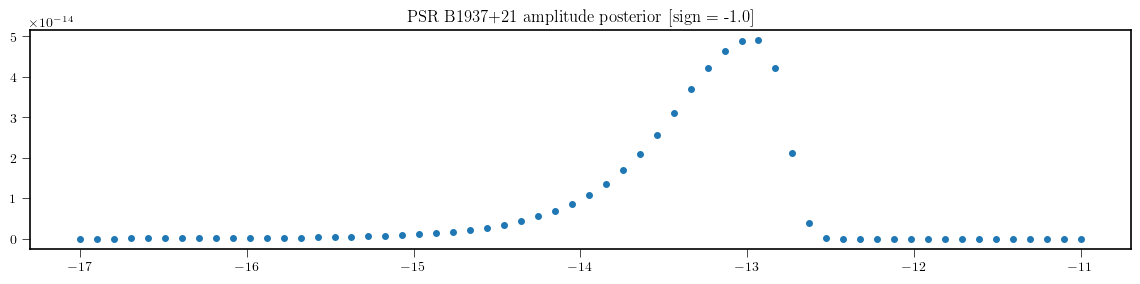

not looking for bursts between MJD 53714.07381018519 and MJD 57649.06427314814


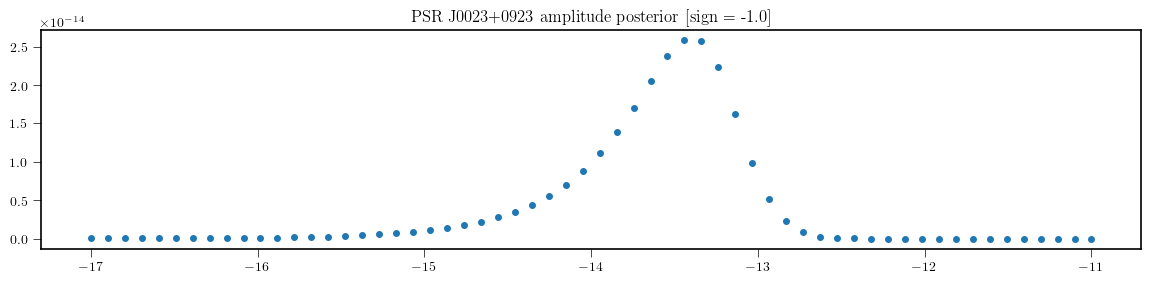

not looking for bursts between MJD 53632.51262925732 and MJD 57522.55415217884


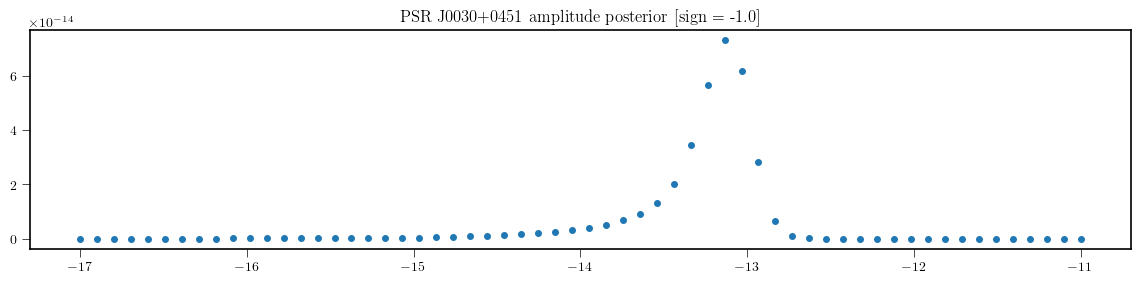

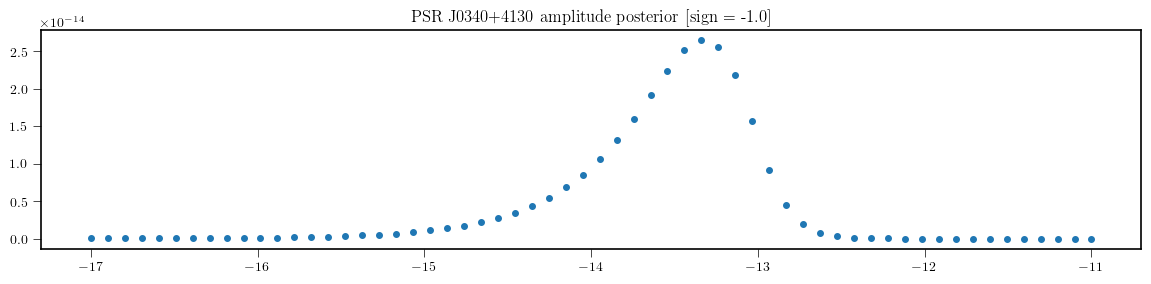

not looking for bursts between MJD 56862.64371759259 and MJD 57635.712062499995
not looking for bursts between MJD 56950.83860585017 and MJD 57513.55119423401not looking for bursts between MJD 56133.066671146946 and MJD 57579.93967499253

not looking for bursts between MJD 56657.96187920876 and MJD 57553.19581544613


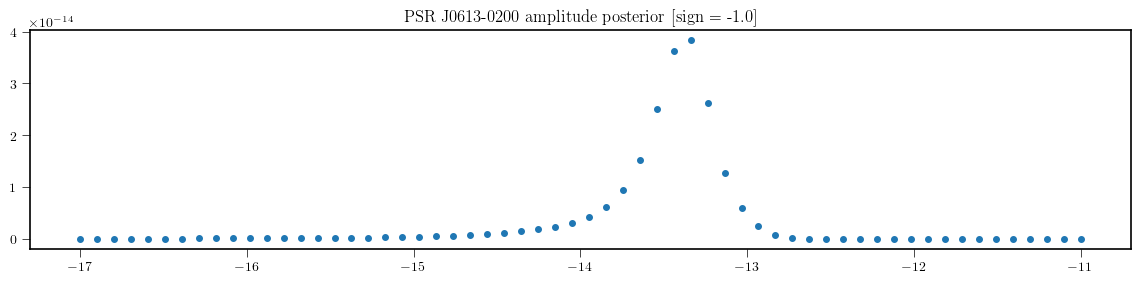

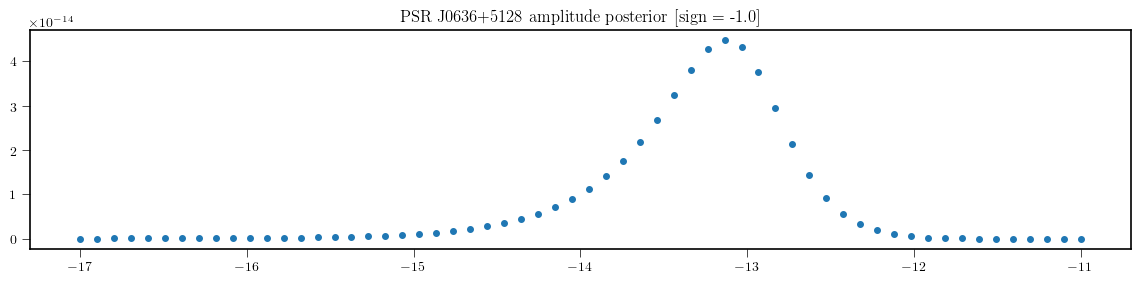

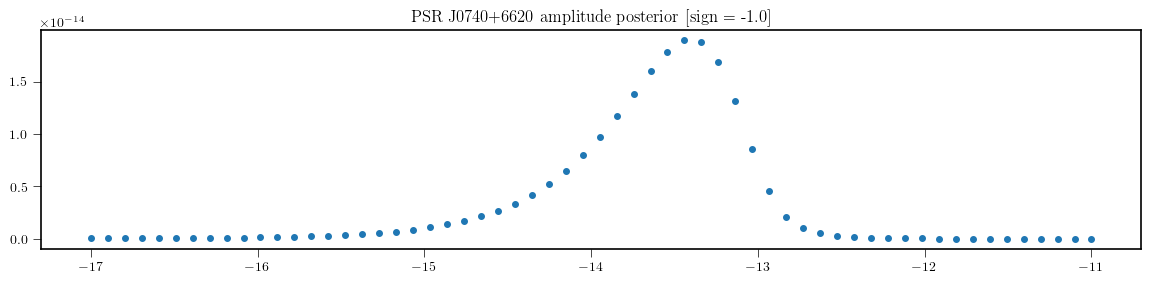

not looking for bursts between MJD 55487.68699101964 and MJD 57557.152349118696not looking for bursts between MJD 56923.06870177469 and MJD 57576.79569733796

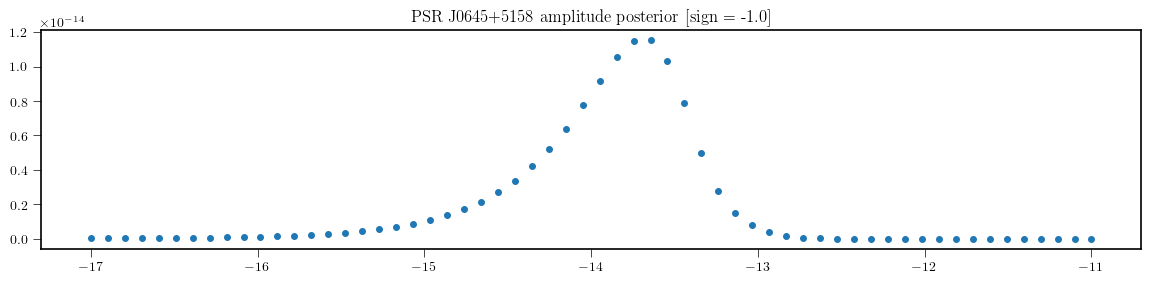



not looking for bursts between MJD 53449.78056421695 and MJD 57583.485282146794

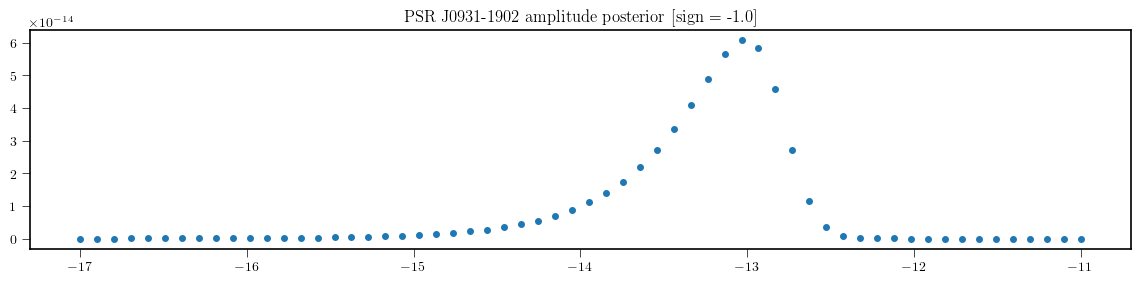

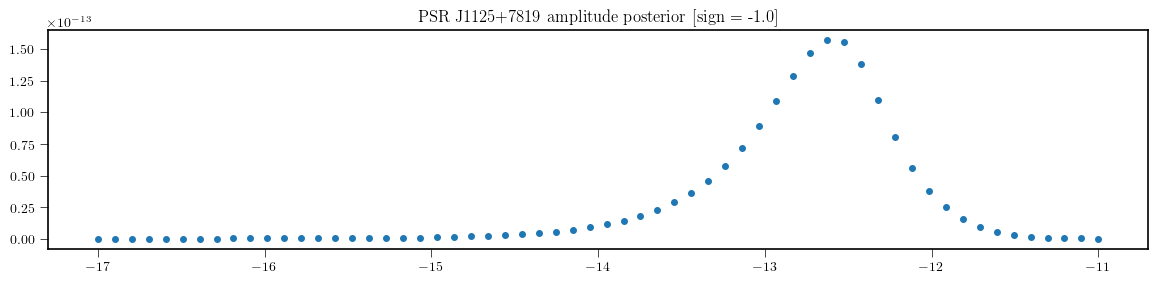

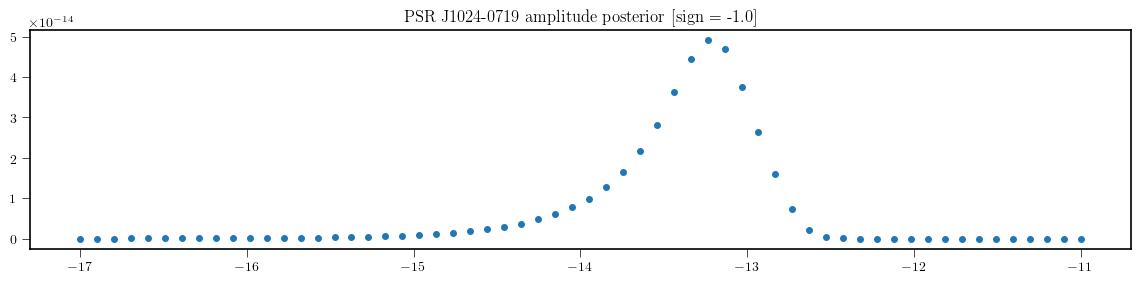

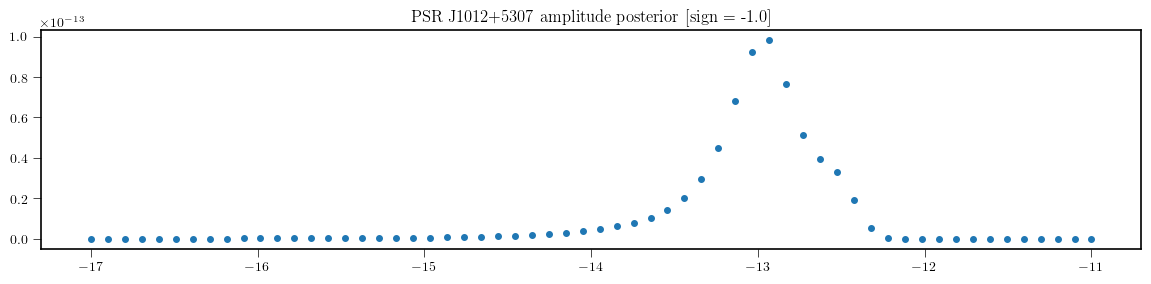

Process ForkPoolWorker-115:
Process ForkPoolWorker-119:
Process ForkPoolWorker-117:
Process ForkPoolWorker-118:
Process ForkPoolWorker-109:
Process ForkPoolWorker-112:
Process ForkPoolWorker-114:
Process ForkPoolWorker-116:
Process ForkPoolWorker-122:
Process ForkPoolWorker-111:
Process ForkPoolWorker-110:
Process ForkPoolWorker-121:
Traceback (most recent call last):
Process ForkPoolWorker-120:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-113:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/multiproc

  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/site-packages/scipy/interpolate/interpolate.py", line 684, in _evaluate
    below_bounds, above_bounds = self._check_bounds(x_new)
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/tmp/ipykernel_28224/1525661265.py", line 82, in resample_180day_cutoff_worker
    resampled = sample_hist(post, amps, num_points = 10000,)
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/site-packages/scipy/interpolate/polyint.py", line 77, in __call__
    x, x_shape = self._prepare_x(x)
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/site-packages/scipy/interpolate/polyint.py", line 78, in __call__
 

KeyboardInterrupt: 

  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/site-packages/scipy/interpolate/interpolate.py", line 712, in _check_bounds
    if self.bounds_error and below_bounds.any():
KeyboardInterrupt
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/site-packages/numpy/core/_methods.py", line 56, in _any
    return umr_any(a, axis, dtype, out, keepdims)
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/tmp/ipykernel_28224/1525661265.py", line 82, in resample_180day_cutoff_worker
    resampled = sample_hist(post, amps, num_points = 10000,)
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/site-packages/scipy/interpolate/interpolate.py", line 684, in _evaluate
    below_bounds, above_bounds = self._check_bounds(x_new)
  File "/home/nima/anaconda3/envs/nano15/lib/python3.8/site-packages/scipy/interpolate/interpolate.py", line 712, in _check_bounds
    if self.bounds_error and below_bounds.any():
  Fi

In [151]:
pool = mp.Pool(processes=14)
pool.map(resample_180day_cutoff_worker,allpsrs)

not looking for bursts between MJD 53630.2357576196 and MJD 57537.911635561344
not looking for bursts between MJD 56095.88126267637 and MJD 57568.42738260582
not looking for bursts between MJD 53474.70026270103 and MJD 57620.966862892914
not looking for bursts between MJD 55973.022903769845 and MJD 57656.89170916006
not looking for bursts between MJD 53714.07381018519 and MJD 57649.06427314814
not looking for bursts between MJD 56249.5285848902 and MJD 57520.42811803507


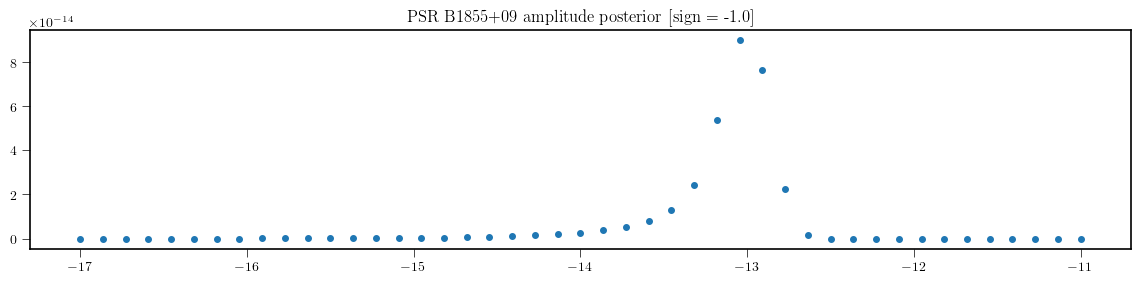

not looking for bursts between MJD 53632.51262925732 and MJD 57522.55415217884
not looking for bursts between MJD 56862.64371759259 and MJD 57635.712062499995
not looking for bursts between MJD 56133.066671146946 and MJD 57579.93967499253
not looking for bursts between MJD 56950.83860585017 and MJD 57513.55119423401
not looking for bursts between MJD 56657.96187920876 and MJD 57553.19581544613


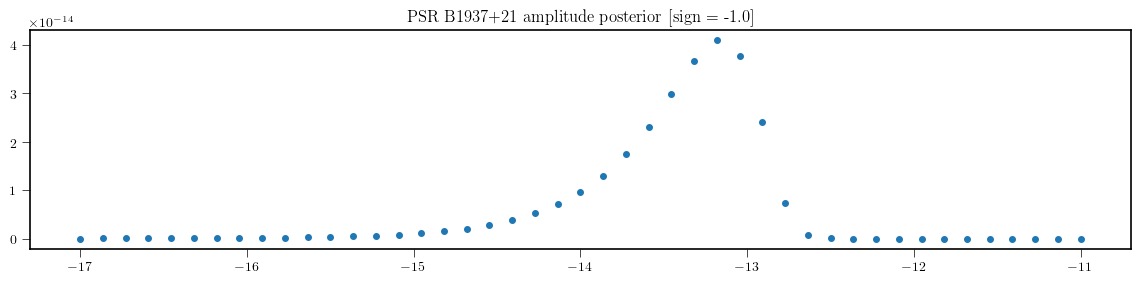

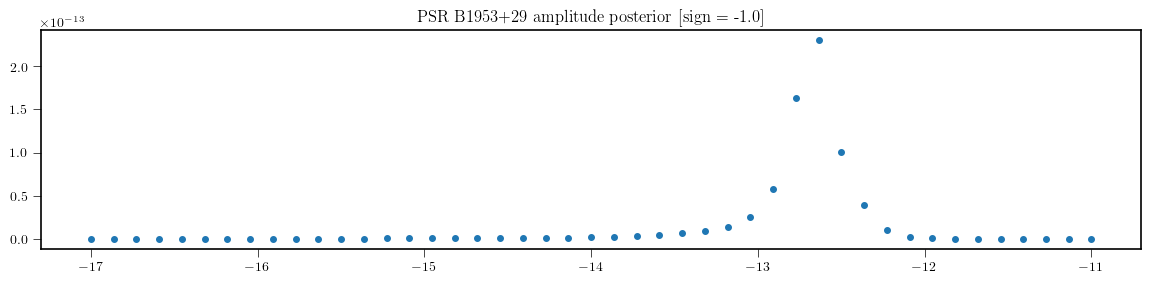

not looking for bursts between MJD 53449.78056421695 and MJD 57583.485282146794
not looking for bursts between MJD 56923.06870177469 and MJD 57576.79569733796not looking for bursts between MJD 55487.68699101964 and MJD 57557.152349118696



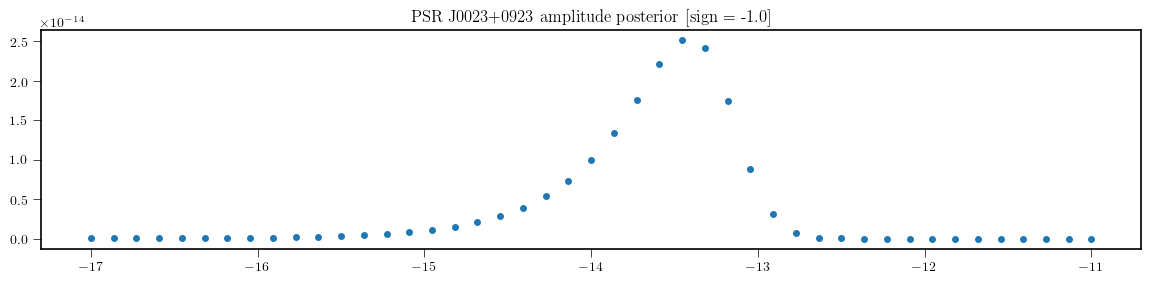

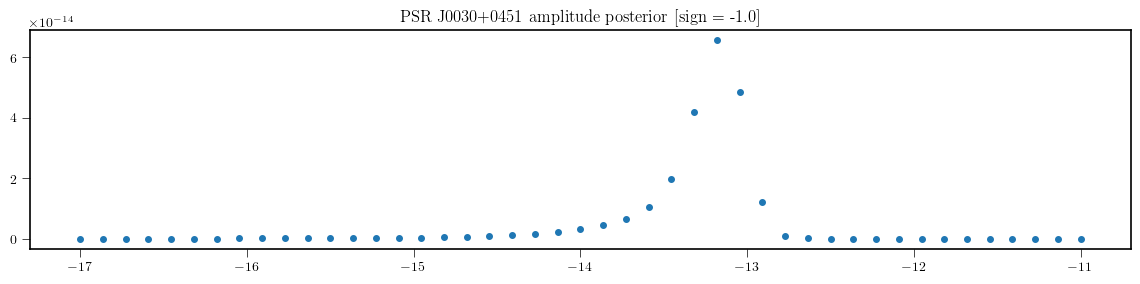

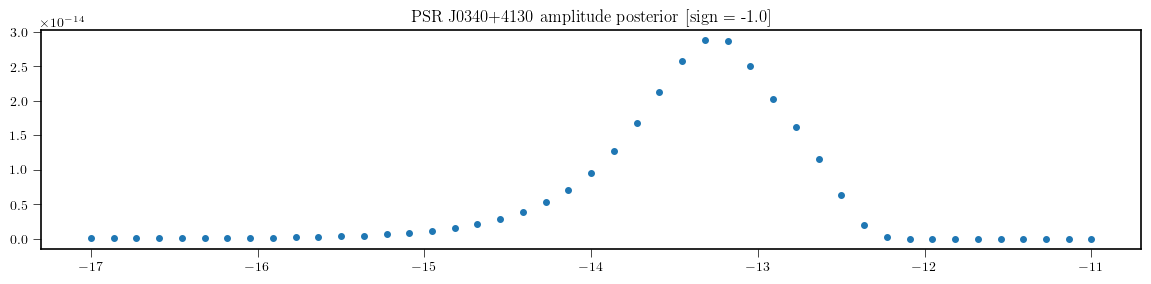

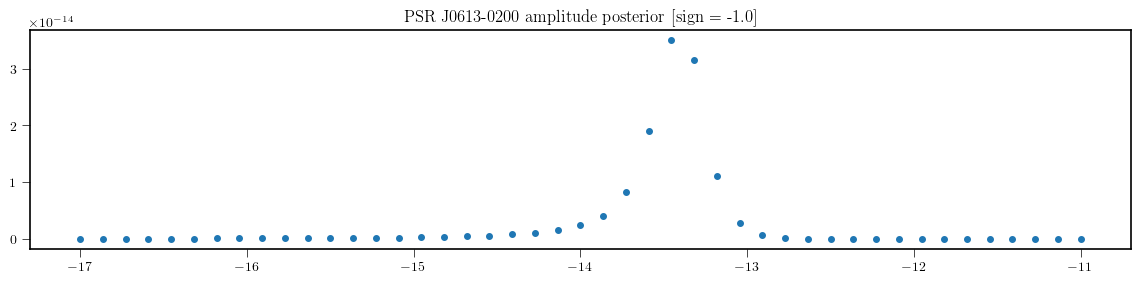

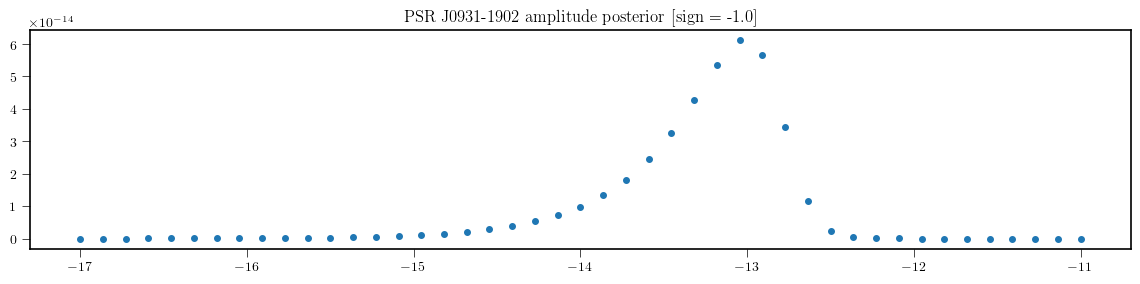

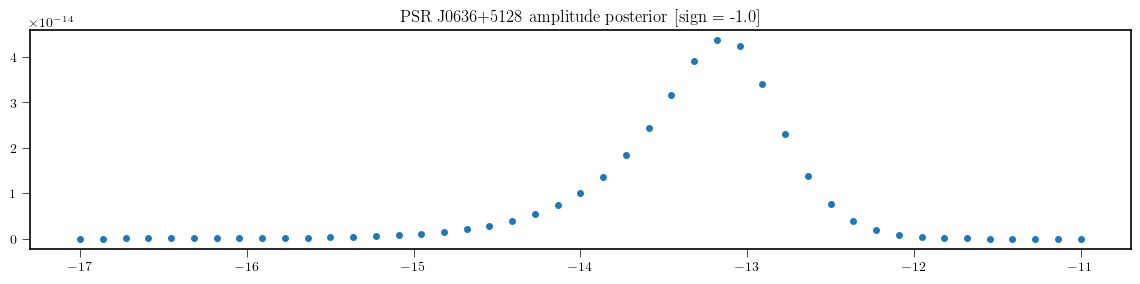

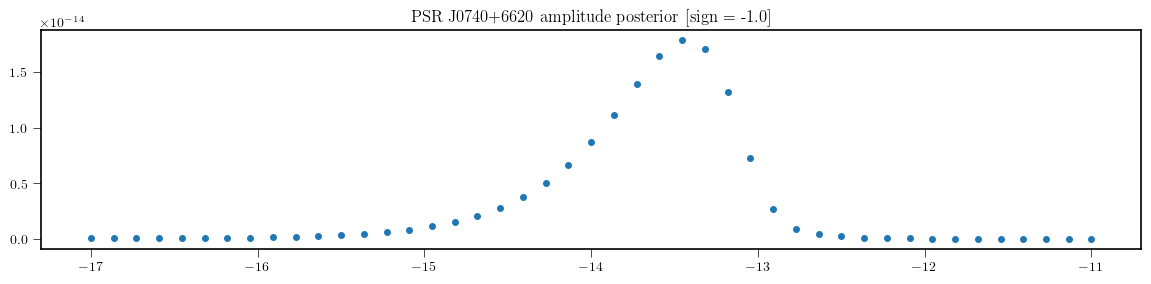

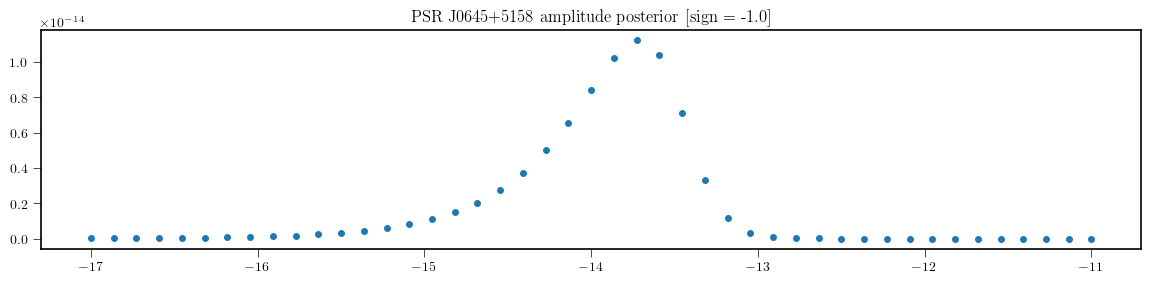

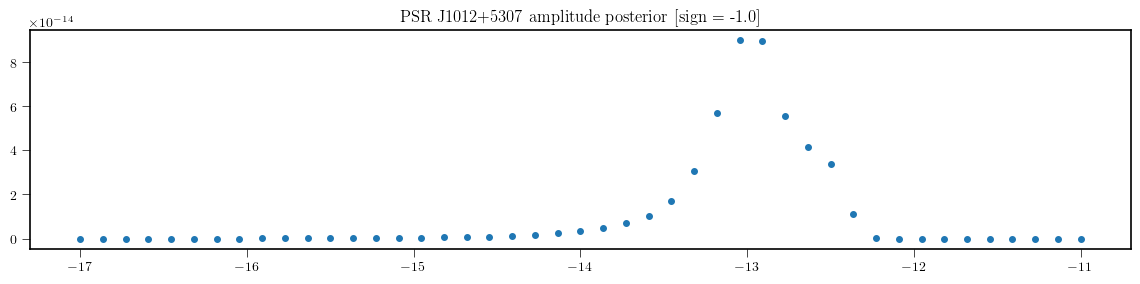

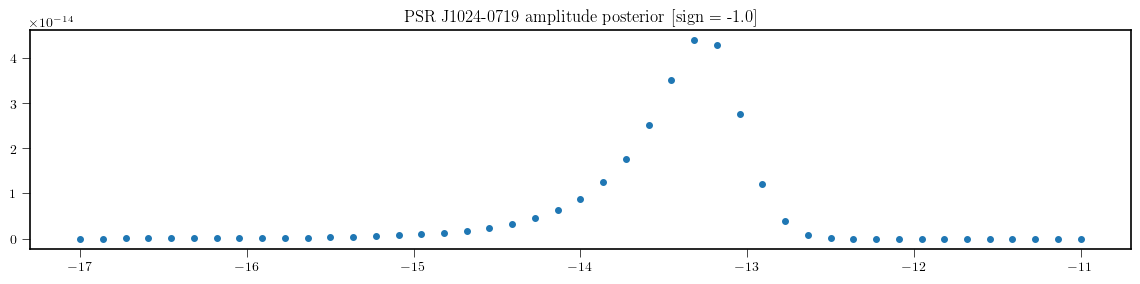

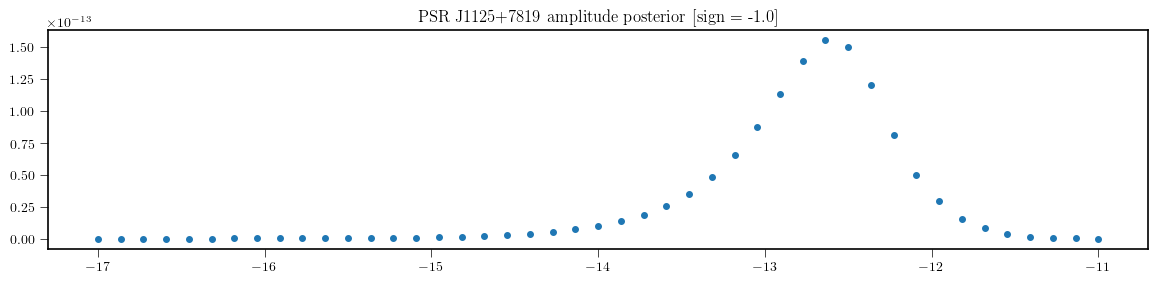

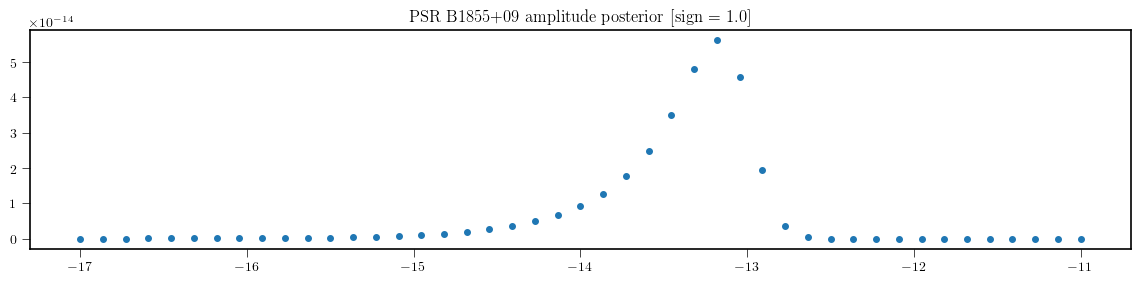

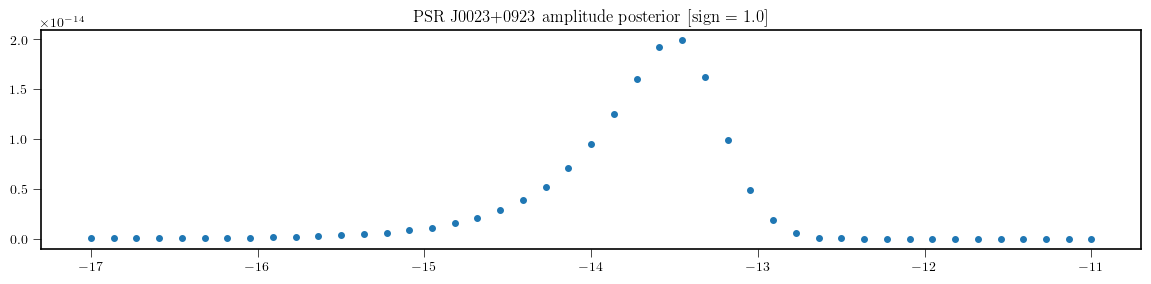

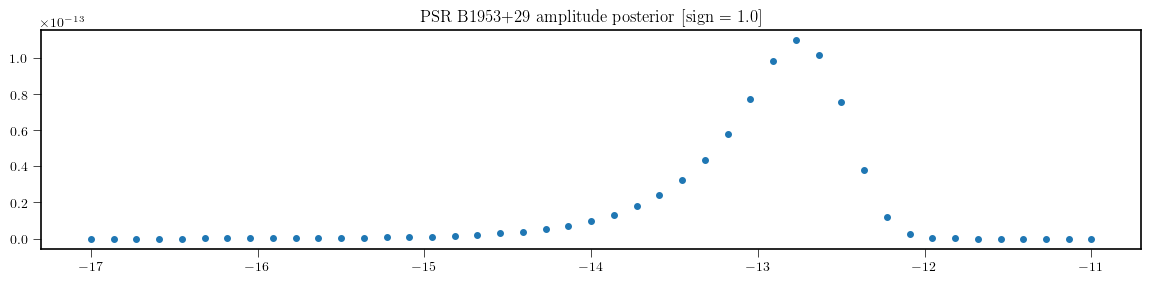

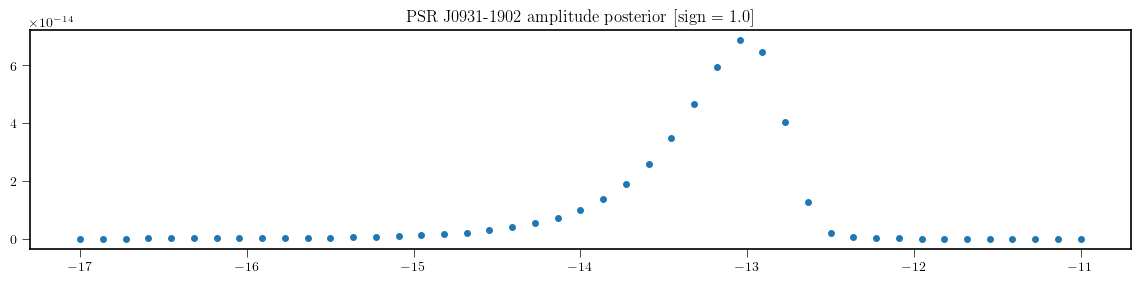

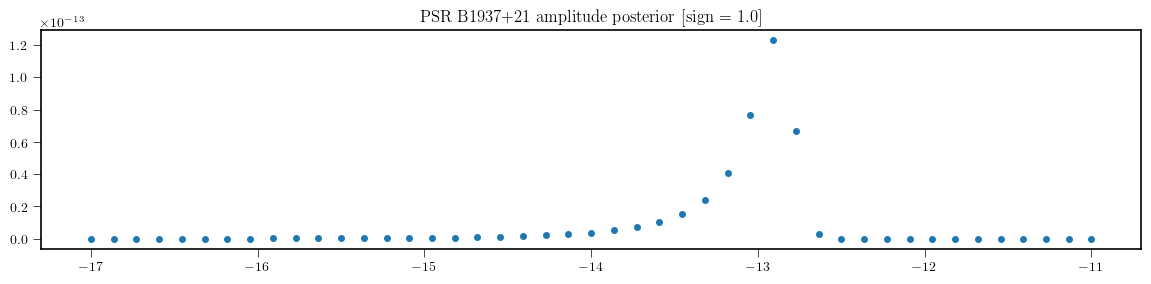

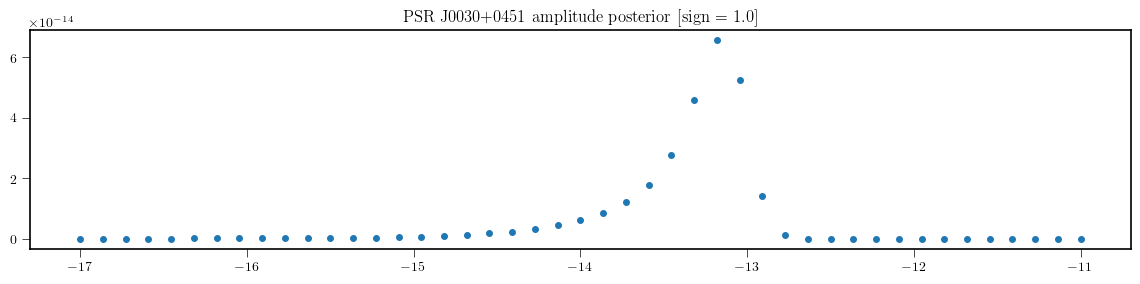

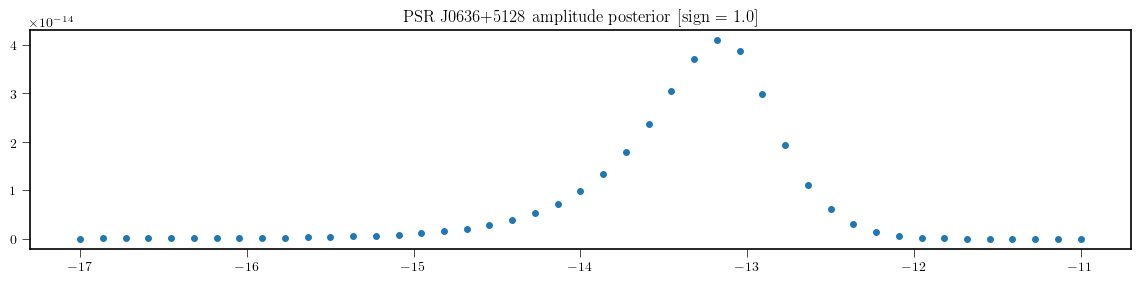

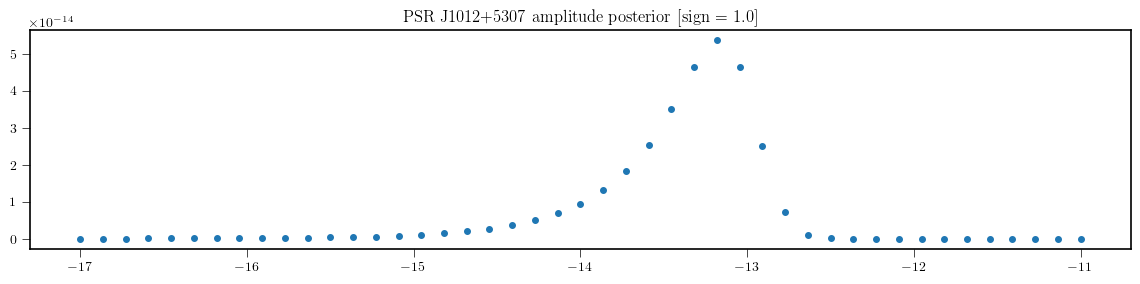

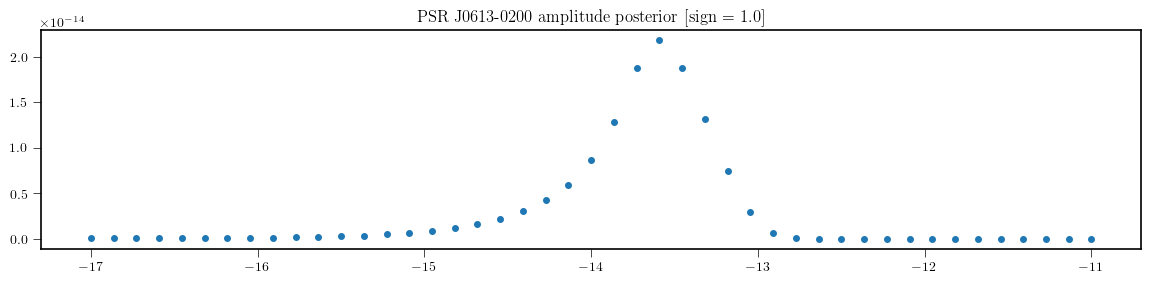

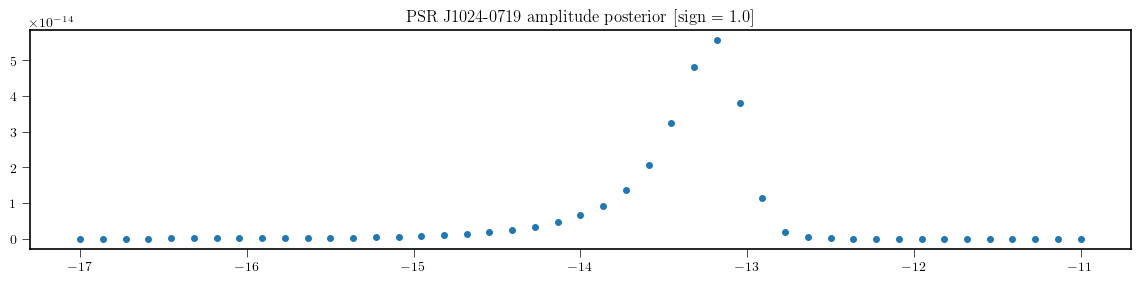

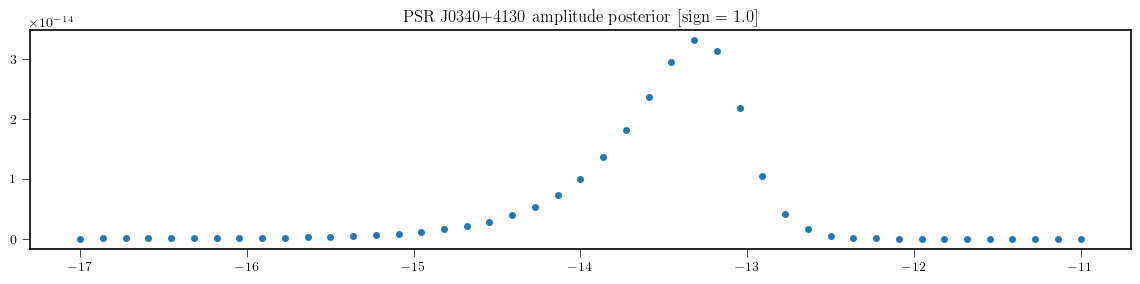

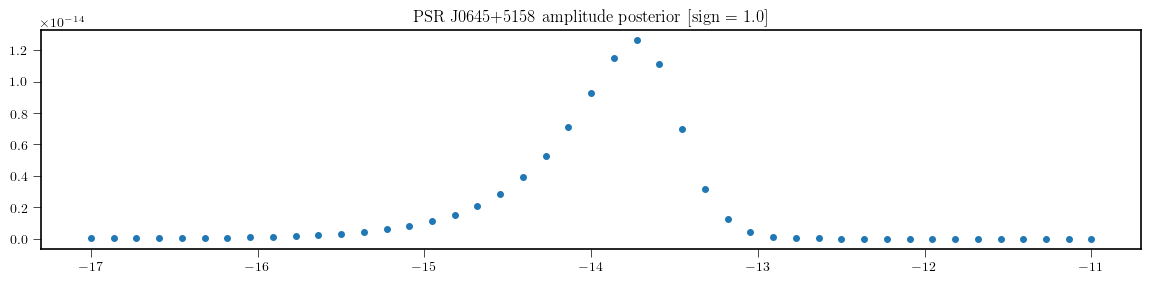

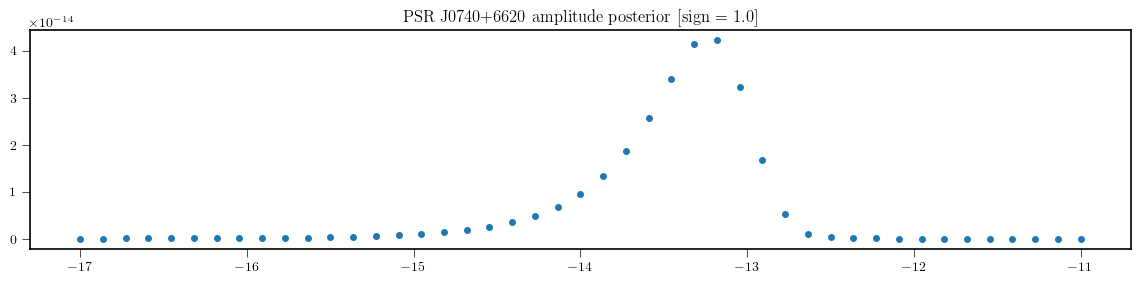

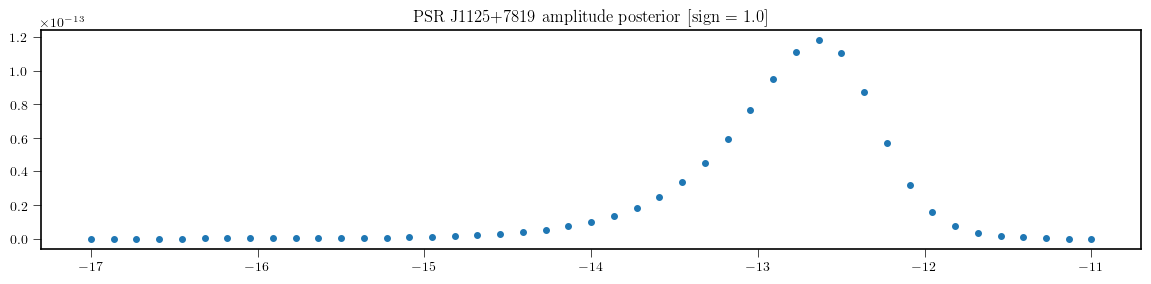

not looking for bursts between MJD 57147.874260149576 and MJD 57532.18396100427


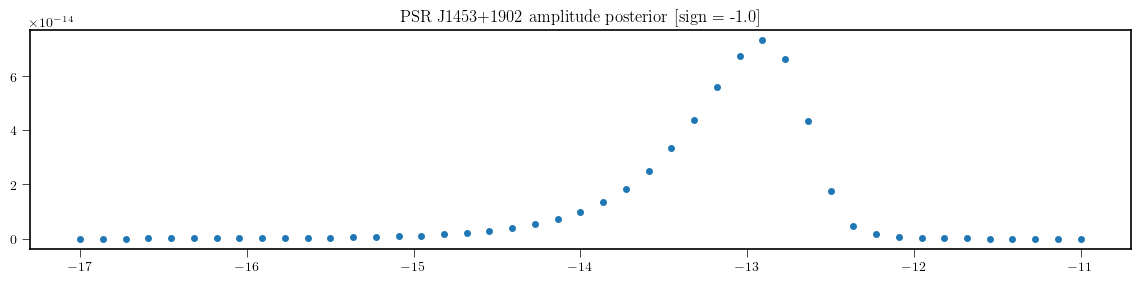

not looking for bursts between MJD 53876.87099202675 and MJD 57522.91698996913


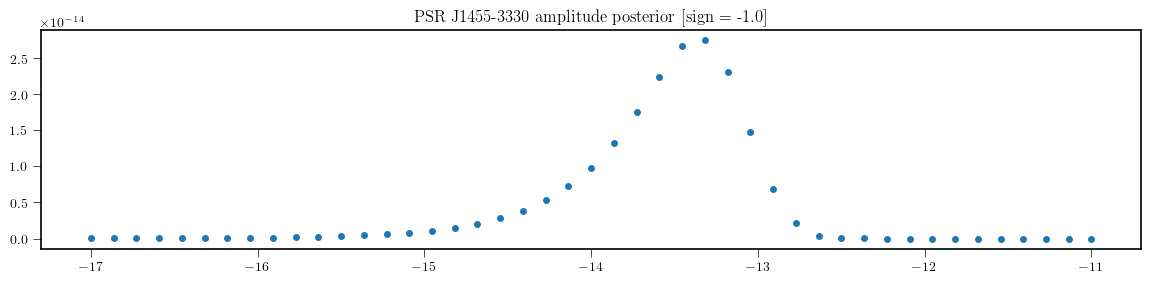

not looking for bursts between MJD 54734.306493374104 and MJD 57586.1538941981


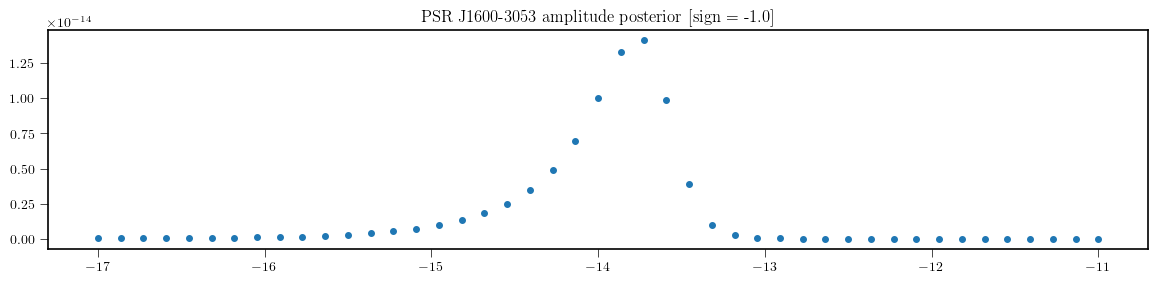

not looking for bursts between MJD 55396.844869093235 and MJD 57585.625242656446


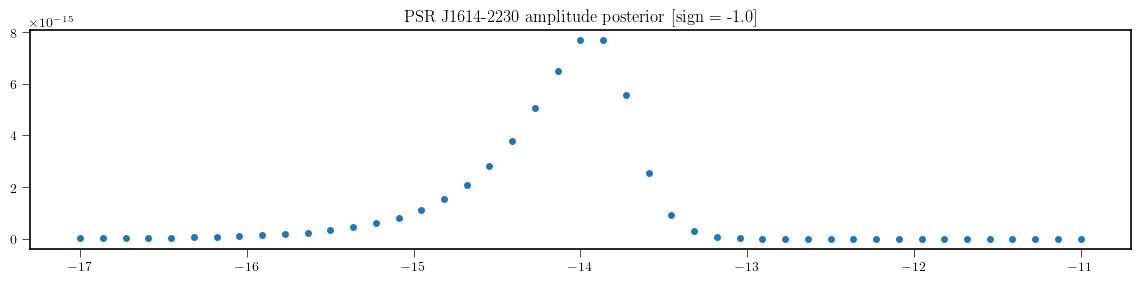

not looking for bursts between MJD 53659.448089802136 and MJD 57636.941644231985


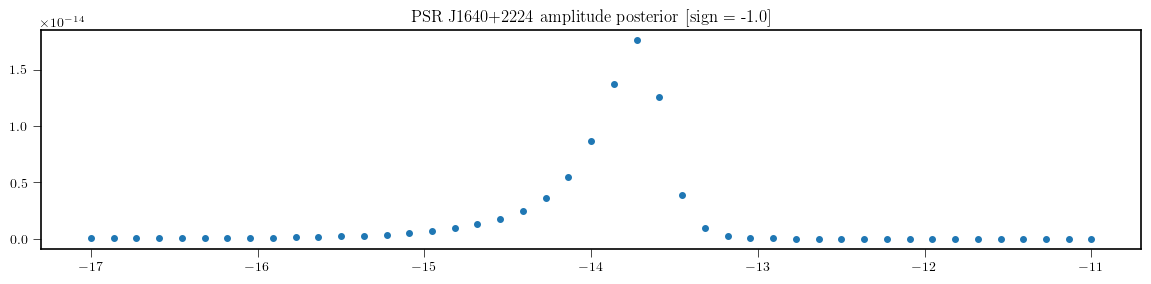

not looking for bursts between MJD 53632.72511813537 and MJD 57585.582808908046


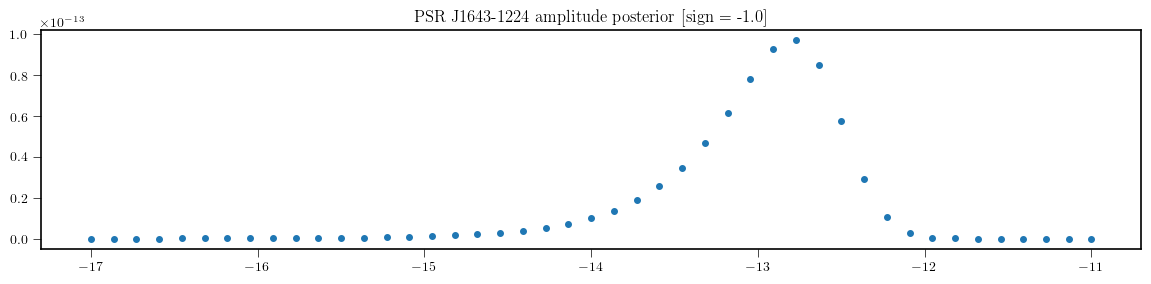

not looking for bursts between MJD 55821.956316907665 and MJD 57596.04382324962
not looking for bursts between MJD 53629.74238097472 and MJD 57649.17779427865
not looking for bursts between MJD 56062.16800600405 and MJD 57567.85007432725


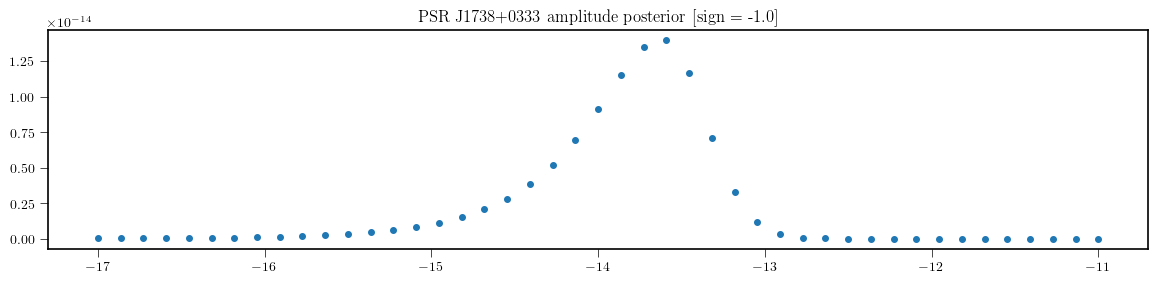

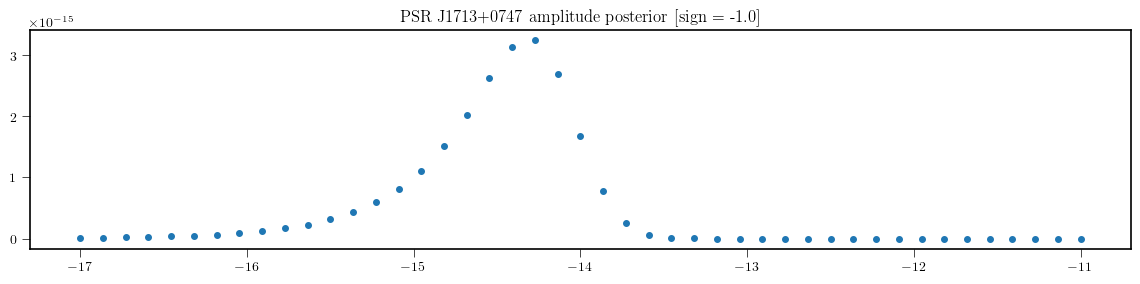

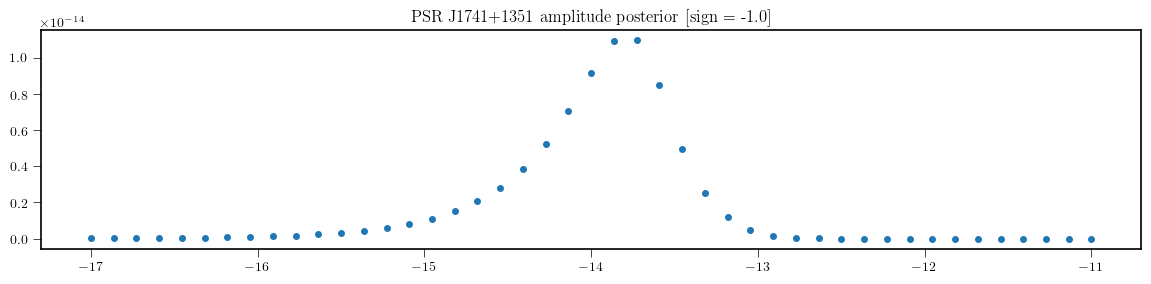

not looking for bursts between MJD 53875.9595476818 and MJD 57563.414000236546


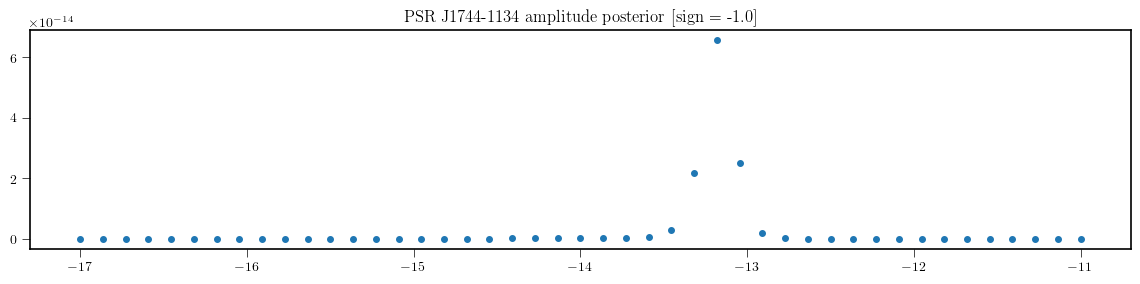

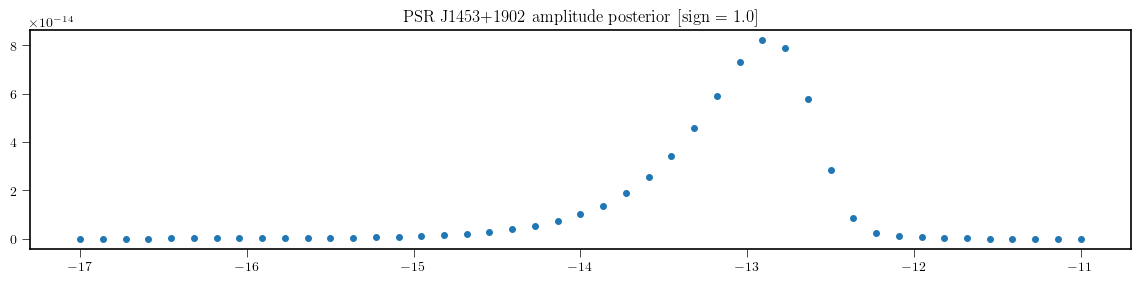

not looking for bursts between MJD 56315.51623078267 and MJD 57489.567158455626


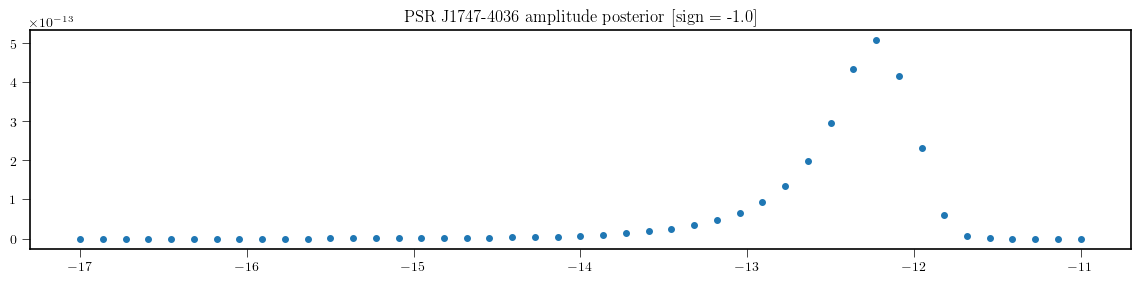

not looking for bursts between MJD 56635.027064814814 and MJD 57559.21632407407
not looking for bursts between MJD 56096.36077620968 and MJD 57535.01917712067


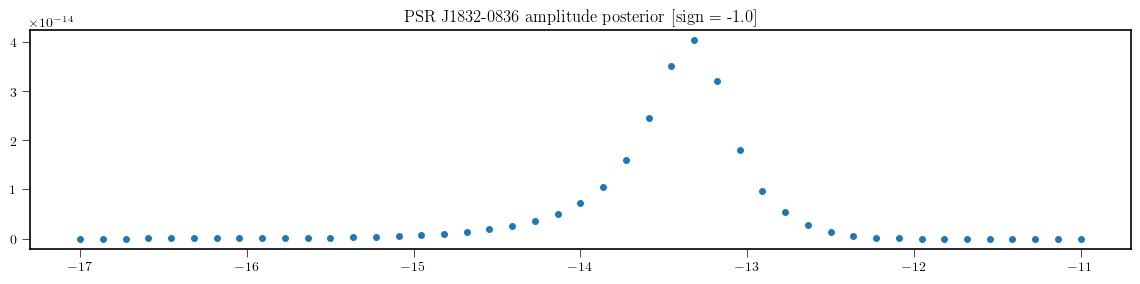

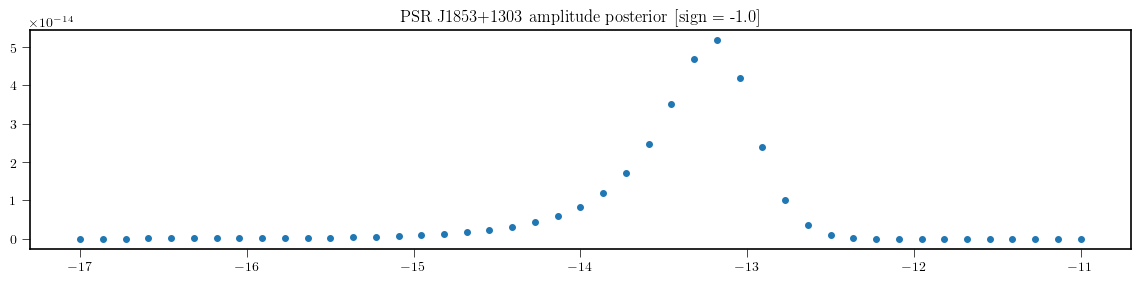

not looking for bursts between MJD 55823.22654554642 and MJD 57547.42663422666


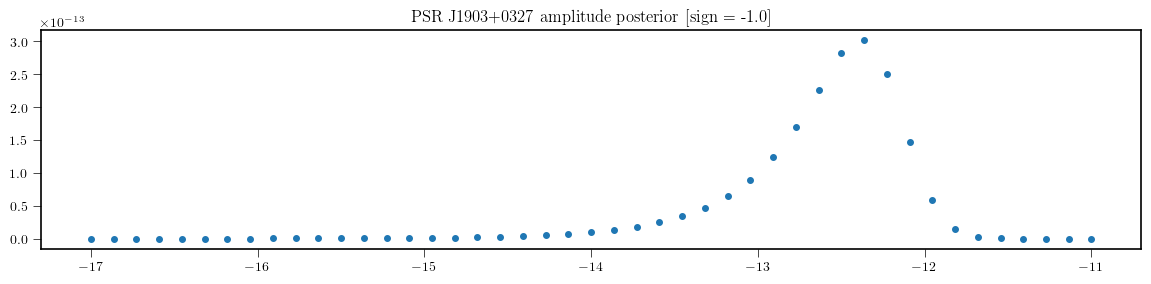

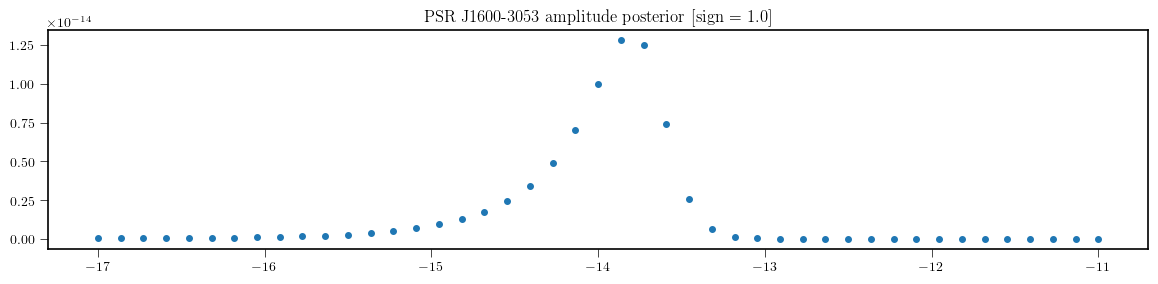

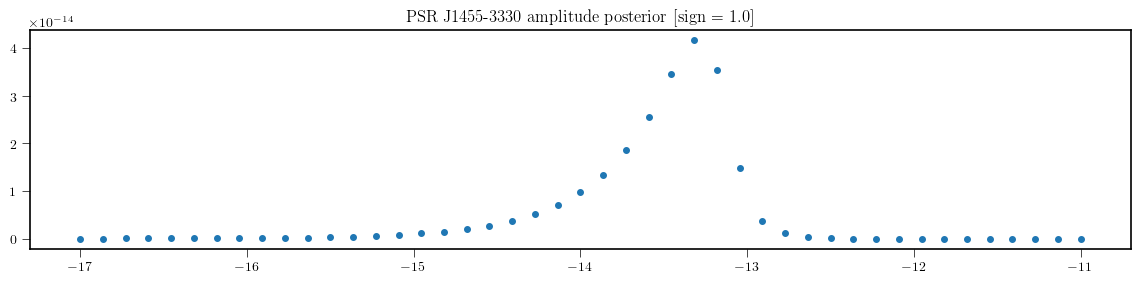

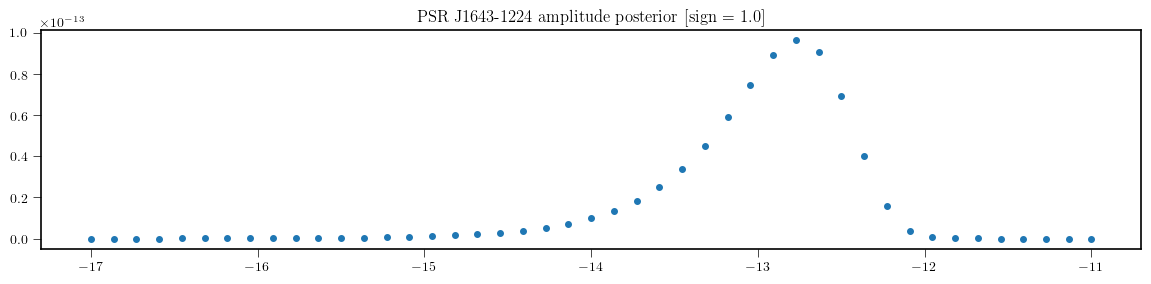

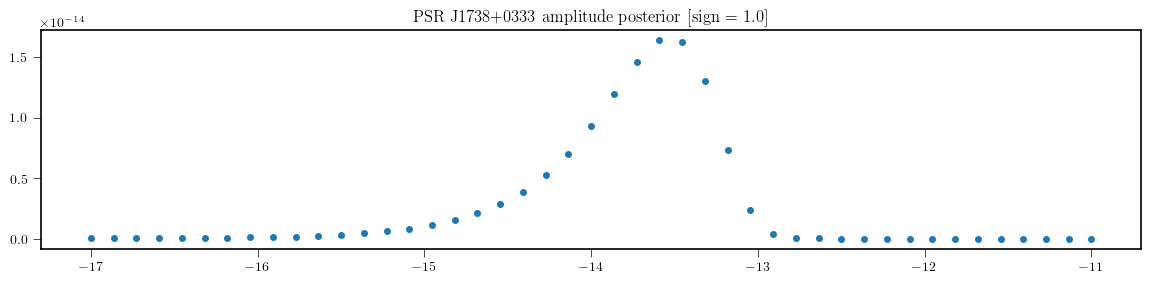

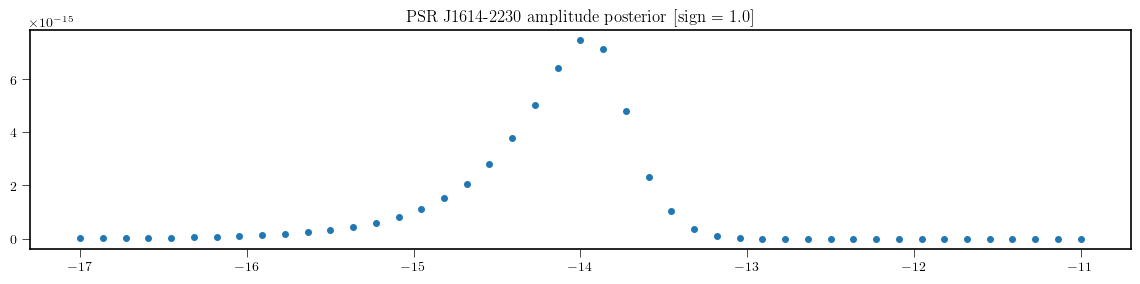

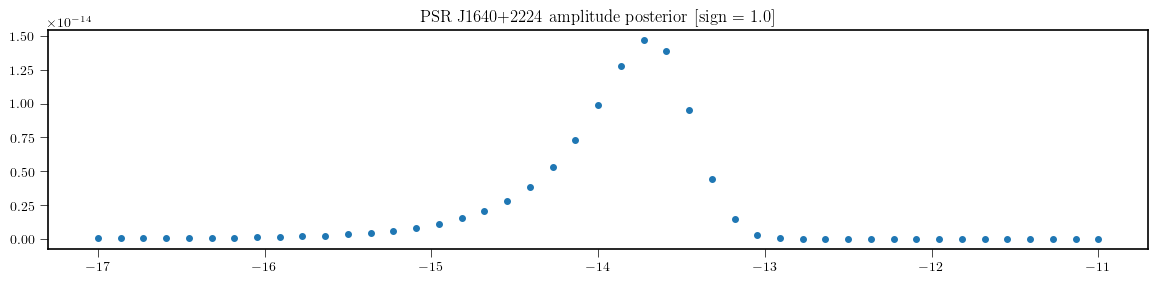

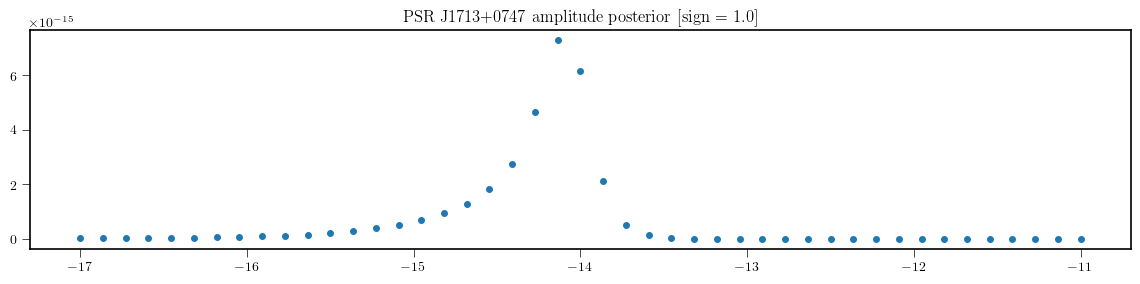

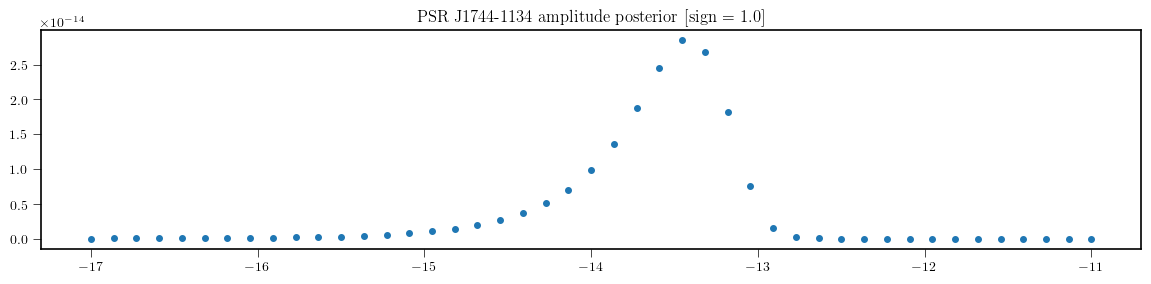

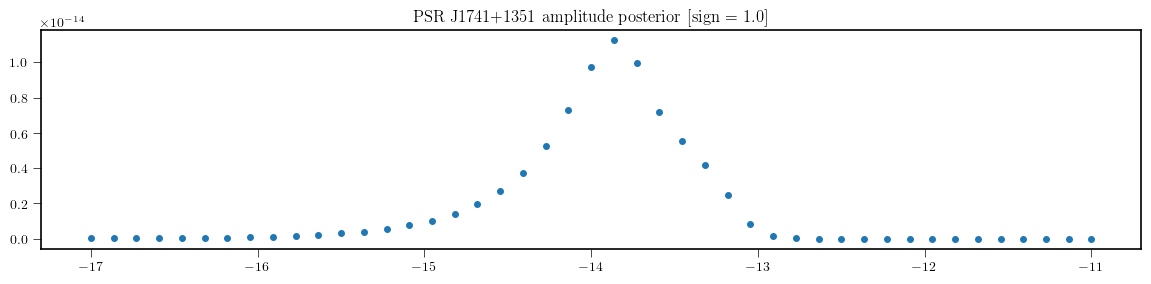

not looking for bursts between MJD 54021.93253011 and MJD 57612.512420112784


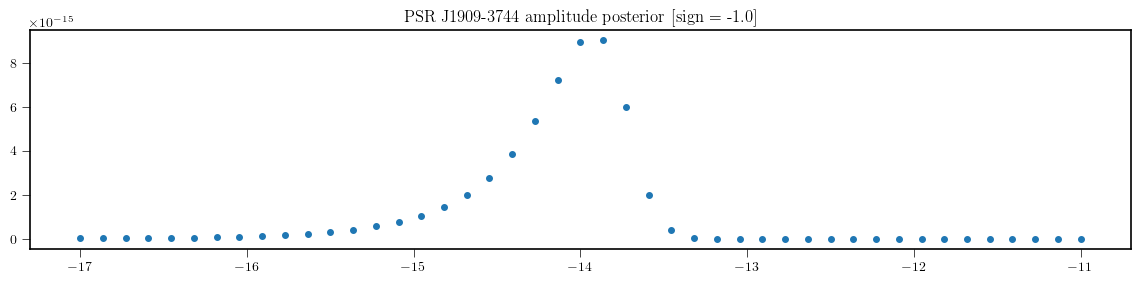

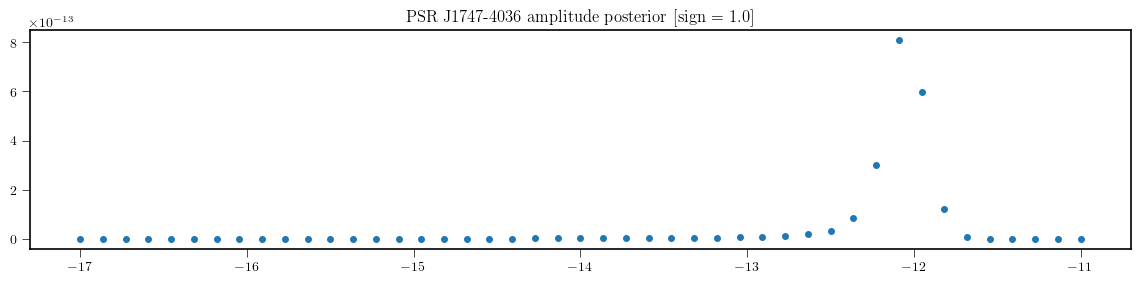

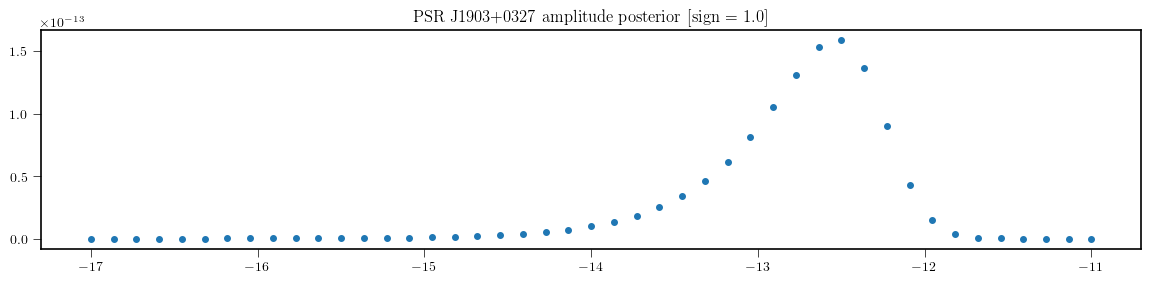

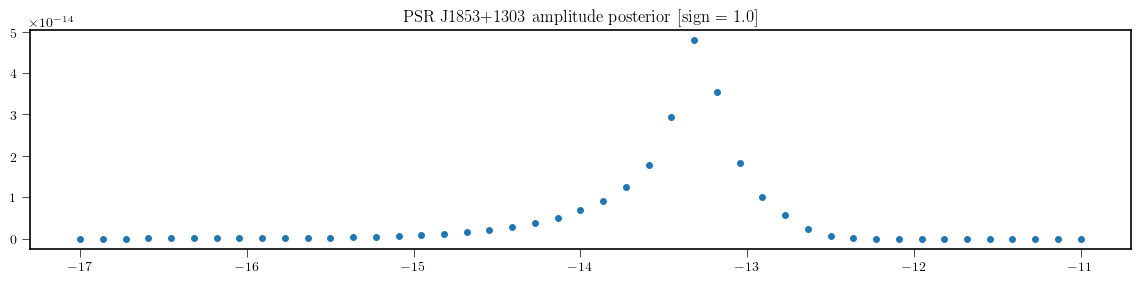

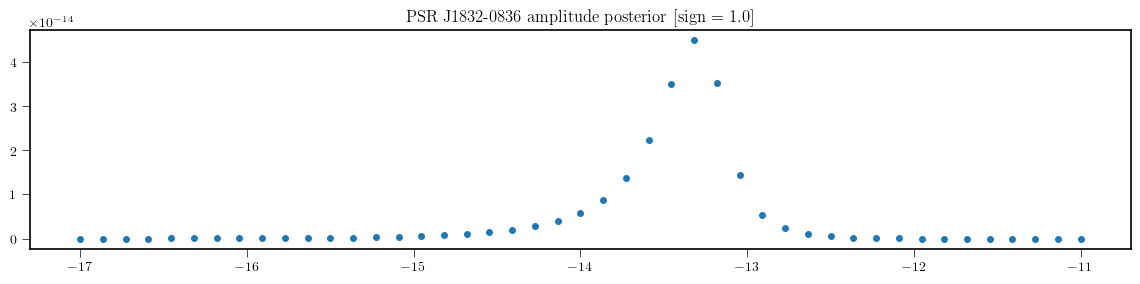

not looking for bursts between MJD 55270.41879861111 and MJD 57550.842293981485


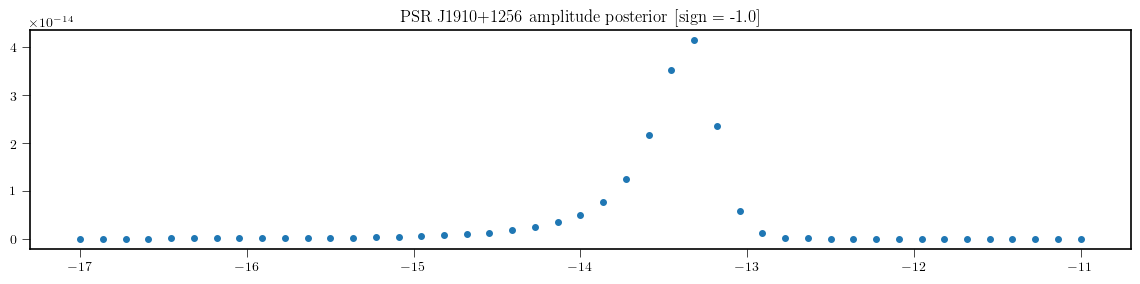

not looking for bursts between MJD 57031.23257056451 and MJD 57530.010814292116


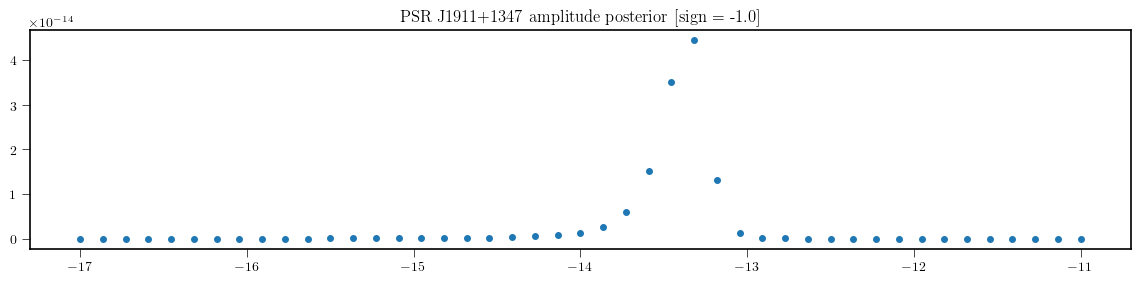

not looking for bursts between MJD 53982.19896057905 and MJD 57586.93878714069


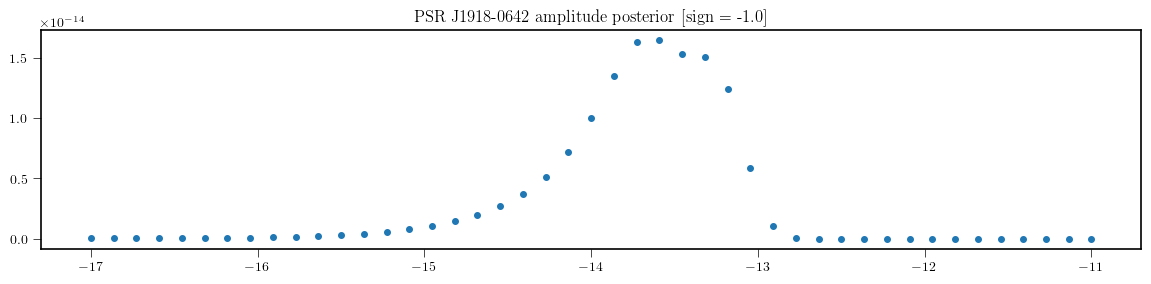

not looking for bursts between MJD 56118.551205357144 and MJD 57589.572422288365


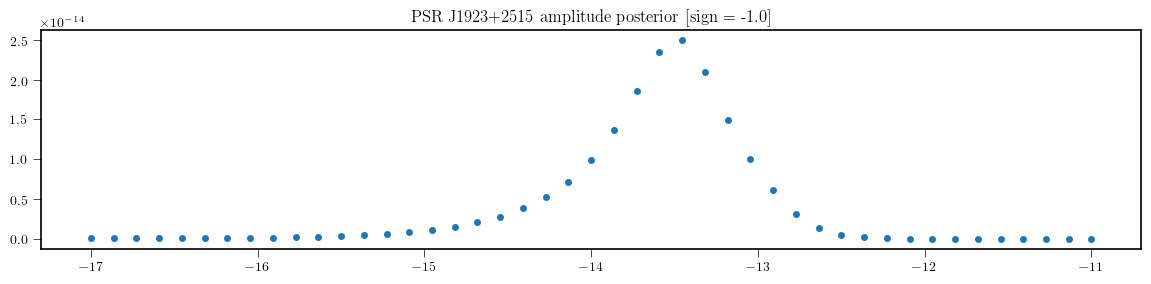

not looking for bursts between MJD 56003.888691077445 and MJD 57575.18697495792


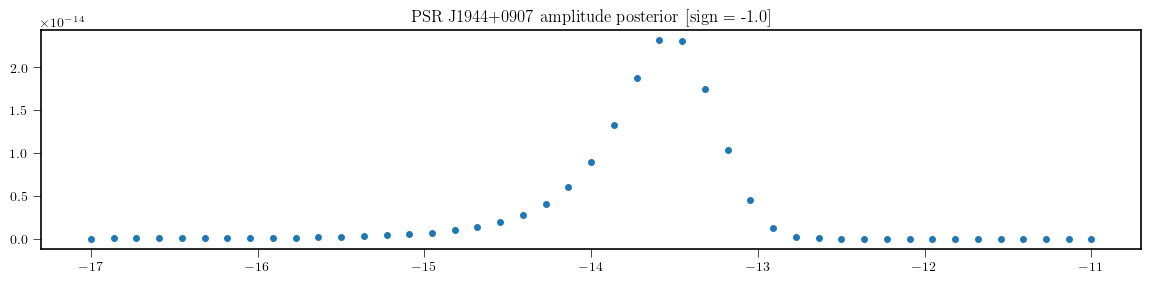

not looking for bursts between MJD 55426.601103077344 and MJD 57562.87610580066


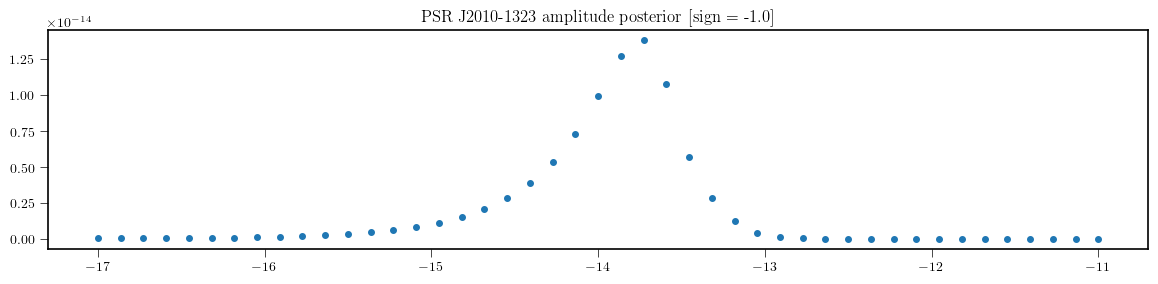

not looking for bursts between MJD 56374.46487268518 and MJD 57493.02528935185
not looking for bursts between MJD 57032.40514448925 and MJD 57539.41321497909


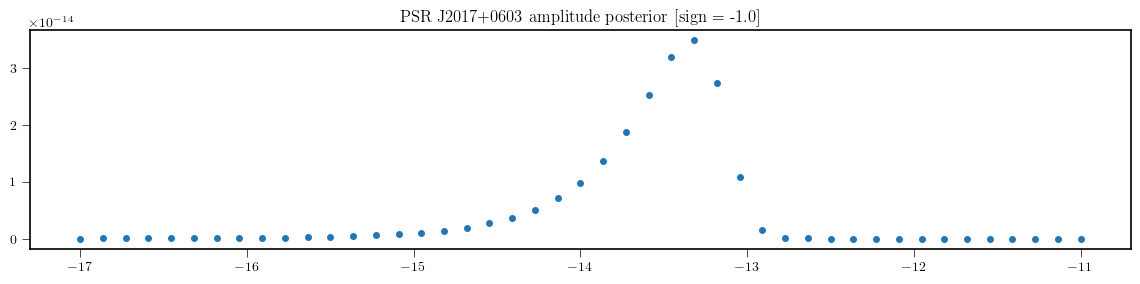

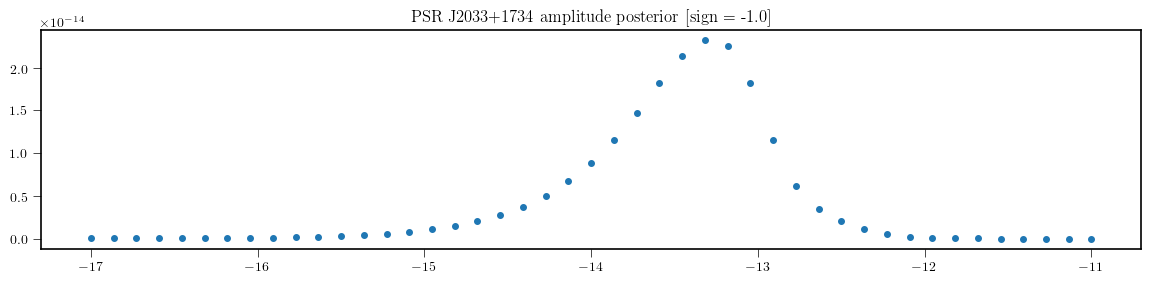

not looking for bursts between MJD 56120.24437644676 and MJD 57626.70666449653


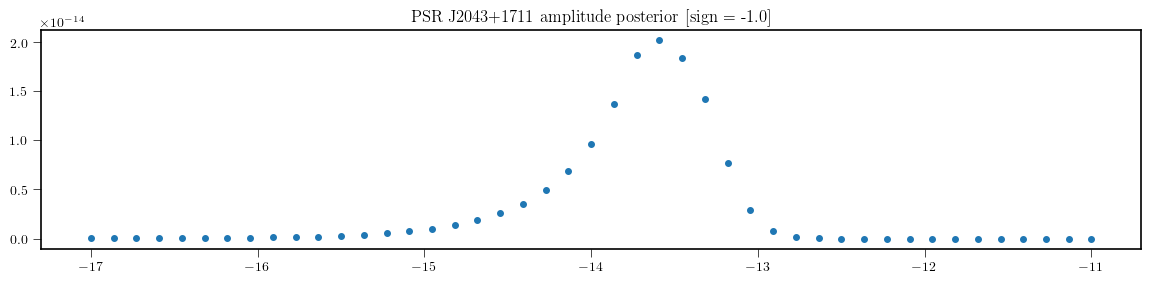

not looking for bursts between MJD 53537.38134538901 and MJD 57588.41853747203


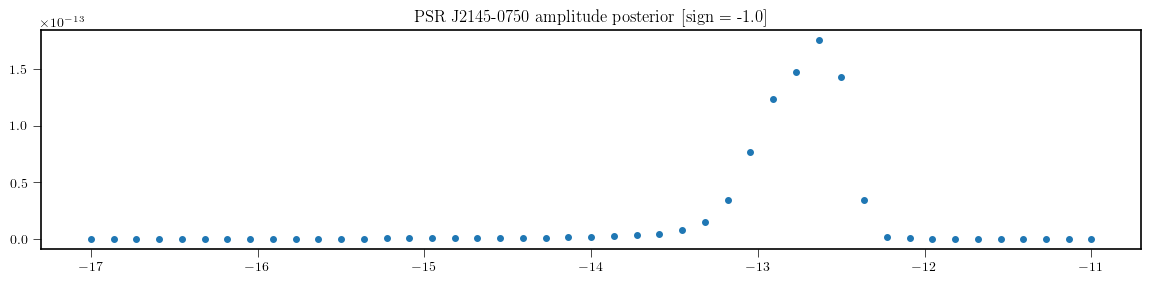

not looking for bursts between MJD 56206.67968237705 and MJD 57610.724492638125


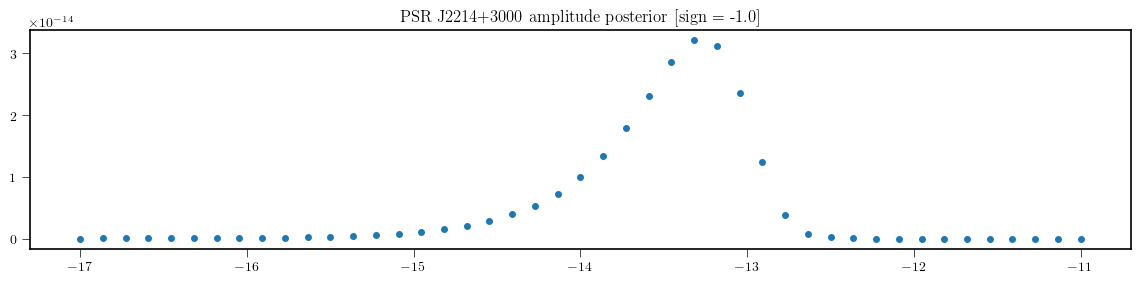

not looking for bursts between MJD 57056.04584056713 and MJD 57585.33158058448


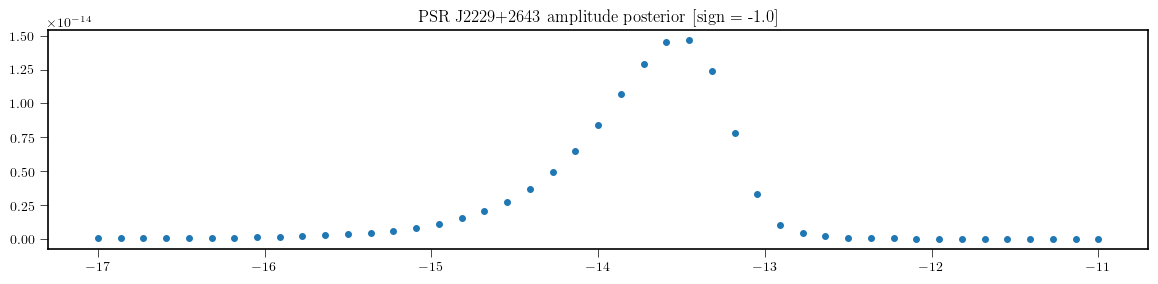

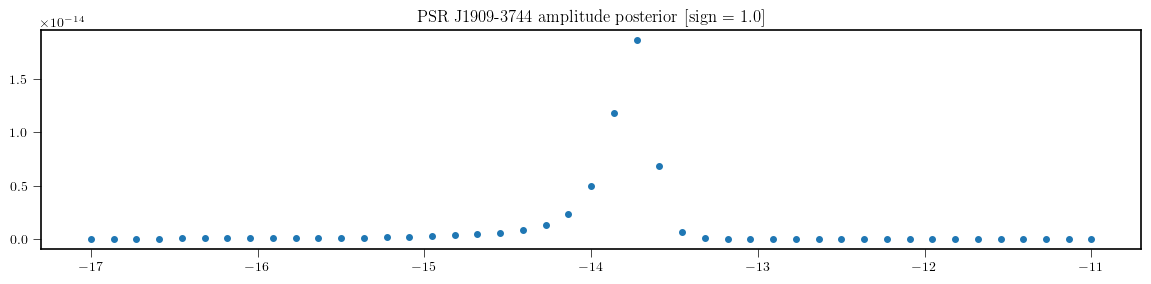

not looking for bursts between MJD 57059.55249537037 and MJD 57569.60044598765


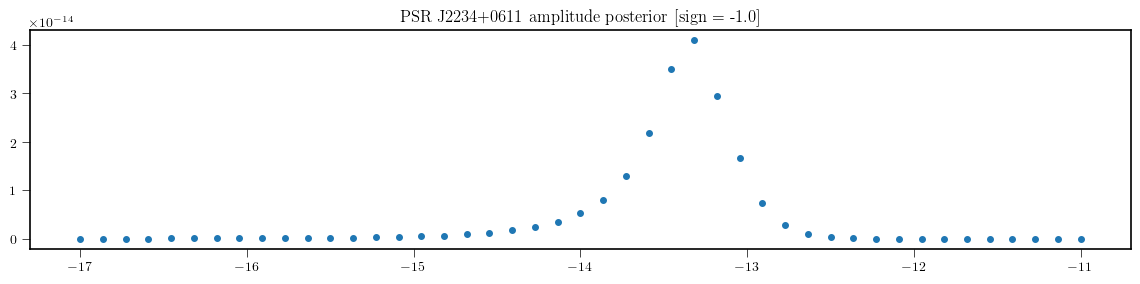

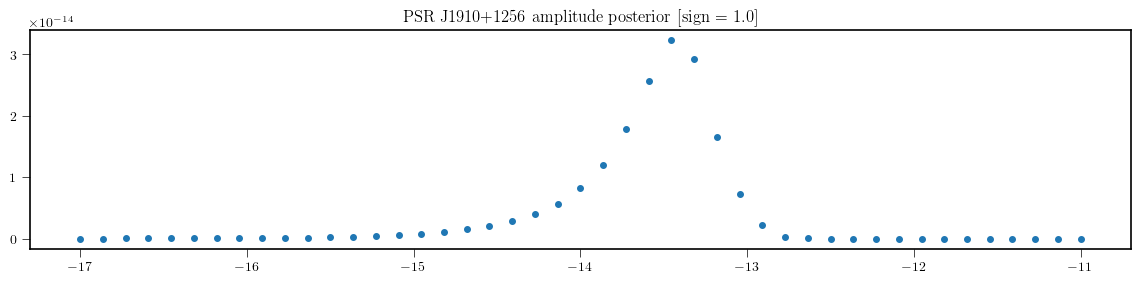

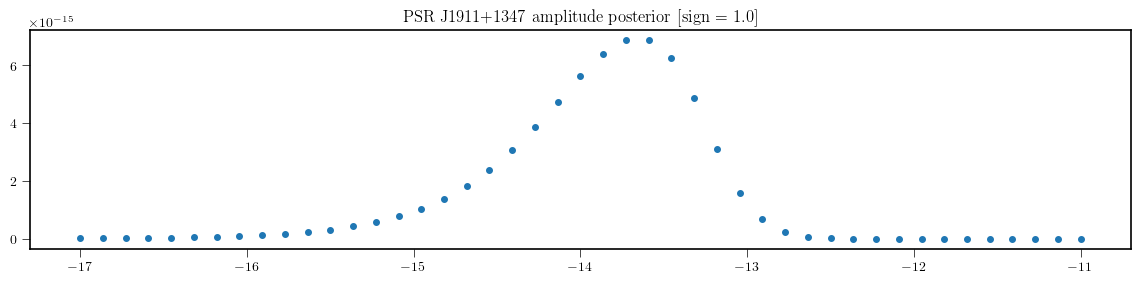

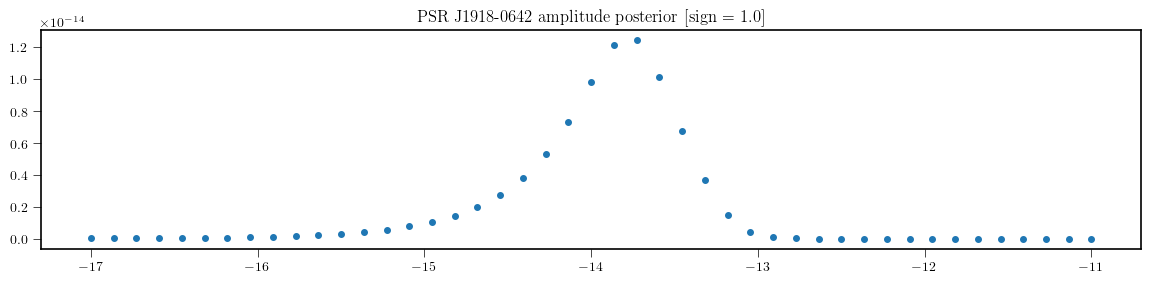

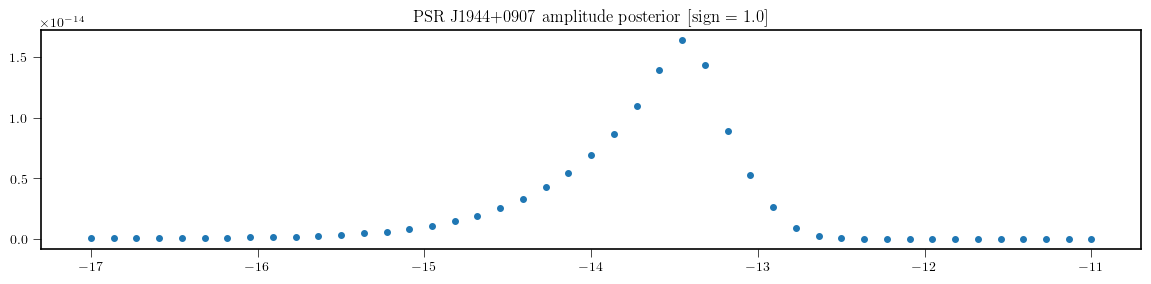

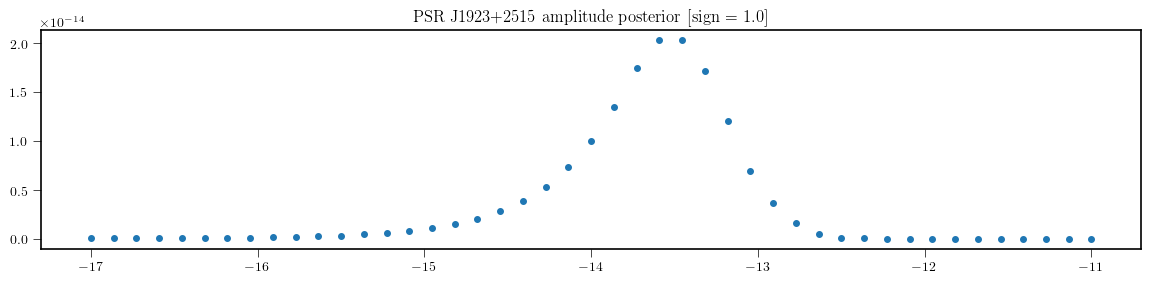

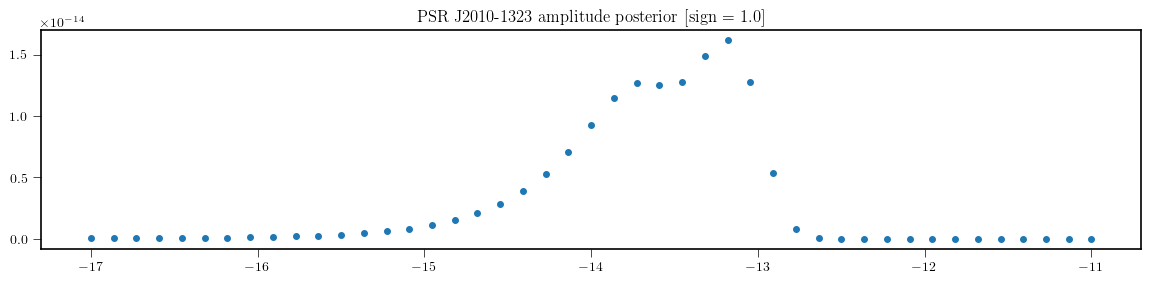

not looking for bursts between MJD 56722.99972853535 and MJD 57616.27276252105


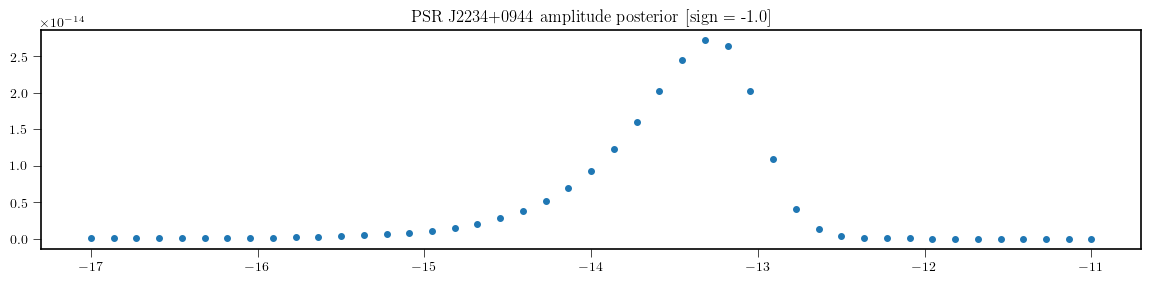

not looking for bursts between MJD 56332.944297348484 and MJD 57555.806511153205


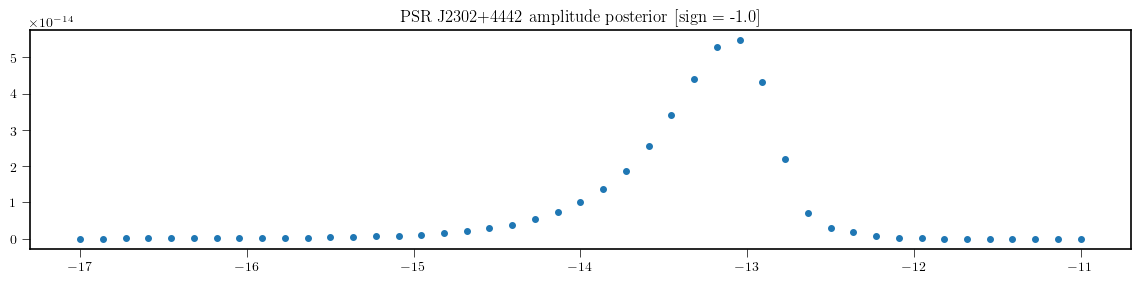

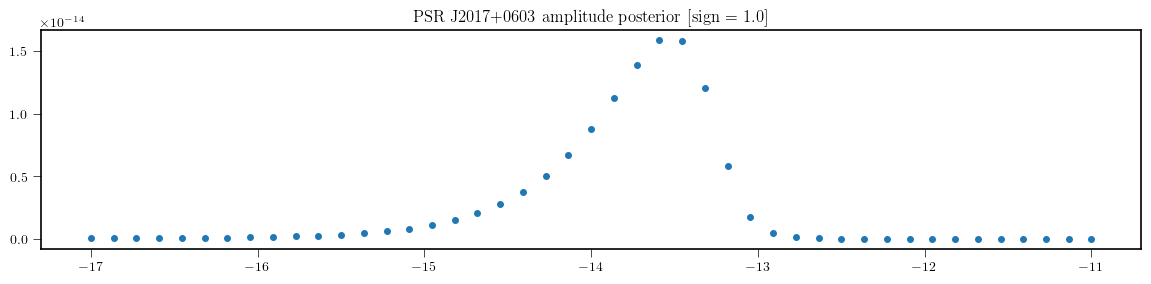

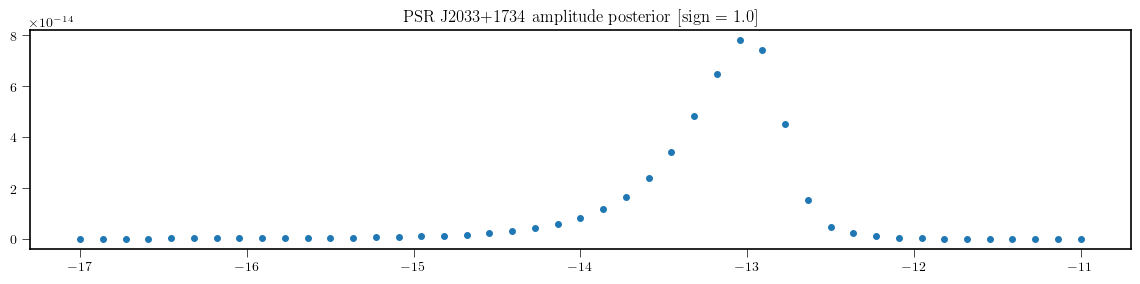

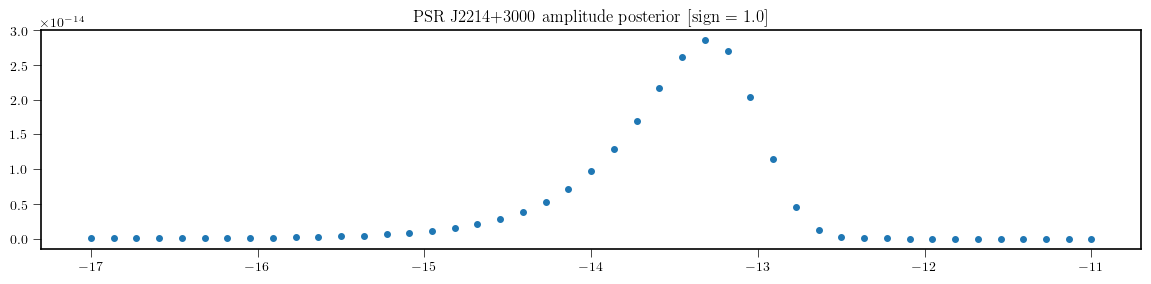

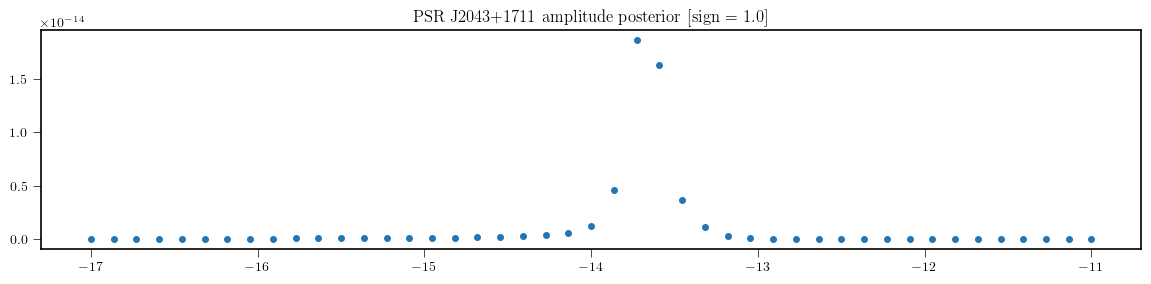

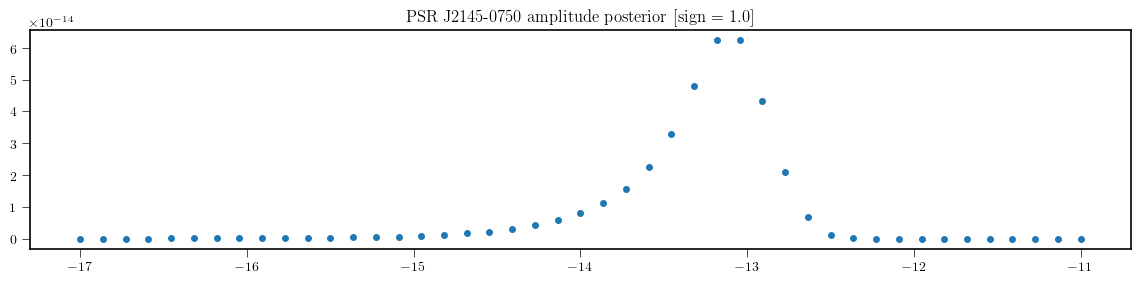

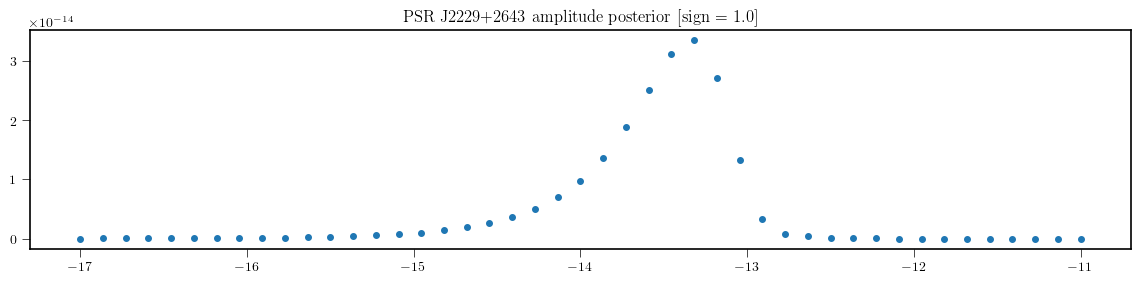

not looking for bursts between MJD 53540.18774212962 and MJD 57641.99813796296


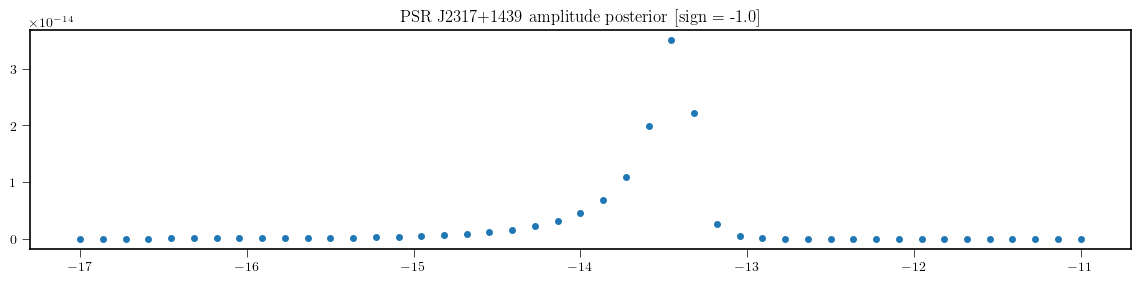

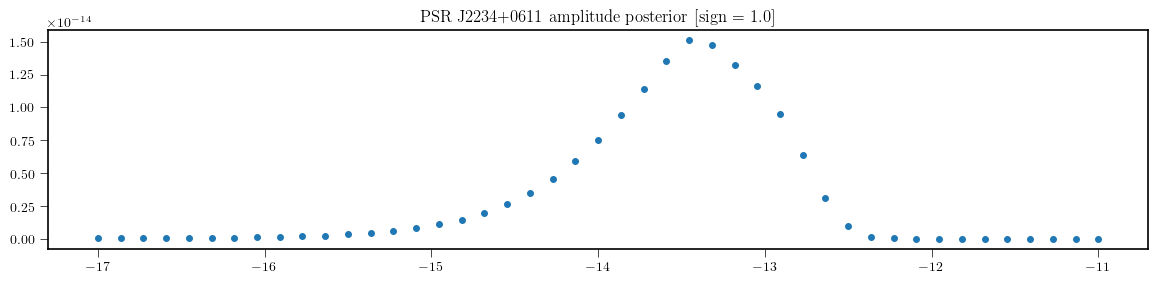

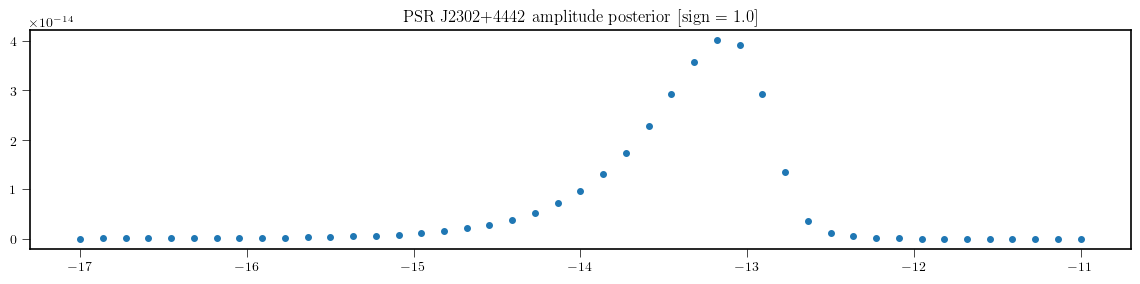

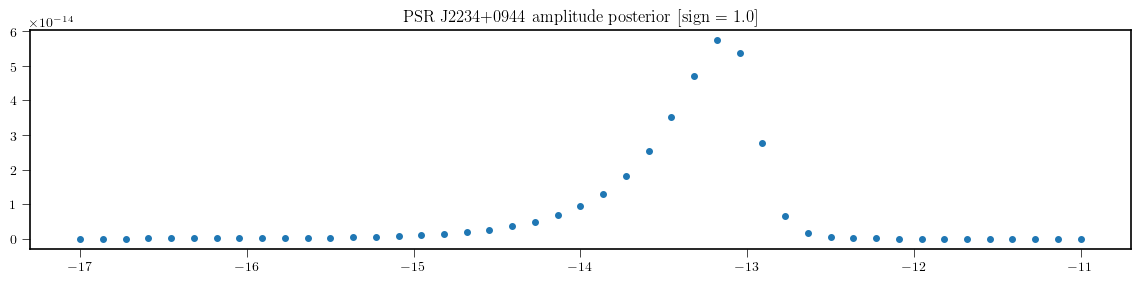

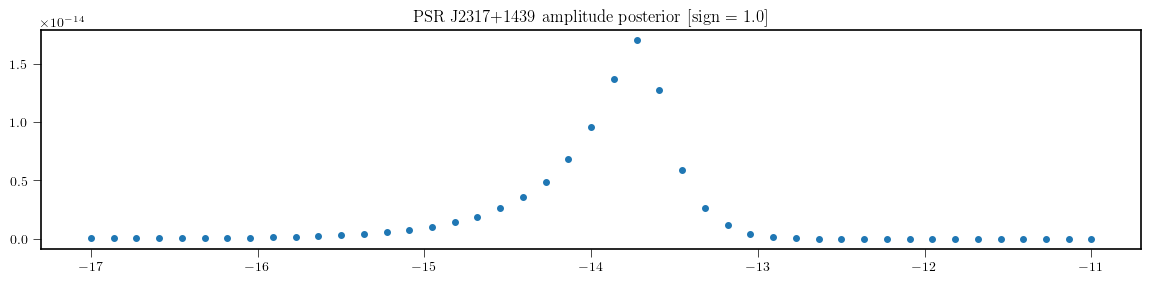

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [5]:
def resample_180day_cutoff_worker(psr, sample=True):
    partial_outdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/resampled_amps/{}/'.format(psr.name)
    if not os.path.exists(partial_outdir):
        os.mkdir('/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/resampled_amps/')
    
    if not os.path.exists(partial_outdir):
        os.mkdir(partial_outdir)

    lookupdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/{}/'.format(psr.name)

    looktable_path = lookupdir + '{}_lookup.txt'.format(psr.name, psr.name)
    looktable = np.loadtxt(looktable_path)

    parfile = lookupdir + 'pars.txt'.format(psr.name)
    with open(parfile, 'r') as f:
        parlines=f.readlines()

    pardict = {}
    for parline in parlines:
        key, np_pars = parline.split(';')

        start,stop,num = np_pars.split(',')
        pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
        #print(pardict)
    lookup_shape = (len(pardict['ramp_log10_A']), len(pardict['ramp_t0']), len(pardict['sign'])) #let's do this intelligently

    reshaped_looktable = np.reshape(looktable, lookup_shape, order='F')
    #         print(reshaped_looktable.shape)

    amps = pardict['ramp_log10_A']
    t0s = pardict['ramp_t0']
    signs = pardict['sign']




    tmin_mjd_lim = t0s[0] + 180
    tmax_mjd_lim = t0s[-1] - 270

    tmin_idx = np.argmin(np.abs(t0s - tmin_mjd_lim)) 
    tmax_idx = np.argmin(np.abs(t0s - tmax_mjd_lim))

    tmin_mjd = t0s[tmin_idx]
    tmax_mjd = t0s[tmax_idx]


    print("not looking for bursts between MJD {} and MJD {}".format(tmin_mjd, tmax_mjd))
    cols = np.arange(tmin_idx, tmax_idx)

    log10_A_post = np.zeros(len(amps)) 
    for sign_idx, sign in enumerate(signs):
        for log10A_idx in range(len(log10_A_post)):
            submtx_max = np.amax(reshaped_looktable[log10A_idx, :, sign_idx])
            #print(submtx_max)
            #print(np.amin(reshaped_looktable[log10A_idx, :, :]))
            this_l10A_likes = np.zeros(len(cols)) # populate a grid to integrate over to find the
                                                 # epoch-averaged likelihood for this amplitude


            for ii, t0_idx in enumerate(cols):
                # need to add them all into this_l10A_like
                #if reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max > 10:
                #    print("Large likelihood diff")
                like = np.exp(reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max)
                corrected_like = like # no amplitude factor bc integrating over t0
                this_l10A_likes[ii] = corrected_like

            # only need to integrate over the bounds of my custom columns  
            this_l10A_like = spint.simpson(y=this_l10A_likes, x=t0s[cols[0]:cols[-1]+1])
            log10_A_post[log10A_idx] = np.log(this_l10A_like) + submtx_max


        #post-process the log10_amps
        reduced_post=log10_A_post - np.amax(log10_A_post)
        post = np.exp(reduced_post)    
        for amp_idx, amp in enumerate(amps):
            post[amp_idx] = 10**amp * post[amp_idx]

        outfile = partial_outdir + '{}days_{}.txt'.format(180, sign)
        plt.scatter(amps, post, )
        plt.title("PSR {} amplitude posterior [sign = {}]".format(psr.name, sign))
        plt.show()
        plt.close()
        if sample:
            # now build the resampled thing and write it to disk
            resampled = sample_hist(post, amps, num_points = 10000,)
            np.savetxt(outfile, resampled)
            #result_dict[sign] = resampled
        #return result_dict

pool = mp.Pool(processes=14)
pool.map(resample_180day_cutoff_worker,allpsrs)

## why 0340 look different in detRN

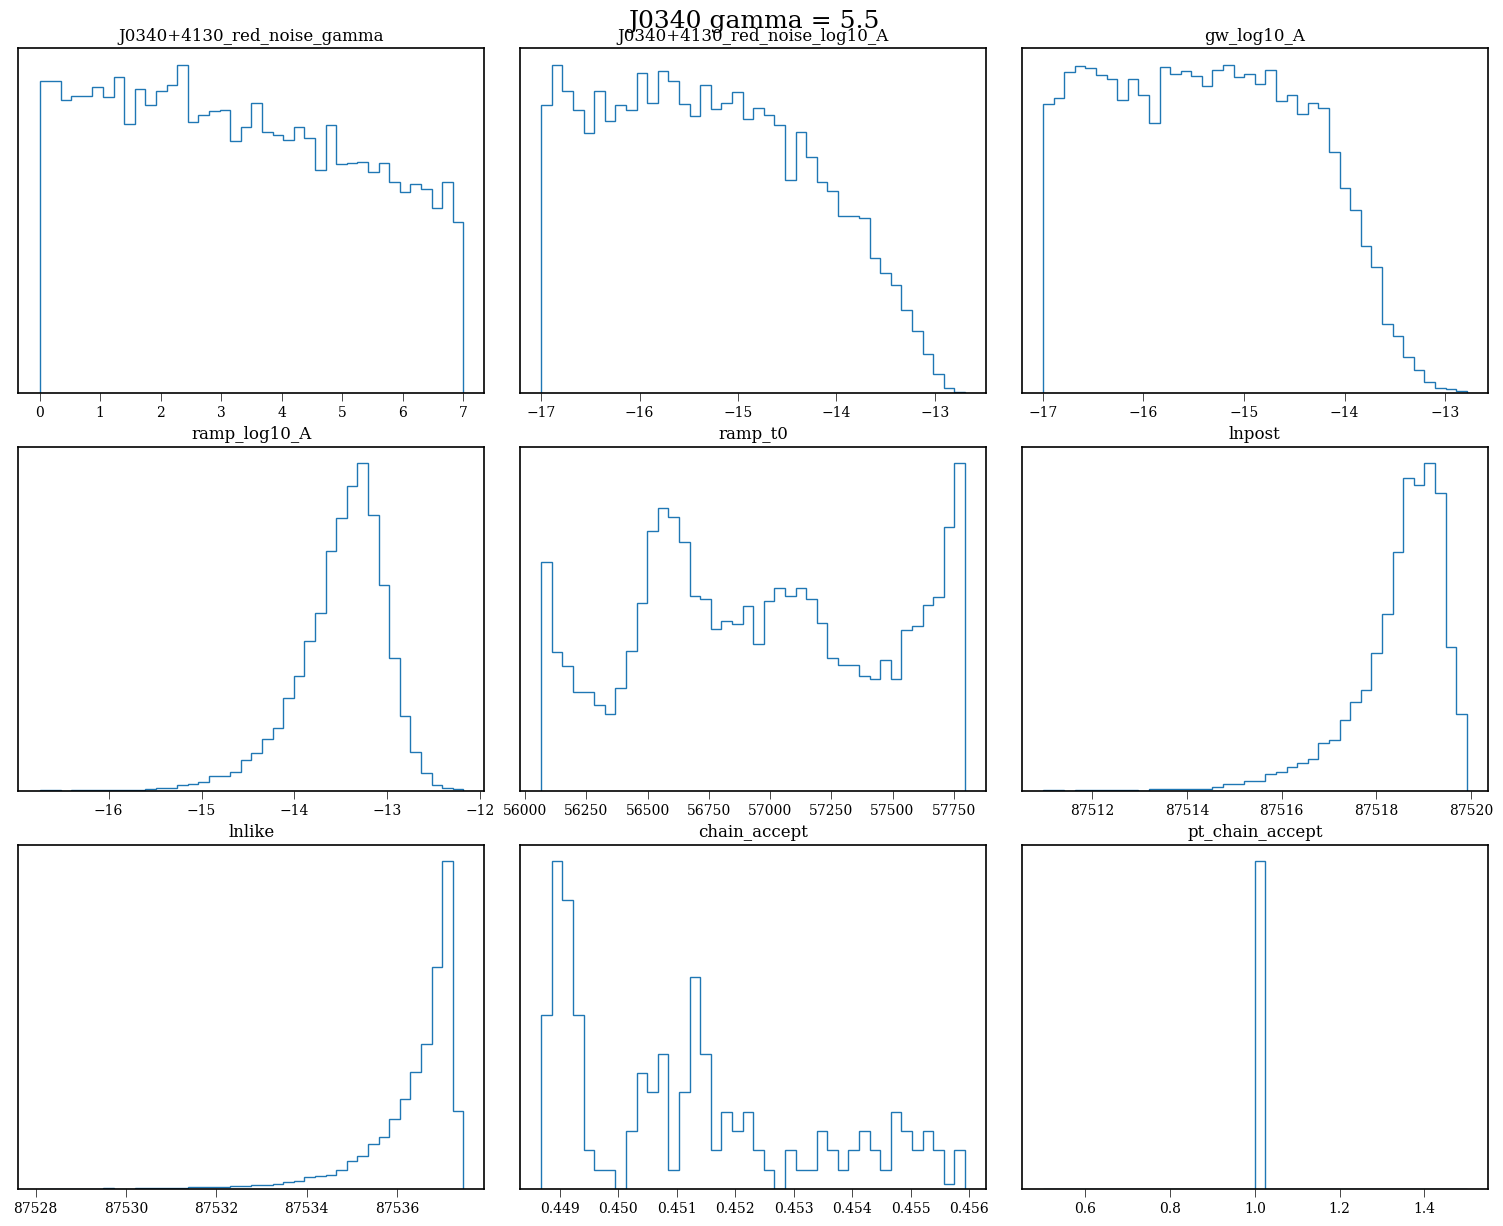

/home/nima/anaconda3/envs/nano15/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [14]:
plt.rcParams.update(plotchain_params)


chaindir = '/home/nima/nanograv/12p5yr_bwm/bayesian_verification_gw_detection/J0340+4130_1/'
J0613_mapgamma_core = Core(chaindir=chaindir)
plot_chains(J0613_mapgamma_core, suptitle = "J0340 gamma = 5.5" )

plt.rcParams.update(params)

(array([3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 6.000e+00,
        6.000e+00, 3.000e+00, 5.000e+00, 1.000e+01, 1.100e+01, 2.300e+01,
        2.200e+01, 2.800e+01, 2.500e+01, 5.000e+01, 6.900e+01, 6.600e+01,
        7.600e+01, 9.300e+01, 1.190e+02, 1.450e+02, 2.070e+02, 2.610e+02,
        3.360e+02, 4.020e+02, 5.560e+02, 7.980e+02, 1.004e+03, 1.349e+03,
        1.145e+03, 1.020e+03, 8.070e+02, 6.700e+02, 4.040e+02, 2.950e+02,
        1.420e+02, 5.200e+01, 4.600e+01, 1.300e+01]),
 array([-16.17371369, -16.08836698, -16.00302026, -15.91767354,
        -15.83232682, -15.7469801 , -15.66163339, -15.57628667,
        -15.49093995, -15.40559323, -15.32024651, -15.23489979,
        -15.14955308, -15.06420636, -14.97885964, -14.89351292,
        -14.8081662 , -14.72281949, -14.63747277, -14.55212605,
        -14.46677933, -14.38143261, -14.2960859 , -14.21073918,
        -14.12539246, -14.04004574, -13.95469902, -13.8693523 ,
        -13.78400559, -13.69865887, -13.61331215, -13.

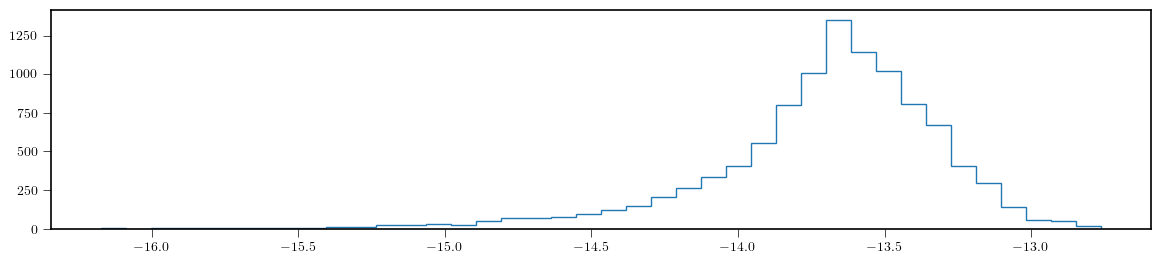

In [117]:
J0613_mapgamma_t0_post = J0613_mapgamma_core.get_param('ramp_t0')
t0_inside_mask = np.zeros(len(J0613_mapgamma_t0_post), dtype=bool)
t0min = min(J0613_mapgamma_t0_post)
t0max = max(J0613_mapgamma_t0_post)
for t0_idx, t0 in enumerate(J0613_mapgamma_t0_post):
    if t0 > t0min+180 and t0 < t0max - 270:
        t0_inside_mask[t0_idx] = True

plt.hist(J0613_mapgamma_core.get_param('ramp_log10_A')[t0_inside_mask], bins=40, histtype='step')

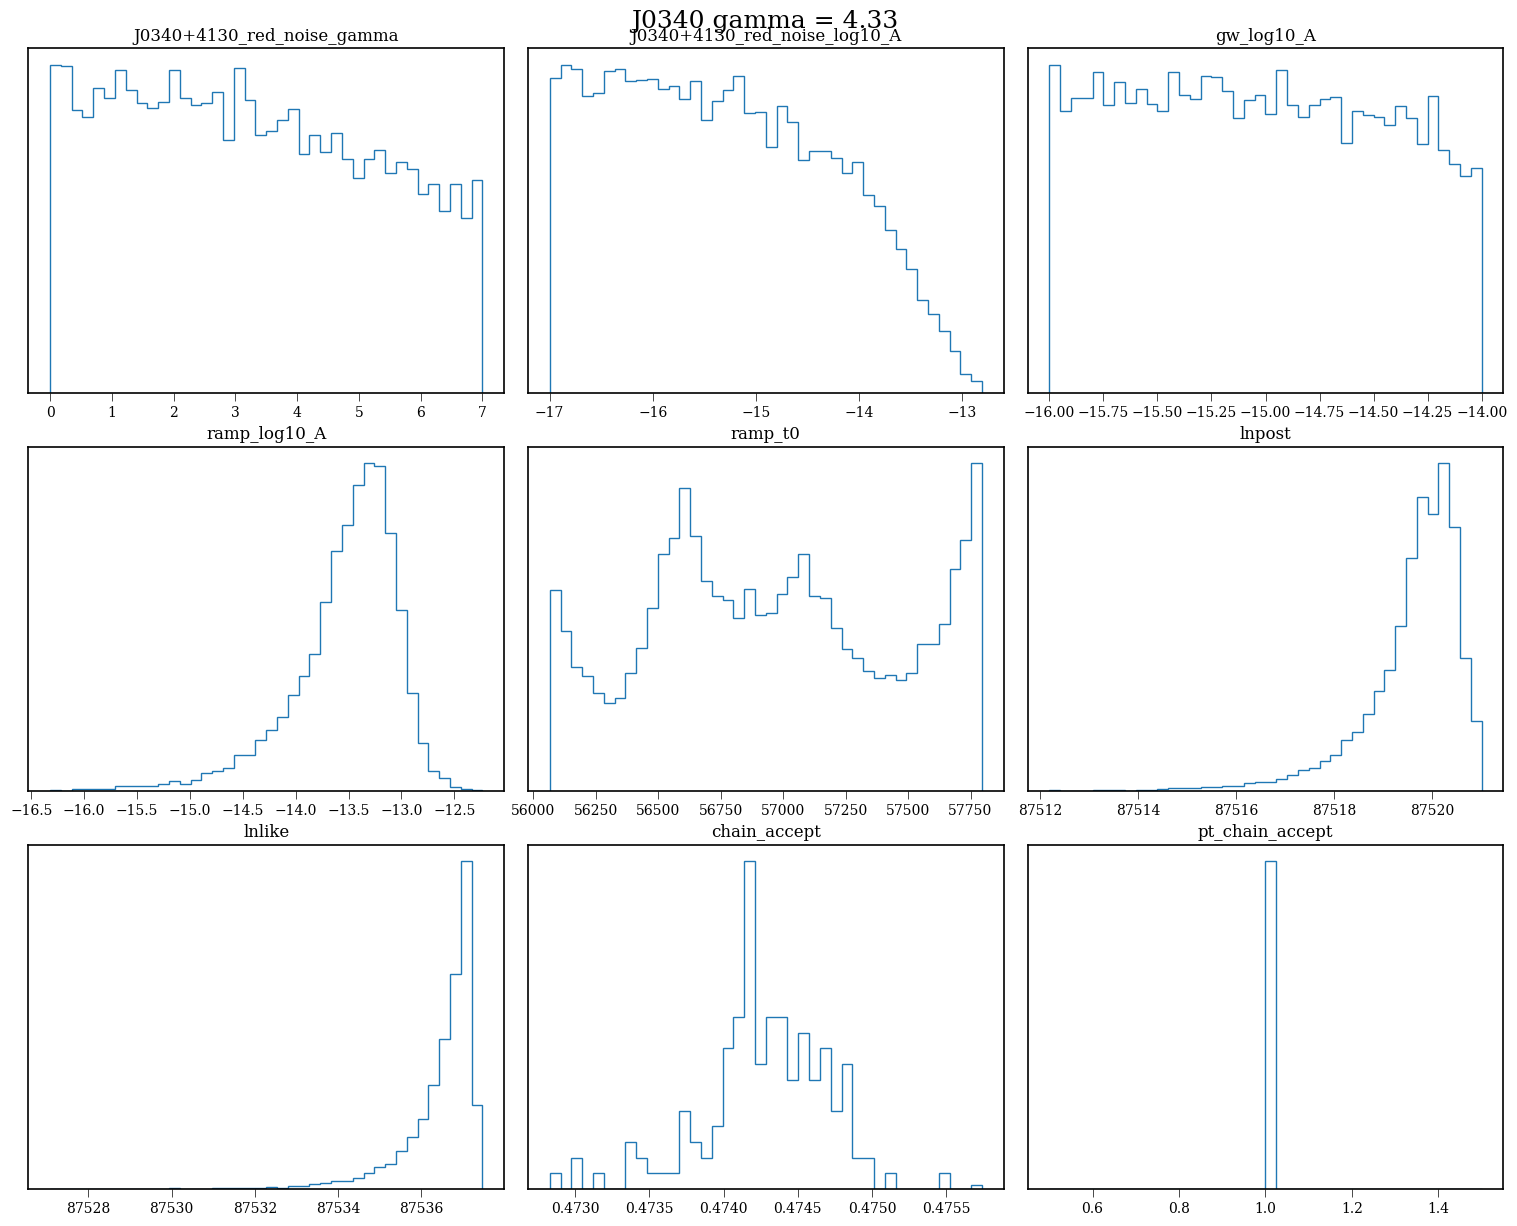

/home/nima/anaconda3/envs/nano15/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [15]:
plt.rcParams.update(plotchain_params)

chaindir = '/home/nima/nanograv/12p5yr_bwm/bayesian_verification/det_everything/J0340+4130_1/'
J0613_astro_core = Core(chaindir=chaindir)
plot_chains(J0613_astro_core, suptitle = 'J0340 gamma = 4.33')

plt.rcParams.update(params)

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 8.000e+00, 2.000e+00,
        1.200e+01, 9.000e+00, 1.900e+01, 2.000e+01, 1.700e+01, 4.400e+01,
        3.700e+01, 5.900e+01, 6.700e+01, 8.000e+01, 1.090e+02, 1.510e+02,
        2.150e+02, 2.620e+02, 3.720e+02, 4.960e+02, 6.480e+02, 8.920e+02,
        1.076e+03, 1.085e+03, 9.550e+02, 7.130e+02, 5.140e+02, 2.830e+02,
        1.050e+02, 4.000e+01, 4.000e+00, 3.000e+00]),
 array([-16.76775882, -16.66517262, -16.56258642, -16.46000021,
        -16.35741401, -16.25482781, -16.1522416 , -16.0496554 ,
        -15.9470692 , -15.84448299, -15.74189679, -15.63931059,
        -15.53672438, -15.43413818, -15.33155198, -15.22896577,
        -15.12637957, -15.02379336, -14.92120716, -14.81862096,
        -14.71603475, -14.61344855, -14.51086235, -14.40827614,
        -14.30568994, -14.20310374, -14.10051753, -13.99793133,
        -13.89534513, -13.79275892, -13.69017272, -13.

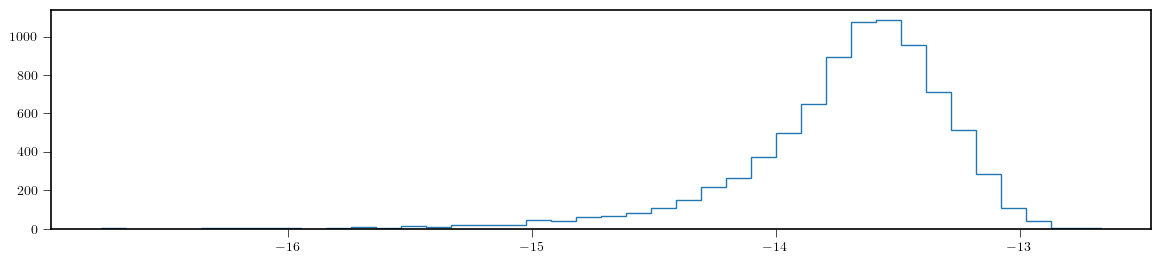

In [102]:
J0613_astro_t0_post = J0613_astro_core.get_param('ramp_t0')
t0_inside_mask = np.zeros(len(J0613_astro_t0_post), dtype=bool)

for t0_idx, t0 in enumerate(J0613_astro_t0_post):
    if t0 > 54500 and t0 < 57000:
        t0_inside_mask[t0_idx] = True

plt.hist(J0613_astro_core.get_param('ramp_log10_A')[t0_inside_mask], bins=40, histtype='step')

In [7]:
bootstrapped_UL95_dict = {}

In [8]:
for psr in allpsrs:
    os.makedirs('/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/'.format(psr.name), exist_ok=True)
    for sign in [-1.0, 1.0]:
        resampled_post_path = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/180days_{}.txt'.format(psr.name, sign)
        resampled_posterior = np.loadtxt(resampled_post_path)
        
        bootstrapped_UL95_dict[(psr.name, sign)] = []
        
        for i in range(1000): #bootstrap 1000 times
            bootstrapped_post = np.random.choice(resampled_posterior, replace=True, size=len(resampled_posterior))
            
            factlike_ul = sorted(bootstrapped_post)[int(0.95 * len(bootstrapped_post))]
            bootstrapped_UL95_dict[(psr.name, sign)].append(factlike_ul)
        print("Finished bootstrapping for PSR {} [sign = {}]".format(psr.name, sign))

Finished bootstrapping for PSR B1855+09 [sign = -1.0]
Finished bootstrapping for PSR B1855+09 [sign = 1.0]
Finished bootstrapping for PSR B1937+21 [sign = -1.0]
Finished bootstrapping for PSR B1937+21 [sign = 1.0]
Finished bootstrapping for PSR B1953+29 [sign = -1.0]
Finished bootstrapping for PSR B1953+29 [sign = 1.0]
Finished bootstrapping for PSR J0023+0923 [sign = -1.0]
Finished bootstrapping for PSR J0023+0923 [sign = 1.0]
Finished bootstrapping for PSR J0030+0451 [sign = -1.0]
Finished bootstrapping for PSR J0030+0451 [sign = 1.0]
Finished bootstrapping for PSR J0340+4130 [sign = -1.0]
Finished bootstrapping for PSR J0340+4130 [sign = 1.0]
Finished bootstrapping for PSR J0613-0200 [sign = -1.0]
Finished bootstrapping for PSR J0613-0200 [sign = 1.0]
Finished bootstrapping for PSR J0636+5128 [sign = -1.0]
Finished bootstrapping for PSR J0636+5128 [sign = 1.0]
Finished bootstrapping for PSR J0645+5158 [sign = -1.0]
Finished bootstrapping for PSR J0645+5158 [sign = 1.0]
Finished boot

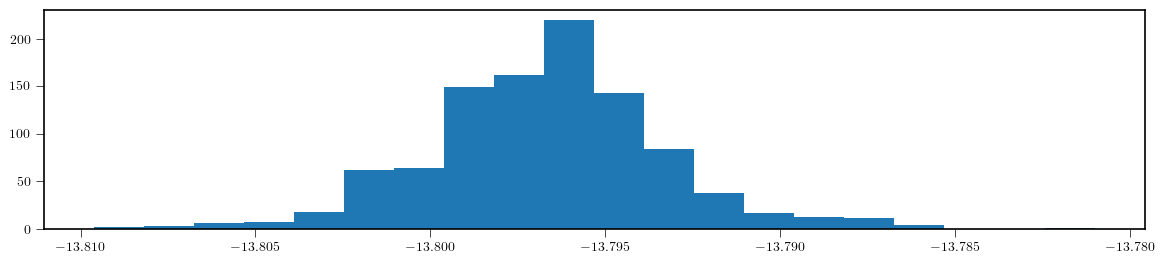

In [19]:
plt.hist(bootstrapped_UL95_dict[('J1713+0747', 1.0)], bins=20)
plt.show()

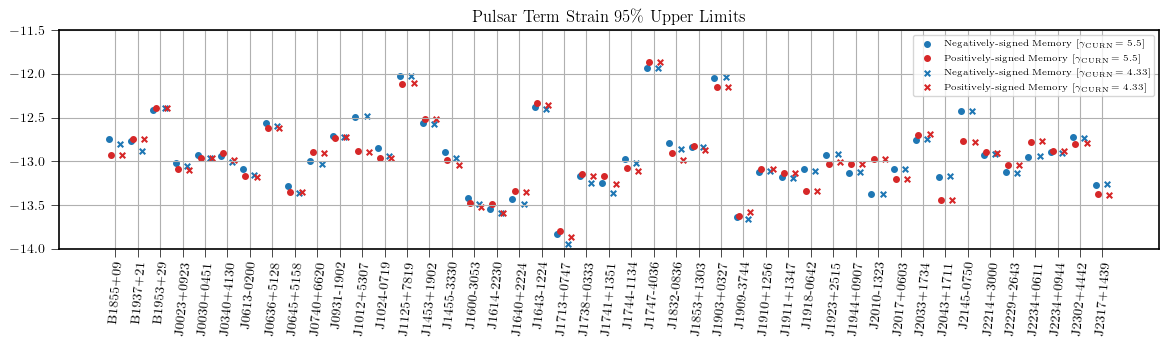

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1)

for ii_psr, psr in enumerate(allpsrs):
    neg_resampled_post_path = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/180days_{}.txt'.format(psr.name, -1.0)
    pos_resampled_post_path = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/180days_{}.txt'.format(psr.name, 1.0)
    neg_resampled_posterior = sorted(np.loadtxt(neg_resampled_post_path))
    pos_resampled_posterior = sorted(np.loadtxt(pos_resampled_post_path))
    
    
    neg_resampled_post_path_433 =  '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/resampled_amps/{}/180days_{}.txt'.format(psr.name, -1.0)
    pos_resampled_post_path_433 =  '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/resampled_amps/{}/180days_{}.txt'.format(psr.name, 1.0)
    neg_resampled_posterior_433 = sorted(np.loadtxt(neg_resampled_post_path_433))
    pos_resampled_posterior_433 = sorted(np.loadtxt(pos_resampled_post_path_433))
    
    neg_UL95 = sorted(neg_resampled_posterior)[int(0.95*len(neg_resampled_posterior))]
    pos_UL95 = sorted(pos_resampled_posterior)[int(0.95*len(pos_resampled_posterior))]
    
    neg_UL95_433 = sorted(neg_resampled_posterior_433)[int(0.95*len(neg_resampled_posterior_433))]
    pos_UL95_433 = sorted(pos_resampled_posterior_433)[int(0.95*len(pos_resampled_posterior_433))]
    
    
#     bootstrapping errors too small to see on plot
    
#     neg_bootstrap_post = sorted(bootstrapped_UL95_dict[(psr.name, -1.0)])
#     pos_bootstrap_post = sorted(bootstrapped_UL95_dict[(psr.name, 1.0)])

#     neg_CI_lower = neg_bootstrap_post[int(0.025*len(neg_bootstrap_post))]
#     neg_CI_upper = neg_bootstrap_post[int(0.975*len(neg_bootstrap_post))]

#     pos_CI_lower = pos_bootstrap_post[int(0.025*len(pos_bootstrap_post))]
#     pos_CI_upper = pos_bootstrap_post[int(0.975*len(pos_bootstrap_post))]


    #print("{} [{} , {}]".format(neg_UL95, neg_CI_lower, neg_CI_upper))

            
    neg_errcont = ax.scatter(ii_psr*2 - 0.6, neg_UL95, marker='o', color='tab:blue', label='Negatively-signed Memory [$\gamma_{\mathrm{MAP} = 5.5$]')
    pos_errcont = ax.scatter(ii_psr*2 -0.4, pos_UL95, marker='o', color='tab:red', label='Positively-signed Memory [$\gamma_{\mathrm{MAP} = 5.5$]')
    
    neg_errcont_433 = ax.scatter(ii_psr*2 + 0.4, neg_UL95_433, marker='x',color='tab:blue', label='Negatively-signed Memory [$\gamma_{\mathrm{SMBHB} = 4.33$]')
    pos_errcont_433 = ax.scatter(ii_psr*2 + 0.6, pos_UL95_433, marker='x',color='tab:red', label='Positively-signed Memory [$\gamma_{\mathrm{SMBHB} = 4.33$]')
    
    
ax.set_xticks(2*np.arange(len(allpsrs)))
ax.set_xticklabels([p.name for p in allpsrs], rotation=85)
ax.set_ylim(bottom=-14, top=-11.5)
ax.grid()
ax.legend(handles=[neg_errcont, pos_errcont, neg_errcont_433, pos_errcont_433], labels = ["Negatively-signed Memory [$\gamma_{\mathrm{CURN}} = 5.5$]", "Positively-signed Memory [$\gamma_{\mathrm{CURN}} = 5.5$]", "Negatively-signed Memory [$\gamma_{\mathrm{CURN}} = 4.33$]", 'Positively-signed Memory [$\gamma_{\mathrm{CURN}} = 4.33$]'])
    
plt.title("Pulsar Term Strain 95\% Upper Limits")
#plt.subplots_adjust(bottom=0.15)
plt.savefig('/home/nima/nanograv/12p5yr_bwm/paper_plots/psrterm_ULs_combined', format = 'pdf', bbox_inches='tight')
plt.show()

 # Now make comparisons

In [10]:
resampled_mapgamma_directory = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/'
resampled_433_directory = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/resampled_amps/'

UL95_diff = {}

for p in allpsrs:
    for sign in [-1.0,1.0]:
        try:
            resampled_mapgamma_post = sorted(np.loadtxt(resampled_mapgamma_directory + '{}/180days_{}.txt'.format(p.name, sign)))
            resampled_433_post = sorted(np.loadtxt(resampled_433_directory + '{}/180days_{}.txt'.format(p.name, sign)))

            mapgamma_ul = resampled_mapgamma_post[int(0.95*len(resampled_mapgamma_post))]
            resampled_433_ul = resampled_433_post[int(0.95*len(resampled_433_post))]

            UL95_diff[(p.name, sign)] = 10**mapgamma_ul - 10**resampled_433_ul
        except Exception as e:
            print("Could not do for {} [sign = {}]".format(p.name, sign))
            print(str(e))




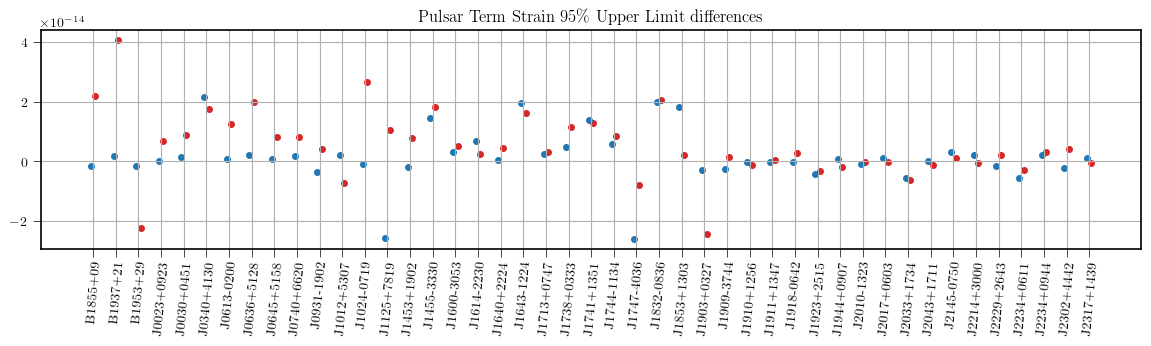

In [24]:
fig, ax = plt.subplots()
for pidx, p in enumerate(allpsrs):
    try:
        for sign in [-1.0, 1.0]:
            if sign > 0:
                ax.scatter(pidx - 0.1, UL95_diff[(p.name, sign)], color='tab:blue')
            else:
                ax.scatter(pidx + 0.1, UL95_diff[(p.name, sign)], color='tab:red')
    except:
        print("no data for PSR {} [sign = {}]".format(p.name, sign))
ax.set_xticks(np.arange(len(allpsrs)))
ax.set_xticklabels([p.name for p in allpsrs], rotation=85)
ax.grid()        

plt.title("Pulsar Term Strain 95\% Upper Limit differences")
plt.show() 


# Compute sign-marginalized upper limits for the psr-term rate UL

In [49]:
import random
def sample_hist(weights, centers, num_points=int(1e5), sample_bounds=None, verbose=False):
    #make sure the weights are properly normalized
    #print(weights)
    #print(centers)
    norm = np.sum(weights)
    normed_weights = weights/norm
    #print(normed_weights)
    
    #go through weights and see if there are lower and upper bounds. This will speed up resampling
    
            
            
    #print("lower, upper bounds are: {} and {}\nthe likelihoods between are {}:".format(lower, upper, normed_weights[lower:upper]))    
    
    
    accepted = 0
    
    resampled_chain = []    
    likelihood_interp = scipy.interpolate.interp1d(centers, normed_weights,kind='cubic')
    interpolate_domain = np.linspace(centers[0], centers[-1], 100*len(centers))
    interpolated_like = np.array([likelihood_interp(el) for el in interpolate_domain])
    
    
    
    
    if sample_bounds is None:
        while accepted < num_points:
            amp = random.uniform(centers[0], centers[-1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    else:
        while accepted < num_points:
            amp = random.uniform(sample_bounds[0], sample_bounds[1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    
    #fig, ax1 = plt.subplots()            
    #ax1.scatter(interpolate_domain, interpolated_like, label='Distribution Interpolator', marker='*', s=2)
    #ax1.set_ylim(0, max(interpolated_like) * 1.1)
    #ax2 = ax1.twinx()
    #ax2.hist(resampled_chain, density=True, histtype='step', label='Resampled Histogram', bins=30)
    #plt.show()
    #print(sorted(resampled_chain))
    return sorted(resampled_chain)

In [50]:
def resample_180day_cutoff_worker(psr):
    partial_outdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/'.format(psr.name)
    if not os.path.exists(partial_outdir):
        os.mkdir(partial_outdir)

    lookupdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/{}/'.format(psr.name)

    looktable_path = lookupdir + '{}_signmarg.txt'.format(psr.name, psr.name)
    looktable = np.loadtxt(looktable_path)

    parfile = lookupdir + 'pars.txt'.format(psr.name)
    with open(parfile, 'r') as f:
        parlines=f.readlines()

    pardict = {}
    for parline in parlines:
        key, np_pars = parline.split(';')

        start,stop,num = np_pars.split(',')
        pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
        #print(pardict)
    lookup_shape = (len(pardict['ramp_log10_A']), len(pardict['ramp_t0'])) #let's do this intelligently

    reshaped_looktable = np.reshape(looktable, lookup_shape, order='F')
    #         print(reshaped_looktable.shape)

    amps = pardict['ramp_log10_A']
    t0s = pardict['ramp_t0']
    signs = pardict['sign']




    tmin_mjd_lim = t0s[0] + 180
    tmax_mjd_lim = t0s[-1] - 270

    tmin_idx = np.argmin(np.abs(t0s - tmin_mjd_lim)) 
    tmax_idx = np.argmin(np.abs(t0s - tmax_mjd_lim))

    tmin_mjd = t0s[tmin_idx]
    tmax_mjd = t0s[tmax_idx]


    print("not looking for bursts between MJD {} and MJD {}".format(tmin_mjd, tmax_mjd))
    cols = np.arange(tmin_idx, tmax_idx)

    log10_A_post = np.zeros(len(amps)) 

    for log10A_idx in range(len(log10_A_post)):
        submtx_max = np.amax(reshaped_looktable[log10A_idx, :])
        #print(submtx_max)
        #print(np.amin(reshaped_looktable[log10A_idx, :, :]))
        this_l10A_likes = np.zeros(len(cols)) # populate a grid to integrate over to find the
                                             # epoch-averaged likelihood for this amplitude


        for ii, t0_idx in enumerate(cols):
            # need to add them all into this_l10A_like
            #if reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max > 10:
            #    print("Large likelihood diff")
            like = np.exp(reshaped_looktable[log10A_idx, t0_idx]-submtx_max)
            corrected_like = like # no amplitude factor bc integrating over t0
            this_l10A_likes[ii] = corrected_like

        # only need to integrate over the bounds of my custom columns  
        this_l10A_like = spint.simpson(y=this_l10A_likes, x=t0s[cols[0]:cols[-1]+1])
        log10_A_post[log10A_idx] = np.log(this_l10A_like) + submtx_max


    #post-process the log10_amps
    reduced_post=log10_A_post - np.amax(log10_A_post)
    post = np.exp(reduced_post)    
    for amp_idx, amp in enumerate(amps):
        post[amp_idx] = 10**amp * post[amp_idx]

    outfile = partial_outdir + '{}days_signmarg.txt'.format(180)
    plt.scatter(amps, post, )
    plt.title("PSR {} amplitude posterior".format(psr.name))
    plt.show()
    plt.close()
    # now build the resampled thing and write it to disk
    resampled = sample_hist(post, amps, num_points = 10000,)
    np.savetxt(outfile, resampled)
        #result_dict[sign] = resampled
    #return result_dict

not looking for bursts between MJD 53630.2357576196 and MJD 57537.911635561344


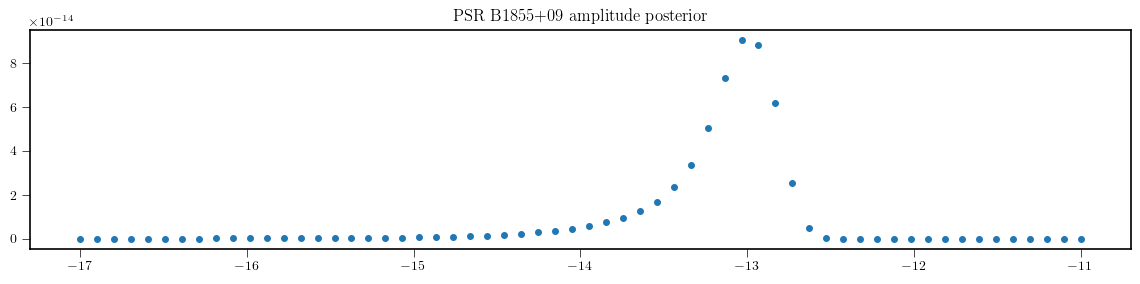

[None]

In [51]:
pool = mp.Pool(processes=2)
pool.map(resample_180day_cutoff_worker,allpsrs[0:1])

[41  7  9 13 36 14 30 40 42 25 10 35 43  5 24 39 32  2 22 37  3 26  8 27
 21 12 34 29 17 33 16  6 18  4 20  0 44 19 31 28 38  1 11 15 23]


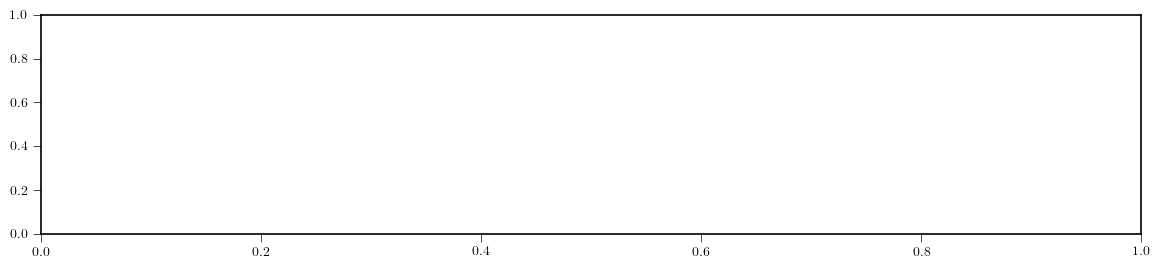

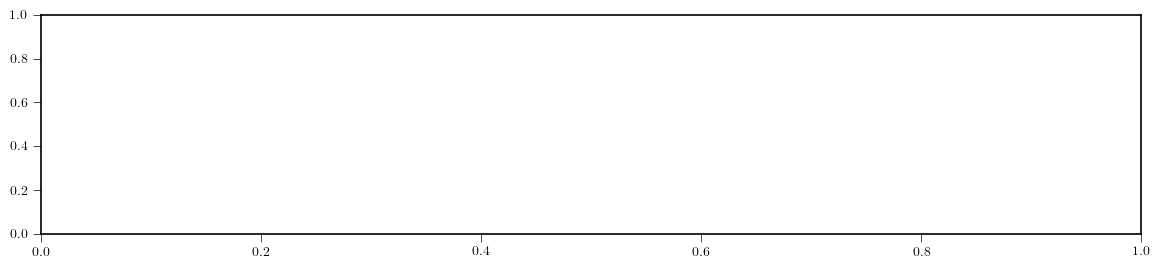

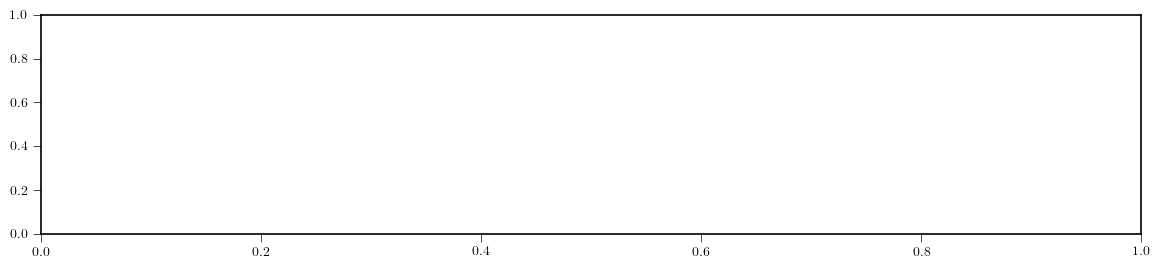

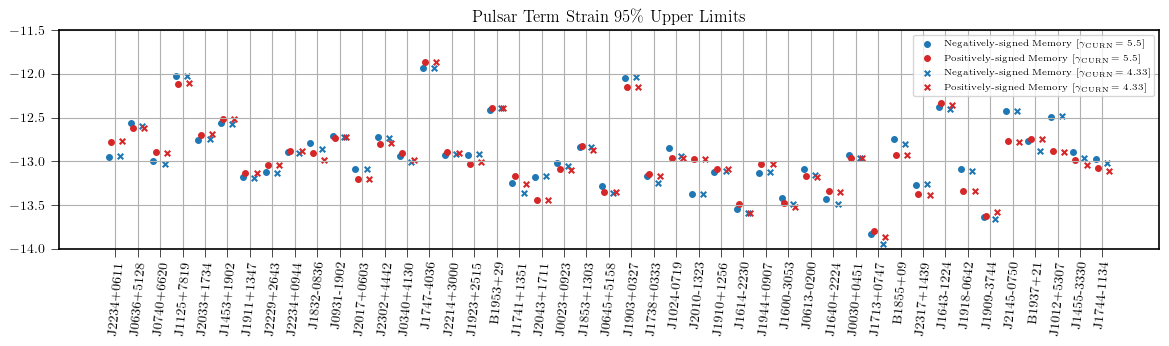

In [64]:
allpsrs_tspans = []
for psr in allpsrs:
    allpsrs_tspans.append(psr.toas.max() - psr.toas.min())

psr_tspan_isort = np.argsort(allpsrs_tspans)
print(psr_tspan_isort)

fig, ax = plt.subplots(nrows=1, ncols=1)

for _isort_idx, ii_psr in enumerate(psr_tspan_isort):
    psr = allpsrs[ii_psr]
    neg_resampled_post_path = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/180days_{}.txt'.format(psr.name, -1.0)
    pos_resampled_post_path = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/180days_{}.txt'.format(psr.name, 1.0)
    neg_resampled_posterior = sorted(np.loadtxt(neg_resampled_post_path))
    pos_resampled_posterior = sorted(np.loadtxt(pos_resampled_post_path))
    
    
    neg_resampled_post_path_433 =  '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/resampled_amps/{}/180days_{}.txt'.format(psr.name, -1.0)
    pos_resampled_post_path_433 =  '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/resampled_amps/{}/180days_{}.txt'.format(psr.name, 1.0)
    neg_resampled_posterior_433 = sorted(np.loadtxt(neg_resampled_post_path_433))
    pos_resampled_posterior_433 = sorted(np.loadtxt(pos_resampled_post_path_433))
    
    neg_UL95 = sorted(neg_resampled_posterior)[int(0.95*len(neg_resampled_posterior))]
    pos_UL95 = sorted(pos_resampled_posterior)[int(0.95*len(pos_resampled_posterior))]
    
    neg_UL95_433 = sorted(neg_resampled_posterior_433)[int(0.95*len(neg_resampled_posterior_433))]
    pos_UL95_433 = sorted(pos_resampled_posterior_433)[int(0.95*len(pos_resampled_posterior_433))]
    
    
#     bootstrapping errors too small to see on plot
    
    neg_bootstrap_post = sorted(bootstrapped_UL95_dict[(psr.name, -1.0)])
    pos_bootstrap_post = sorted(bootstrapped_UL95_dict[(psr.name, 1.0)])

    neg_CI_lower = np.abs(neg_bootstrap_post[int(0.025*len(neg_bootstrap_post))] - neg_UL95)
    neg_CI_upper = np.abs(neg_bootstrap_post[int(0.975*len(neg_bootstrap_post))] - neg_UL95)

    pos_CI_lower = np.abs(pos_bootstrap_post[int(0.025*len(pos_bootstrap_post))] - pos_UL95)
    pos_CI_upper = np.abs(pos_bootstrap_post[int(0.975*len(pos_bootstrap_post))] - pos_UL95)


    #print("{} [{} , {}]".format(neg_UL95, neg_CI_lower, neg_CI_upper))

            
    neg_errcont = ax.scatter(_isort_idx*2 - 0.6, neg_UL95, marker='o', color='tab:blue', label='Negatively-signed Memory [$\gamma_{\mathrm{MAP} = 5.5$]')
    pos_errcont = ax.scatter(_isort_idx*2 -0.4, pos_UL95, marker='o', color='tab:red', label='Positively-signed Memory [$\gamma_{\mathrm{MAP} = 5.5$]')
    
    neg_errcont_433 = ax.scatter(_isort_idx*2 + 0.4, neg_UL95_433, marker='x',color='tab:blue', label='Negatively-signed Memory [$\gamma_{\mathrm{SMBHB} = 4.33$]')
    pos_errcont_433 = ax.scatter(_isort_idx*2 + 0.6, pos_UL95_433, marker='x',color='tab:red', label='Positively-signed Memory [$\gamma_{\mathrm{SMBHB} = 4.33$]')
#     neg_errcont = ax.errorbar(_isort_idx*2 - 0.6, neg_UL95, yerr = np.array([neg_CI_lower, neg_CI_upper]).T, marker='o', color='tab:blue', label='Negatively-signed Memory [$\gamma_{\mathrm{MAP} = 5.5$]')
#     pos_errcont = ax.errorbar(_isort_idx*2 - 0.4, pos_UL95, yerr = np.array([pos_CI_lower, pos_CI_upper]).T, marker='o', color='tab:red', label='Positively-signed Memory [$\gamma_{\mathrm{MAP} = 5.5$]')
    
#     neg_errcont_433 = ax.errorbar(_isort_idx*2 + 0.4, neg_UL95_433, marker='x',color='tab:blue', label='Negatively-signed Memory [$\gamma_{\mathrm{SMBHB} = 4.33$]')
#     pos_errcont_433 = ax.errorbar(_isort_idx*2 + 0.6, pos_UL95_433, marker='x',color='tab:red', label='Positively-signed Memory [$\gamma_{\mathrm{SMBHB} = 4.33$]')

    
ax.set_xticks(2*np.arange(len(allpsrs)))
ax.set_xticklabels([allpsrs[_].name for _ in psr_tspan_isort], rotation=85)
ax.set_ylim(bottom=-14, top=-11.5)
ax.grid()
ax.legend(handles=[neg_errcont, pos_errcont, neg_errcont_433, pos_errcont_433], labels = ["Negatively-signed Memory [$\gamma_{\mathrm{CURN}} = 5.5$]", "Positively-signed Memory [$\gamma_{\mathrm{CURN}} = 5.5$]", "Negatively-signed Memory [$\gamma_{\mathrm{CURN}} = 4.33$]", 'Positively-signed Memory [$\gamma_{\mathrm{CURN}} = 4.33$]'])
    
plt.title("Pulsar Term Strain 95\% Upper Limits")
#plt.subplots_adjust(bottom=0.15)
plt.savefig('/home/nima/nanograv/12p5yr_bwm/paper_plots/psrterm_ULs_combined', format = 'pdf', bbox_inches='tight')
plt.show()

In [65]:
neg_errcont

In [66]:
pos_ul95_dict_433 = {}
neg_ul95_dict_433 = {}
pos_ul95_dict_55 = {}
neg_ul95_dict_55 = {}

for psr in allpsrs:
    neg_resampled_post_path = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/180days_{}.txt'.format(psr.name, -1.0)
    pos_resampled_post_path = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_det_RN_mapgamma/resampled_amps/{}/180days_{}.txt'.format(psr.name, 1.0)
    neg_resampled_posterior = sorted(np.loadtxt(neg_resampled_post_path))
    pos_resampled_posterior = sorted(np.loadtxt(pos_resampled_post_path))
    
    pos_ul95_dict_55[psr.name] = pos_resampled_posterior[int(0.95 * len(pos_resampled_posterior))]
    neg_ul95_dict_55[psr.name] = neg_resampled_posterior[int(0.95 * len(neg_resampled_posterior))]
    
    neg_resampled_post_path_433 =  '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/resampled_amps/{}/180days_{}.txt'.format(psr.name, -1.0)
    pos_resampled_post_path_433 =  '/home/nima/nanograv/12p5yr_bwm/lookup_tables_det_RN/resampled_amps/{}/180days_{}.txt'.format(psr.name, 1.0)
    neg_resampled_posterior_433 = sorted(np.loadtxt(neg_resampled_post_path_433))
    pos_resampled_posterior_433 = sorted(np.loadtxt(pos_resampled_post_path_433))
    
    pos_ul95_dict_433[psr.name] = pos_resampled_posterior_433[int(0.95 * len(pos_resampled_posterior_433))]
    neg_ul95_dict_433[psr.name] = neg_resampled_posterior_433[int(0.95 * len(neg_resampled_posterior_433))]

In [71]:
outdir = "/home/nima/nanograv/12p5yr_bwm/paper_data/"

json.dump(pos_ul95_dict_55, open(outdir+'ULvPSR_MAP_pos.json','w+'), indent=4,)
json.dump(neg_ul95_dict_55, open(outdir+'ULvPSR_MAP_neg.json','w+'), indent=4,)

json.dump(pos_ul95_dict_433, open(outdir+'ULvPSR_SMBHB_pos.json','w+'), indent=4,)
json.dump(neg_ul95_dict_433, open(outdir+'ULvPSR_SMBHB_neg.json','w+'), indent=4,)



NameError: name 'close' is not defined